# Project: ImmClassifier
## Author: Xuan Liu
## Date: 10/10/2019
## Description

 ImmClassifier integrates mutiple cancer single-cell RNA-Seq datasets and the start-of-art machine learning and deep learning techniques to predict immune cell types single-cell RNA-Seq dataset.


## Part I: R

This part includes the code to train one random forest classifier for each trainig dataset. It is implemented using MLR package in R.


In [ ]:
# load required R packages

library(dplyr)
library(mlr)
library(sva)
library(stringr)
library(randomForest)



mlr_pred <- function(lrn.name="classif.randomForest", refdat.path, refdat.name, ext.dat, num.cores, mode){
  # Train a random forest model to predict cell types using one reference dataset
  #
  # Args:
  #   lrn.name: random.forest
  #   train.dat: part of the reference dataset with cell as rows and feature as columns, 
  #   the last column is target(celltype)
  #   test.dat: held-out part of the reference dataset for evaluating, cell by feature, 
  #   last column is target
  #   ext.dat: query dataset datframe in format of cell by feature 
    
  #
  # Returns:
  #   a list containing trained random forest model, prediction of training part and held-out part of reference dataset,
  #    prediction of query dataset, evaluation result using in trainig
  #   and test parts of the trainng dataset.    
  
    
    
  print(paste0("Training a classifier from ", refdat.name))  
    
  # partition the reference dataset into training and held-out part
  # batch correction between reference and query datasets
    
  dat.folds <- dat_partition(refdat.path, ext.dat)  
  train.dat <- dat.folds[['train']] 
  test.dat <- dat.folds[['test']]
  ext.dat <- dat.folds[['ext']]
    
  if(mode == "debug"){ # use a small number of cells to debug the workflow
        print ("Activate debug mode, use 1000 cells for training")
        train.dat <- train.dat[sample(1:nrow(train.dat), 1000), ]
  }
    

  # train a random forest classifier using the training part of reference dataset
  task <- makeClassifTask(id = lrn.name, dat = train.dat, target = "target")
  lrn <- makeLearner(lrn.name, predict.type = "prob")
  mod <- train(lrn, task)

  # apply the trained model to training, test part of the reference dataset and query dataset  
  pred.train <- predict(mod, task = task)
  pred.test <- predict(mod, newdat = test.dat)
  pred.ext <- predict(mod, newdat = ext.dat)

  # evaluation of performance within training part and test part of reference dataset
  measure.list <- list(mlr::multiclass.aunp,  acc, mlr::timepredict)
  perf.train <- performance(pred.train, measures = measure.list)
  perf.test <- performance(pred.test, measures = measure.list)

  print("Prediction evaluation using held-out samples in reference dataset")
  print("-----------------------------------------------------------------")
  print (perf.test)

  #return (list(mod, pred.train, pred.test, pred.ext, perf.train, perf.test))
  #return the probabilities of query cells across all cell types in reference dataset
    
  ref.index <- str_extract(refdat.name, "Ref[0-9]")
  colnames(pred.ext$data) <- gsub("prob", ref.index,  colnames(pred.ext$data))
  return (pred.ext$data[, !grepl("response", colnames(pred.ext$data))])  
    
}




dat_partition <- function(refdat.path, ext.dat){
  # This function performs:
  # 1. Batch correction between the query dataset and reference dataset
  # 2. partition of reference dataset into training and held-out parts
  #
  # Args:
  #   train.dat.path: reference dat path in RDS format
  #   ext.dat: query dataset datframe in format of cell by feature 
    
  #
  # Returns:
  #   a list containing trained random forest model, prediction of training part 
  #   and held-out part of reference dataset, prediction of query dataset, evaluation 
  #   result using in training and test parts of the trainng dataset.   
  # 
    
    
  print (paste("load train/test parition from training set", refdat.path))
  train.test.mat <- readRDS(refdat.path)
    
  # due to high drop-out rate, only feature genes that are expressed in query dataset will be used
  common.genes <- intersect(colnames(train.test.mat$train), colnames(ext.dat))
  print(paste("Feature reduced from #", ncol(train.test.mat$train), "to", length(common.genes)))
  ext.feat.mat <- ext.dat[, common.genes]
    
  # For reference dataset, only immune cells are used.
  # In case that held-out cells contain non-immune cells, 
  # non-immune held-out cells are filtered out.
  train.class <- train.test.mat$train %>% count(target) %>% select(target)  %>% unlist
  train.test.mat$test <- train.test.mat$test[train.test.mat$test$target %in% train.class, ]  
  

  # use ComBat to correct the batch effect between ref and query dataset
  
  uncorrected.matrix <- rbind(data.frame(train.test.mat$train[, common.genes], dataset="ref", stringsAsFactors = F),
                              data.frame(train.test.mat$test[, common.genes], dataset="ref", stringsAsFactors = F),
                              data.frame(ext.feat.mat[, common.genes], dataset = "query", stringsAsFactors = F)
                             )
  corrected.matrix <- t(ComBat(t(uncorrected.matrix[, -ncol(uncorrected.matrix)]), uncorrected.matrix$dataset))
  
    
  trainN <- nrow(train.test.mat$train)
  testN <- nrow(train.test.mat$test)
  queryN <- nrow(ext.feat.mat)
    
  train.corrected <- data.frame(corrected.matrix[1:trainN,],
                                target=train.test.mat$train$target, stringsAsFactors = F)
    
  test.corrected <- data.frame(corrected.matrix[(trainN+1):(trainN+testN),],
                                     target =train.test.mat$test$target, stringsAsFactors = F)
    
  ext.corrected <- data.frame(corrected.matrix[(trainN+testN+1):nrow(corrected.matrix),])
  
  return(list(train=train.corrected, test=test.corrected, ext=ext.corrected))
 
}



within_reference_pred <- function(queryfile.path, output.prefix = "query", num.cores = 1, mode = "run"){
  # This function call mlr_pred to predict for each reference dataset
  # 
  # 
  #
  # Args:
  # 
  #   queryfile.path: path of the query dataset in tab-delimited text file with
  #   the rows as gene symbol, and columns as sampleID.
    
  #
  # Returns:
  #   a list containing trained random forest model, prediction of training part 
  #   and held-out part of reference dataset, prediction of query dataset, evaluation 
  #   result using in training and test parts of the trainng dataset.   
  # 
  
    if(grepl("rds$", queryfile.path)){
        ext.dat <- readRDS(queryfile.path)
    }else{
        print (paste("Open query file", queryfile.path))
        ext.dat <- read.table(queryfile.path, header = T, sep = "\t", row.names = 1, stringsAsFactors = F)
        rownames(ext.dat) <- gsub("-|_", ".", toupper(rownames(ext.dat)))
        ext.dat <- t(ext.dat)
        
    
    }
    
    
    reference.paths <- c('Ref1: The Human Cell Atlas bone marrow single-cell interactive web portal' = 'hca-bm', 
                         'Ref2: Circulating immune cell phenotype dynamics reflect the strength of tumor-immune cell interactions in patients during immunotherapy' = 'pbmc', 
                         'Ref3: Single cell RNA sequencing of human liver reveals distinct intrahepatic macrophage populations' = 'liver-immune',
                         'Ref4: Human bone marrow assessment by single-cell RNA sequencing, mass cytometry, and flow cytometry' = 'jci-bm',
                         'Ref5: Single-Cell Transcriptomics of Human and Mouse Lung Cancers Reveals Conserved Myeloid Populations across Individuals and Species' = 'nsclc-zilionis-tii-minor',
                         'Ref6: Single-cell profiling of breast cancer T cells reveals a tissue-resident memory subset associated with improved prognosis' = 'brcatil',
                         'Ref7: Global characterization of T cells in non-small-cell lung cancer by single-cell sequencing' = 'nsclc-guo')
    
      
    lrn.name <- "classif.randomForest"
    res <- mlr_pred(lrn.name, 
                    refdat.path = paste0("feature_data/", reference.paths[1], "-train-test-dat.rds"), 
                    refdat.name = names(reference.paths)[1], 
                    ext.dat, num.cores, mode)
    
    
    # concatenate prediction probabilities from all reference datasets
    for (i in 2:length(reference.paths)){
        
        res <- cbind(res, 
                     mlr_pred(lrn.name, 
                              refdat.path = paste0("feature_data/", reference.paths[i], "-train-test-dat.rds"), 
                              refdat.name = names(reference.paths)[i], ext.dat, num.cores, mode))
        
        
    }
    
   print(paste0("Write concanetated probabilities to tensorflow/input/",output.prefix, ".dnn.input.txt"))
   write.table(data.frame("Cell" = rownames(res), res), 
               paste0('tensorflow/input/', output.prefix, ".dnn.input.txt"), 
               quote = F, row.names = F, sep = "\t")
  #return (0)
}




# R command line

In [ ]:
within_reference_pred(queryfile.path = "evaluation_data/bulk.logrma.txt", output.prefix = "bulk", mode = "run")
within_reference_pred(queryfile.path = "evaluation_data/brca.3p.lcpm.rds", output.prefix = "brca3p", mode = "run")
within_reference_pred(queryfile.path = "evaluation_data/brca.5p.lcpm.rds", output.prefix = "brca5p",mode = "run")
within_reference_pred(queryfile.path = "evaluation_data/hcc.lcpm.rds", output.prefix = "hcc",mode = "run")
within_reference_pred(queryfile.path = "evaluation_data/hnscc.ltpm.rds", output.prefix = "hnscc",mode = "run")
within_reference_pred(queryfile.path = "evaluation_data/pbmc68k.lcpm.rds", output.prefix = "pbmc68k",mode = "run")
within_reference_pred(queryfile.path = "evaluation_data/skcm.nh.ltpm.rds", output.prefix = "skcm",mode = "run")


In [ ]:
# generate training datasets for deep learning
annotation <- read.table('annotation_data/dataset.txt', header = T, sep = "\t", stringsAsFactors=F)
annotation <- annotation %>% filter(!Hierarchy == "X")
rownames(annotation) <- annotation$ClusterID
valid.classes <- annotation %>% count(ClusterID) %>% select(ClusterID) %>% unlist
annotation %>% select(Hierarchy, CellOntology) %>% table %>% apply(1, function(x) names(x[x>0]))
                                                                   
                                                                   
                                                                   

In [ ]:
deeplearn.train <- readRDS('tensorflow/input/deeplearn.train.rds')
#deeplearn.train <- deeplearn.train %>% mutate(cell = rownames(deeplearn.train))
deeplearn.train <- deeplearn.train %>% filter(clusterID %in% valid.classes)

deeplearn.train <- deeplearn.train %>%
                        mutate(Hierarchy=annotation[clusterID, 'Hierarchy']) %>%
                        filter(!is.na(Hierarchy))
                                 


In [ ]:
# generate mixed bits




cover_set <- function(leaves){
    cset <- c()
    
    for(leaf in leaves){
        
    
        for (node in strsplit(leaf, ";")[[1]]){
            
            elements <- strsplit(node, ":")[[1]]
            i <- length(elements)
            
            current <- elements[1]

            cset <- c(cset, current)
            while (i > 1){
                current <- elements[1]
                for(j in 2:i){
                    
                    current <- paste(current, elements[j], sep = ":")
                    
                    cset <- c(cset, current)
                }
                i <- i-1
            }

            


        }
        
    }    
    return (cset)
}




# create child-parent-link

convert_to_bits <- function(nodes, ref.nodes){

    target.bits <- rep(0, length(ref.nodes))
    names(target.bits) <- ref.nodes
    
    
    for (node in strsplit(nodes, ";")[[1]]){
        
        elements <- strsplit(node, ":")[[1]]
        
        i <- 1
        current <- ""
        while(i <= length(elements)){
            
            if(i == 1){
                current <- paste0(current, elements[i])
            }else{
                current <- paste(current, elements[i], sep = ":")
            }
            target.bits[current] <- 1
            i <- i+1
        }
    
    }
    
    #print (paste0("return ",paste(target.bits, collapse = ",")))
   return(paste(target.bits, collapse = ","))
}



In [ ]:
set.seed(100)


cluster.size <- deeplearn.train %>% 
                    count(Hierarchy) %>% 
                    #[0, 500), 200
                    #[500, 1k), 500
                    #[1k, 5k), 1k
                    #[5k, ], 2k
                    #mutate(samplesize =1500) %>%
                    #mutate(samplesize = ifelse(n<5000, 1000, 2000)) %>%
                    mutate(samplesize = ifelse(n<1000,1000, ifelse(n<2000, 1200, ifelse(n<5000, 1400, 1600)))) %>% 
                    data.frame(stringsAsFactors =F)
rownames(cluster.size) <- cluster.size$Hierarchy


cluster.size['L:T:CD8:Mait', 'samplesize'] <- 1300



deeplearn.train.sample <- deeplearn.train %>% group_by(Hierarchy) %>% 
                                    sample_n(cluster.size[Hierarchy, 'samplesize'], replace = T)



ref.nodes <-  annotation %>% select(Hierarchy) %>% unlist %>% unique %>% cover_set %>% unique
deeplearn.train.sample <- deeplearn.train.sample %>% mutate(Evopath = convert_to_bits(Hierarchy, ref.nodes))

write.table(deeplearn.train.sample, 'tensorflow/input/deeplearn.train.balance.input.txt', quote = F, sep = "\t", row.names = F)

# Part II: Python

In [ ]:
#conda activate PyCPU
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
import numpy as np
import random
from sklearn import metrics
from keras.layers import Dropout
import keras.models

In [24]:
def logit(x, norm):
    if norm=='original':
    # hca
        x[:, 0:35] = x[:, 0:35] * np.sqrt(35) # by total number of cell types in annotation    
    # pbmc
        x[:, 35:69] = x[:, 35:69] * np.sqrt(34) # by total number of cell types in annotation    
    # liver
        x[:, 69:78] = x[:, 69:78] * np.sqrt(9) # by total number of cell types in annotation    
    # jcibm
        x[:, 78:97] = x[:, 78:97] * np.sqrt(19) # by total number of cell types in annotation   
    # nsclctii
        x[:, 97:139] = x[:, 97:139] * np.sqrt(42) # by total number of cell types in annotation    
    # brcat t only
        x[:, 139:148] = x[:, 139:148] * np.sqrt(9)/2 # by total number of cell types in annotation    
    # nsclc t only
        x[:, 148:171] = x[:, 148:171] * np.sqrt(23)/2 # by total number of cell types in annotation
    if norm == 'ontotree':
        x[:, 0:35] = x[:, 0:35] * np.sqrt(12) # by total number of cell types in cell ontology hierarchy
        x[:, 35:69] = x[:, 35:69] * np.sqrt(17) # by total number of cell types in cell ontology hierarchy
        x[:, 69:78] = x[:, 69:78] * np.sqrt(5) # by total number of cell types in cell ontology hierarchy
        x[:, 78:97] = x[:, 78:97] * np.sqrt(13) # by total number of cell types in cell ontology hierarchy
        x[:, 97:139] = x[:, 97:139] * np.sqrt(10) # by total number of cell types in cell ontology hierarchy
        x[:, 139:148] = x[:, 139:148] * np.sqrt(7) # by total number of cell types in cell ontology hierarchy
        x[:, 148:171] = x[:, 148:171] * np.sqrt(11) # by total number of cell types in cell ontology hierarchy
    x = x/x.sum(axis = 1)[:, np.newaxis]
    p = 0.001+x*0.998
    logit = np.log(p/(1-p))
    return logit


;

\

                                      
def multilabel_model_thread(input_dim, output_dim):
 # create model
    model = Sequential()
    #model.add(Dropout(0.2))
    model.add(Dense(200, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(400, input_dim=200, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(200, input_dim=200, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(output_dim,  activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model                          

ERROR: Error in parse(text = x, srcfile = src): <text>:1:5: unexpected symbol
1: def logit
        ^


In [ ]:
# fix random seed for reproducibility
seed = 100
np.random.seed(seed)
input_file = pd.read_csv("./tensorflow/input/deeplearn.train.balance.input.txt", sep = "\t")
data =input_file.values


norm_method = "ontotree"


X_train = data[:, 0:171].astype(float)
y_train = np.array([[int(x) for x in str.split(y, sep = ",")] for y in data[:, 174]])
X_train  = logit(X_train, norm_method)
                     
# Train the models from the begining                     


num_model = 10
stochastic_models = [multilabel_model_thread(input_dim = X_train.shape[1], output_dim = y_train.shape[1]) for i in range(0,num_model)]
y_train_stochastic = y_train

for i in range(0, num_model):
    stochastic_models[i].fit(X_train, y_train_stochastic, epochs = 5, batch_size = 2048)

# serialize weights to HDF5
[stochastic_models[i].save("./tensorflow/pre-trained-models/model_%s_%d_n10.h5" % (norm_method, i) ) for i in range(0, 10)]
print("Saved trained model to disk")

In [ ]:
dnn_predict('bulk')
dnn_predict('hcc')
dnn_predict('brca3p')
dnn_predict('brca5p')
dnn_predict('hnscc')
dnn_predict('skcm')
dnn_predict('pbmc68k')



# Part III

In [208]:
find_parent <- function(node){
    parent <- "Immune_Cell"
    if(grepl(":", node)){
        parent <- gsub(":[^:]+$", "", node)
    }
    return (parent)
}



find_path <- function(node){
    
    path <- c(node)
    while (grepl(":", node)){
        parent <- find_parent(node)
        path <- c(path, parent)
        node <- parent
    }  
    return (path)
}

construct_tree <- function(){
    
  tree <- list()
  tree[[1]] <- list(c('CD34', 'M', 'L'))
  names(tree[[1]]) <- 'Immune_Cell'
  
  tree[[2]] <- list(c('CD34:HSC'),
                   c('L:B', 'L:T', 'L:NK', 'L:pDC', 'L:unconvT'),
                   c('M:pDC',  'M:cDC', 'M:Eos', 'M:Ery', 'M:Mac', 'M:Mast', 'M:Mega', 'M:Mono', 'M:Neu'))  
   
  names(tree[[2]]) <- c('CD34', 'M', 'L')

  tree[[3]] <- list(c('L:B:PC'),
                    c('L:T:CD4', 'L:T:CD8'),
                    c('M:Mega:Platelet')
                   )
  names(tree[[3]]) <- c('L:B', 'L:T', 'M:Mega')
    
    
    
  tree[[4]] <- list(c('L:T:CD4:CM', 'L:T:CD4:EM', 'L:T:CD4:Ex', 'L:T:CD4:Naïve', 'L:T:CD4:Tfh', 'L:T:CD4:Treg', 'L:T:CD4:TRM'),
                    c('L:T:CD8:CM', 'L:T:CD8:EM', 'L:T:CD8:Ex', 'L:T:CD8:Mait', 'L:T:CD8:Naïve', 'L:T:CD8:TRM')
                   )
  names(tree[[4]]) <- c('L:T:CD4','L:T:CD8')  
    
  return(tree)  
}


get_entropy <- function(p){
    if(p <= 0 | p == 1){return (0)}
    return(-p*log(p)-(1-p)*log(1-p))
}


tie_breaker <- function(candidates){
    
    
    if(length(candidates) == 1) {return (candidates[1])}
    
    # find common ancestors
    paths <- list()
    for(i in 1:length(candidates)){
        paths[[i]] <- c(find_path(candidates[i]), 'Immune_Cell')
    }
  
    
    i <- 1
    
    while(i <= length(paths[[1]]) ){
        cas <- TRUE
        
        for (j in 2:length(paths)){
            
            if(! (paths[[1]][i] %in% paths[[j]])){
                cas <- FALSE
                break
            }
        }
        
        if(cas) return (paths[[1]][i])
        i <- i+1
    }
    
}

assign_cell_label <- function(vstats){
    
    
    tree <- construct_tree()
    probs <- vstats[1:36]
    names(probs) <- gsub(".prob", "", names(probs))
    ent <- sapply(probs, function(x) get_entropy(x))
    
    entgain <- ent

    i <- length(tree)
    while(i >1){
        for (s in names(tree[[i]])){
            if(length(tree[[i]][[s]])>1){
                for (t in tree[[i]][[s]]){        
                      entgain[s] <- entgain[s] - ent[t]#/length(tree[[i]][[s]])
                  }
            }
            
                
        }
        i <- i-1
    }
                 
   # deal with ties, choose the lowest std/mean                                
    candidates <- names(entgain[entgain==max(entgain)])
    
    return (candidates[order(vstats[paste0(candidates, ".std")]/vstats[paste0(candidates, ".prob")])[1]])
}

assign_dataset <- function(output.prefix, norm.method = "ontotree"){
    
    ref.nodes <- c("CD34","CD34:HSC","L","L:NK","L:B",
                   "M","M:Mega","M:Mega:Platelet","M:Ery","M:Eos",
                   "M:Neu","M:Mono", "L:pDC","M:pDC","L:B:PC",
                   "M:cDC","L:T","L:T:CD4","L:T:CD4:EM","L:T:CD8",
                   "L:T:CD8:Ex","L:T:CD8:EM","L:T:CD8:CM","L:T:CD4:Tfh","L:T:CD4:Naïve",
                   "L:T:CD4:CM","L:T:CD4:Treg","L:T:CD8:Naïve", "M:Mac","L:unconvT",
                   "M:Mast","L:T:CD4:TRM", "L:T:CD8:TRM","L:T:CD4:Ex","L:T:CD8:Mait")
    

    fpath <- paste0('tensorflow/output/', output.prefix,  '.deeplearning.', norm.method, '.stats.txt', sep = "")
    print (paste0('Read ', fpath))
    dnn.stats <- read.table(fpath, header = F, sep = " ",stringsAsFactors=F)
    
    cnames <- c("Cell",paste0(ref.nodes, ".prob"), paste0(ref.nodes, ".std"))
    colnames(dnn.stats) <- cnames
    rownames(dnn.stats) <- dnn.stats$Cell
    print (paste0('Assign the final labels'))
    assign.labels <- dnn.stats[, -1] %>%
           apply(1, function(x) assign_cell_label(x))
    print (paste0('Finish assigning the final labels'))
    return (data.frame(Cell=dnn.stats$Cell, assign.labels, stringsAsFactors = F))
    
}

In [1246]:

plot_heatmap <- function(data, title="",  ncol = 2, ord1 = NULL, ord2=NULL,
                         size = 10,size2=2, palette = 'Purples', 
                         minpct = 0, minshow=25, measures = c('f1', 'Precision', 'Recall'), 
                         legend.pos='none') {
    
    TP <- data
    FN <- apply(data, 1, sum) - data
    FP <- t(apply(data, 2, sum) - t(data))
    TN <- sum(data) - TP -FN - FP
          
    accuracy <- (TP+TN)/(FN+FP+TP+TN) 
    recall <- TP/(TP+FN) 
    specificity <- TN/(TN+FP) 
    precision <- TP/(TP+FP) # PPV
    
    f1 <- 2*(precision*recall)/(precision+recall)


    data <- rbind(data.frame(recall %>% melt, measure = 'Recall'), 
                     data.frame(precision %>% melt, measure = 'Precision'),
                     data.frame(f1  %>% melt, measure = 'f1')
        ) %>% mutate(value = round(value,2)*100)
    
    
    if(!is.null(ord1)){
        data <- data %>%
            mutate(annot = as.character(annot)) %>%
            mutate(annot = ifelse(annot %in% ord1, annot, 'Other')) %>%
            mutate(annot = factor(annot, levels = c(ord1, 'Other')))
        
    }
       
    if(!is.null(ord2)){
        data <- data %>%
            mutate(Known = as.character(Known)) %>%
            mutate(Known = ifelse(Known %in% ord2, Known, 'Other')) %>%
            mutate(Known =  factor(Known, levels = c(ord2, 'Other')))
    }
    
    
    
    #colfunc <- colorRampPalette(c("white", "purple"))
    colfunc <- colorRampPalette(brewer.pal(9, "RdPu"))
    #zcut <- c(-1, 25, 50, 75, 100)
    zcut <- c(-1, 20, 40, 60, 80, 100)
    #zcut <- c(-1, seq(10, 100, 10))
    
    data2 <- data %>% filter(measure %in% measures) 
    data2[is.na(data2$value), 'value'] <- 0

    data2 %>% 
    ggplot(aes(Known, annot,  fill = cut(value, zcut))) + 
        geom_tile(color = "black") +
      #  scale_fill_brewer(palette = palette,  direction = 1) +
            theme_minimal()+
            theme(
                  axis.text.x = element_text(angle = 45, size = size, hjust = 1,color= "black"), 
                  axis.text.y = element_text(size = size, hjust = 1,color = "black"),
                  axis.title.x = element_text(size = size+4, hjust = 1), 
                  axis.title.y = element_text(size = size+4, hjust = 1),
                  legend.text = element_text(size = size, angle = 0, hjust = 1),
                  legend.title = element_text(size = size, hjust = 1),
                  plot.title = element_text(size = 14, hjust = 1),
                  strip.text.x = element_text(size = 14, colour = "black", angle = 0),
                  legend.position=legend.pos) +
            coord_equal()+
            labs(title = title, x ="known", y = "predicted") +
            
            facet_wrap(~measure, ncol =  ncol)   + 
            scale_fill_manual(values = c('white', colfunc(9)[c(3,5,7,9)])) + 
            scale_colour_manual(values=c(rep("black", 3), rep("white",2))) + 
           # scale_fill_manual(values = colfunc(20)) + 
            geom_text(aes(label=ifelse(value>minshow, value, ""), color = cut(value, zcut)), size = size2) + 
            guides(fill=guide_legend(title="percentage of row (recall), col(precision)"))
            
 
    
    
}          

In [619]:
bulk.ontotree <- assign_dataset('bulk')

[1] "Read tensorflow/output/bulk.deeplearning.ontotree.stats.txt"
[1] "Assign the final labels"
[1] "Finish assigning the final labels"


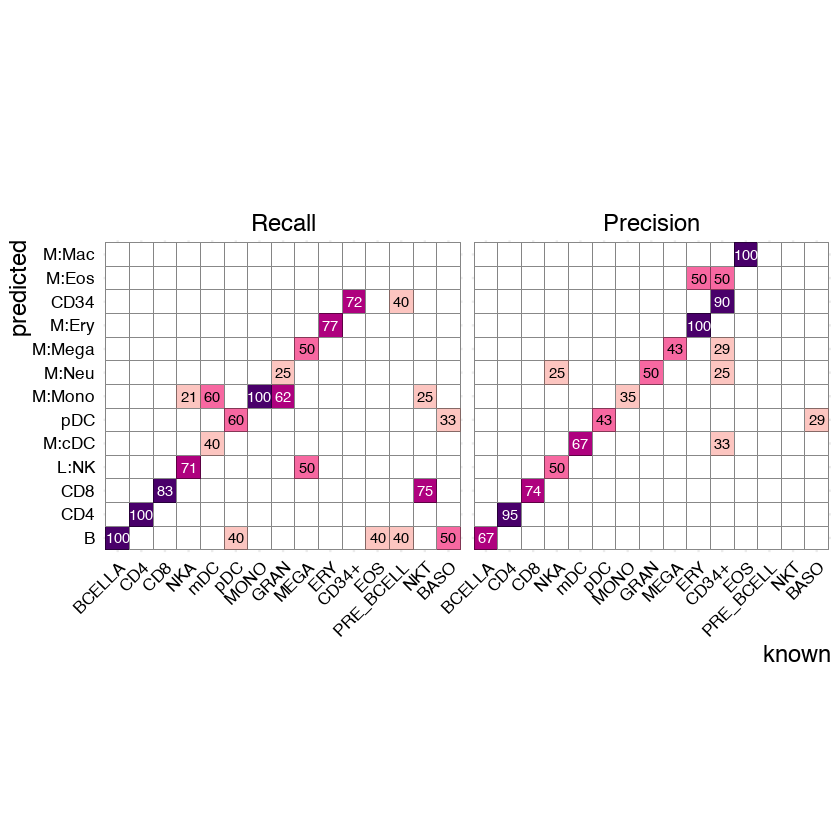

In [1251]:
library(dplyr)

library(reshape)
library(ggplot2)


data.frame(Cell=bulk.ontotree$Cell, 
           annot=bulk.ontotree$assign.labels, 
           stringsAsFactors = F) %>% 
    mutate(Cell = ifelse(grepl("NKA4", Cell), "NKT", Cell)) %>%
    mutate(Cell = ifelse(grepl("ERY1|GRAN1|PRE_BCELL2|GMP|CMP|MEP|MEGA1|HSC", Cell), "CD34+", Cell)) %>%
    mutate(Cell = ifelse(grepl("DENDA1", Cell), "pDC", Cell)) %>%
            mutate(Cell = ifelse(grepl("DENDA2", Cell), "mDC", Cell)) %>%
            mutate(Known=gsub("[0-9]*_[0-9]+$", "", Cell)) %>%
            
            
            mutate(Known = ifelse(grepl("TCELLA[1-4]", Cell), "CD8", Known)) %>%
            mutate(Known = ifelse(grepl("TCELLA[6-8]", Cell), "CD4", Known)) %>%
            mutate(annot = ifelse(grepl("CD4", annot), "CD4", annot)) %>%
            mutate(annot = ifelse(grepl("HSC", annot), "CD34", annot)) %>%
            
            mutate(annot = ifelse(grepl("CD8", annot), "CD8", annot)) %>%
            mutate(annot = ifelse(grepl("pDC", annot), "pDC", annot)) %>%
            mutate(annot = ifelse(grepl("L:B", annot), "B", annot)) %>%
           select(Known, annot) %>% table %>%
    plot_heatmap(title = "", palette= "RdPu", 
              minshow = 20, size =10, size2= 3, minpct=0, legend.pos = "none",
            ord1 = c('B', 'CD4', 'CD8', 'L:NK', 'M:cDC', 'pDC',
                     'M:Mono', 'M:Neu', 'M:Mega','M:Ery',  'CD34:HSC', 'CD34', 'M:Eos', 
                     'L','M:Mac'
                     
                    ),
            ord2 = c( 'BCELLA', 'CD4', 'CD8', 'NKA', 'mDC', 'pDC', 
                      'MONO','GRAN', 'MEGA','ERY', 'HSC', 'CD34+', 'EOS', 
                      'PRE_BCELL','NKT',  'BASO'), 
            measures = c('Recall', 'Precision')                                                    
 )

# BRCA-3p

In [637]:
brca3p.ontotree <- assign_dataset('brca3p', 'ontotree')

[1] "Read tensorflow/output/brca3p.deeplearning.ontotree.stats.txt"
[1] "Assign the final labels"
[1] "Finish assigning the final labels"


In [826]:
brca3p.meta <- readRDS('../ImmClassifier/Figures/BRCA-DP-meta.rds')
brca3p.clsnames <- readRDS('../ImmClassifier/Figures/BRCA-DP-clusternames.rds')

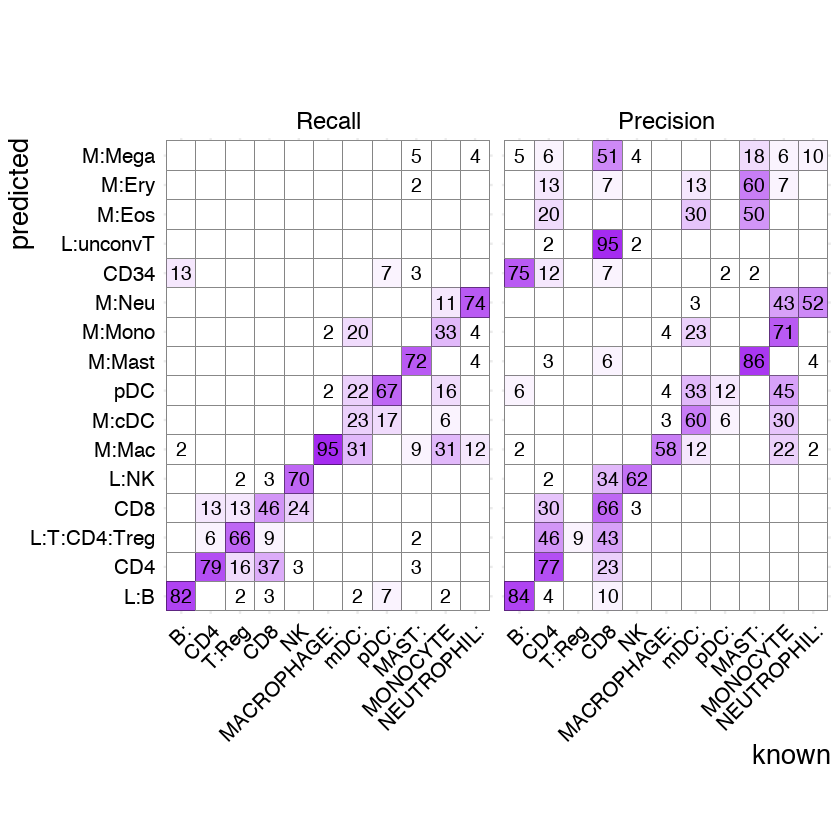

In [827]:
data.frame(Cell=brca3p.ontotree$Cell, 
           annot=brca3p.ontotree$assign.labels, stringsAsFactors = F) %>%
           mutate(Known=brca3p.clsnames[brca3p.meta[Cell, 'cluster'], 'Final_annotation']) %>%
            filter(!grepl("NKT", Known)) %>%
            #mutate(annot = ifelse(grepl("CD4", annot), "CD4", annot)) %>%
            mutate(annot = ifelse(grepl("CD4", annot)& (!grepl("Tre", annot)), "CD4", annot)) %>%
           mutate(annot = ifelse(grepl("CD8", annot), "CD8", annot)) %>%
            mutate(annot = ifelse(grepl("L:B:PC", annot), "L:B", annot)) %>%
            mutate(annot = ifelse(grepl("pDC", annot), "pDC", annot)) %>%
            mutate(annot = ifelse(grepl("CD34", annot), "CD34", annot)) %>%
            mutate(Known = ifelse(grepl("CD4", Known), "CD4", Known)) %>%
            mutate(Known = ifelse(grepl("^MONO", Known), "MONOCYTE", Known)) %>%
            mutate(Known = ifelse(grepl("^NK:", Known), "NK", Known)) %>%
            mutate(Known = ifelse(grepl("CD8", Known), "CD8", Known)) %>%
            #mutate(annot = ifelse(annot %in% c('M:Mega', 'M:Ery', 'M:Eos', 'L:unconvT', 'CD34'), "Other", annot)) %>%
            select(Known, annot) %>% table %>%
            plot_heatmap(title = "", palette= "RdPu", 
           ord1 = c( 'L:B', 'L:B:PC','CD4', 'L:T:CD4:Treg',
                    'CD8', 'L:NK',  'M:Mac',
                    'M:cDC', 'pDC', 'M:Mast', 'M:Mono', 'M:Neu' ,'CD34','L:unconvT','M:Eos', 'M:Ery' ,'M:Mega' ),
           ord2 = c('B:', 'CD4',  'T:Reg', 'CD8',  'NK', 'MACROPHAGE:', 'mDC:', 'pDC:', 'MAST:', 'MONOCYTE',
                    'NEUTROPHIL:'),
              minshow = 1, size =12, size2= 4, minpct=0, ncol = 3, measures = c('Recall', 'Precision'))



# SKCM

In [284]:

skcm.ontotree <- assign_dataset('skcm', 'ontotree')

[1] "Read tensorflow/output/skcm.deeplearning.ontotree.stats.txt"
[1] "Assign the final labels"
[1] "Finish assigning the final labels"


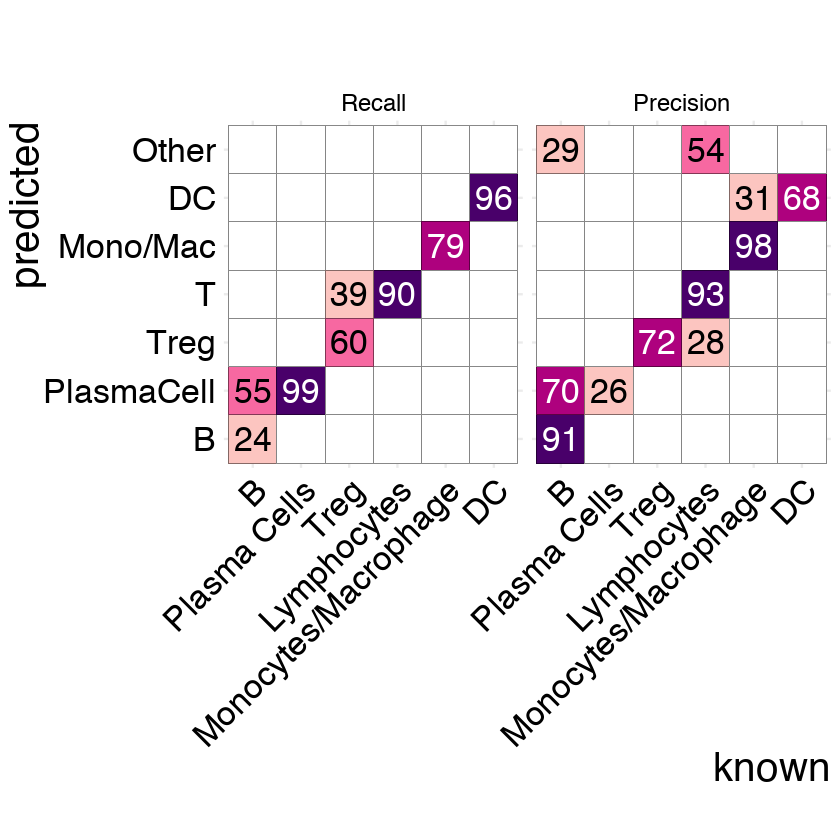

In [1255]:
skcm.meta <- readRDS("../ImmClassifier/Figures/SKCM-NH-meta.rds")
skcm.cluster.names <- readRDS("../ImmClassifier/Figures/SKCM-NH-clusternames.rds")

data.frame(Cell=skcm.ontotree$Cell, 
           annot=skcm.ontotree$assign.labels, stringsAsFactors = F) %>%
           mutate(Known= skcm.cluster.names[skcm.meta[Cell, 'Cluster'], 'clusterName']) %>%
           mutate(annot = ifelse(grepl("Mono|Mac", annot), "Mono/Mac", annot)) %>%
            mutate(annot = ifelse(grepl("PC", annot), "PlasmaCell", annot)) %>%  
           mutate(annot = ifelse(grepl("B", annot), "B", annot)) %>%  
        mutate(annot = ifelse(grepl("reg", annot), "Treg", annot)) %>%  
        mutate(annot = ifelse(grepl("T:", annot), "T", annot)) %>%  
                mutate(annot = ifelse(grepl("DC", annot) , "DC", annot)) %>%  
           mutate(annot = ifelse(grepl("DC", annot) , "DC", annot)) %>%  
            
           mutate(Known = ifelse(grepl("^T:|Lym", Known), "Lymphocytes", Known)) %>%  

            mutate(annot = ifelse(annot %in% c('Mono/Mac', 'B', 'PlasmaCell', 'DC', 'Treg', 'T') , annot, 'Other')) %>%  
          select(Known, annot) %>% table %>%
            plot_heatmap(title = "", palette= "RdPu", 
              minshow = 20, size =20, size2= 7, minpct=0, measures = c('Recall', 'Precision'),
                        ord1 = c('B', 'PlasmaCell', 'Treg',"T",'Mono/Mac', 'DC' ),
                         ord2 = c('B', 'Plasma Cells', 'Treg','Lymphocytes', 'Monocytes/Macrophage','DC')
                        )                                                      


# HCC

In [723]:

hcc.ontotree <- assign_dataset('hcc', 'ontotree')

[1] "Read tensorflow/output/hcc.deeplearning.ontotree.stats.txt"
[1] "Assign the final labels"
[1] "Finish assigning the final labels"


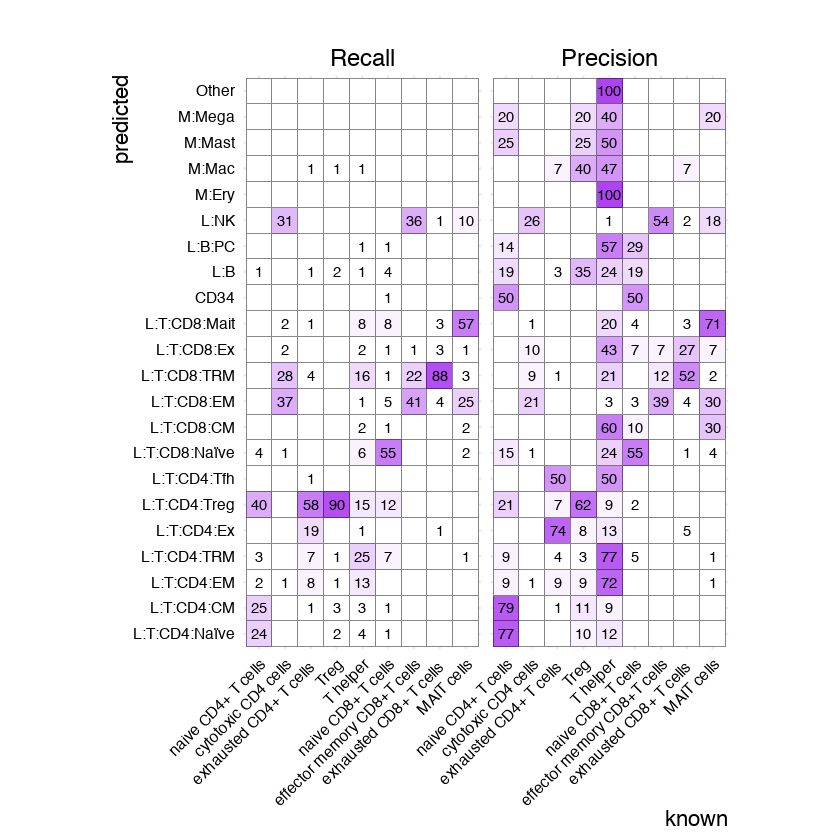

In [724]:
hcc.meta <- readRDS("../ImmClassifier/Figures/HCC-ZZ-meta.rds")
hcc.cluster.names <- readRDS("../ImmClassifier/Figures/HCC-ZZ-clusternames.rds")


data.frame(Cell=hcc.ontotree$Cell, 
           annot=hcc.ontotree$assign.labels, stringsAsFactors = F) %>%
           mutate(Known=hcc.cluster.names[hcc.meta[Cell, 'majorCluster'], 'clusterName']) %>%
            filter(!grepl("inter|known", Known)) %>%
           #  mutate(Known = ifelse(grepl("CD4", Known), "CD4", Known)) %>%
           # mutate(Known = ifelse(grepl("CD8", Known), "CD8", Known)) %>%
            mutate(Known = ifelse(grepl("reg", Known), "Treg", Known)) %>%
            #mutate(annot = ifelse(grepl("CD4", annot)& (!grepl("Treg|Tfh", annot)), "CD4", annot)) %>%
           #mutate(annot = ifelse(grepl("CD8", annot) & (!grepl("Mait", annot)), "CD8", annot)) %>%
        
            select(Known, annot) %>% table %>%
            plot_heatmap(title = "", palette= "RdPu", 
            ord1 = c('L:T:CD4:Naïve','L:T:CD4:CM', 'L:T:CD4:EM', 'L:T:CD4:TRM', 'L:T:CD4:Ex',
                     'L:T:CD4:Treg','L:T:CD4:Tfh',
                    'L:T:CD8:Naïve','L:T:CD8:CM', 'L:T:CD8:EM', 'L:T:CD8:TRM', 'L:T:CD8:Ex',
                      'L:T:CD8:Mait', 'L:unconvT',
                     'CD34', 'L:B', 'L:B:PC', 'L:NK', 
                     'L:pDC', 'M:cDC', 'M:Ery', 'M:Mono', 'M:Mac', 'M:Mast', 'M:Mega', 'M:Mega:Platelet'
                     
                    ),
            ord2=c('naive CD4+ T cells','cytotoxic CD4 cells', 'exhausted CD4+ T cells ',
                    'Treg', 'T helper',
                   'naive CD8+ T cells', 'effector memory CD8+T cells', 'intermediate of EM and Exhausted T', 
                   'exhausted CD8+ T cells ','MAIT cells',
                   'unknown'
                
                  ),
                         
              minshow = 0, size =9, size2= 3, minpct=0, measures = c('Recall', 'Precision')) 

# BRCA-5p

In [725]:
brca5p.ontotree <- assign_dataset('brca5p')
brca.5p.clusternames <- list(as.character(c(7,16,22,33)),
                                 as.character(c(5,6,9,26,30)),
                                 as.character(c(3,4)),
                                 as.character(c(2,14,20,29,34)),
                                 as.character(c(12,17,32,21)),
                                 as.character(c(10,19)),
                                 as.character(c(1,8,11,13,15,18,24,25,28,31,27)),
                                as.character(c(23)))
        
names(brca.5p.clusternames) <- c( "T:CD4+Naive", "T:CD4+CM", "T:CD4+EM", "Treg",
                                     "T:CD8+Naive", "T:CD8+CM", "T:CD8+EM",
                                    "NKT")

brca.5p.clusternames <- data.frame(clusterID = brca.5p.clusternames %>% unlist)
brca.5p.clusternames[, 'clusterName'] <- rownames(brca.5p.clusternames)
rownames(brca.5p.clusternames) <- brca.5p.clusternames$clusterID


[1] "Read tensorflow/output/brca5p.deeplearning.ontotree.stats.txt"
[1] "Assign the final labels"
[1] "Finish assigning the final labels"


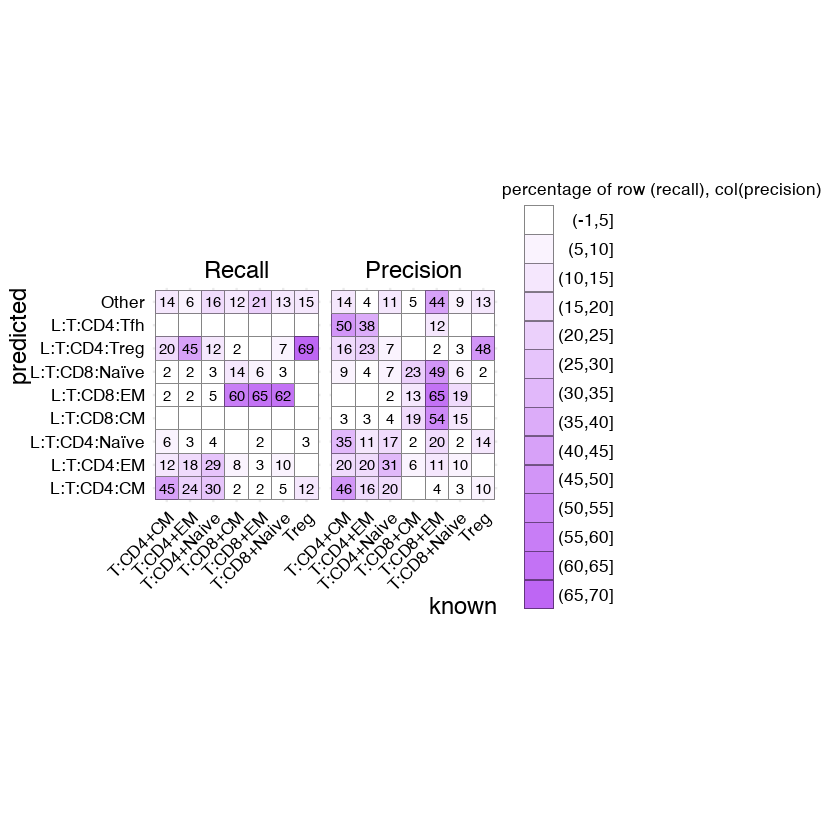

In [726]:
data.frame(Cell=brca5p.ontotree$Cell, 
           annot=brca5p.ontotree$assign.labels, stringsAsFactors = F) %>%
           mutate(Known=brca.5p.clusternames[brca3p.meta[Cell, 'cluster'], 'clusterName']) %>%
            
          # mutate(Known = ifelse(grepl("CD4", Known), "CD4", Known)) %>%
          #  mutate(Known = ifelse(grepl("CD8", Known), "CD8", Known)) %>%
          #  mutate(Known = ifelse(grepl("reg", Known), "Treg", Known)) %>%
          #  mutate(annot = ifelse(grepl("CD4", annot) & (!grepl("Treg", annot)), "CD4", annot)) %>%
          # mutate(annot = ifelse(grepl("CD8", annot), "CD8", annot)) %>%

            
           mutate(Known = gsub("[0-9]+$", "", Known)) %>%
            filter(!grepl("NKT", Known)) %>%
            #mutate(Known = gsub("CM|EM", "M", Known)) %>%
            mutate(annot = gsub("EM|Ex|TRM|Mait", "EM", annot)) %>%
            #mutate(annot = gsub("CM|EM|Ex|TRM", "M", annot)) %>%
            mutate(annot = ifelse(!grepl("CD4|CD8", annot), "Other", annot)) %>%
            
           select(Known, annot) %>% table %>%
            plot_heatmap(title = "", palette= "RdPu", 
              minshow = 1, size =10, size2=3, minpct=0, measures = c('Recall', 'Precision'),
                        legend.pos = "right",
            ord1 = c('L:T:CD4:CM', 'L:T:CD4:EM', 'L:T:CD4:TRM', 'L:T:CD4:Ex','L:T:CD4:Naïve',                    
                    'L:T:CD8:CM', 'L:T:CD8:EM', 'L:T:CD8:TRM', 'L:T:CD8:Ex','L:T:CD8:Naïve',
                      'L:T:CD8:Mait', 'L:unconvT','L:T:CD4:Treg','L:T:CD4:Tfh'
                    ))                                                      
 

# HNSCC

In [727]:

hnscc.ontotree <- assign_dataset('hnscc', 'ontotree')

[1] "Read tensorflow/output/hnscc.deeplearning.ontotree.stats.txt"
[1] "Assign the final labels"
[1] "Finish assigning the final labels"


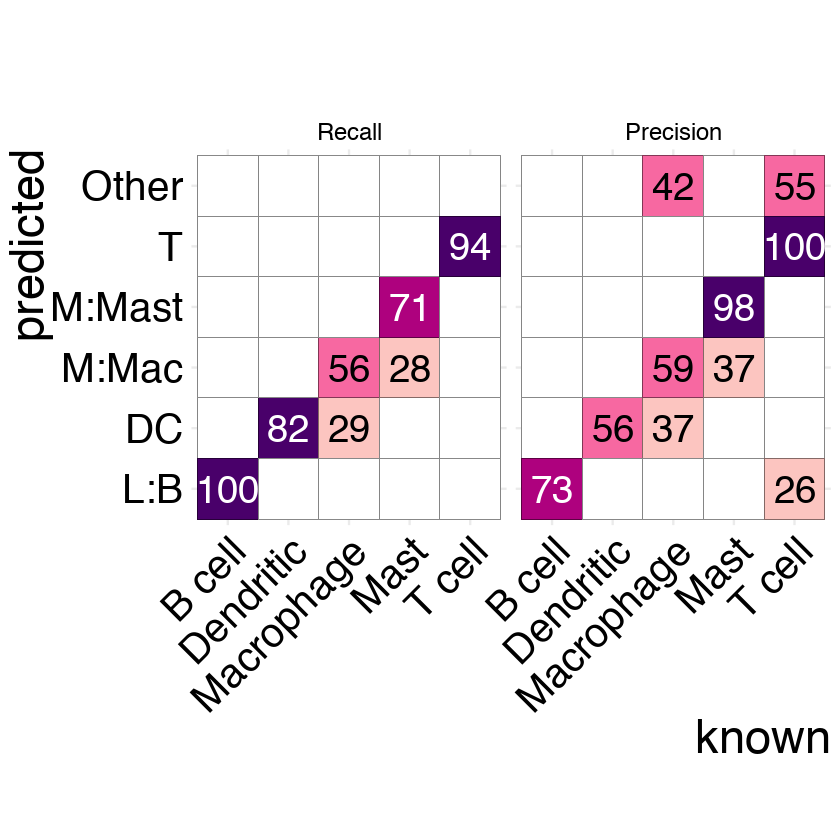

In [1268]:
hnscc.meta <- readRDS("../ImmClassifier/Figures/HNSCC.meta.rds")
data.frame(Cell=hnscc.ontotree$Cell, 
           annot=hnscc.ontotree$assign.labels, stringsAsFactors = F) %>%
           mutate(Known=hnscc.meta[Cell,'non_cancer_cell_type']) %>% 
            filter(grepl("B|Den|Ma|T", Known)) %>%
            mutate(annot=ifelse(grepl("L:T", annot), "T", annot)) %>% 
            mutate(annot=ifelse(grepl("L:unc", annot), "T", annot)) %>% 
            mutate(annot=ifelse(grepl("L:B:PC", annot), "L:B", annot)) %>% 
            mutate(annot=ifelse(grepl("DC", annot), "DC", annot)) %>% 

            mutate(annot=ifelse(annot %in% c('L:B', 'DC',  'M:Mac', 'M:Mast', 'T'),  annot, 'Other')) %>% 
            select(Known, annot) %>% table %>%
            plot_heatmap(title = "", palette= "Purples", 
              minshow = 20, size =24, size2= 8, minpct=0, measures = c('Recall', 'Precision'),
                        ord1 = c('L:B', 'DC', 'M:Mac', 'M:Mono', 'M:Mast', 'T'), legend.pos = "none")                                                      
 

# PBMC68k

In [729]:
pbmc68k.ontotree <- assign_dataset('pbmc68k')

[1] "Read tensorflow/output/pbmc68k.deeplearning.ontotree.stats.txt"
[1] "Assign the final labels"
[1] "Finish assigning the final labels"


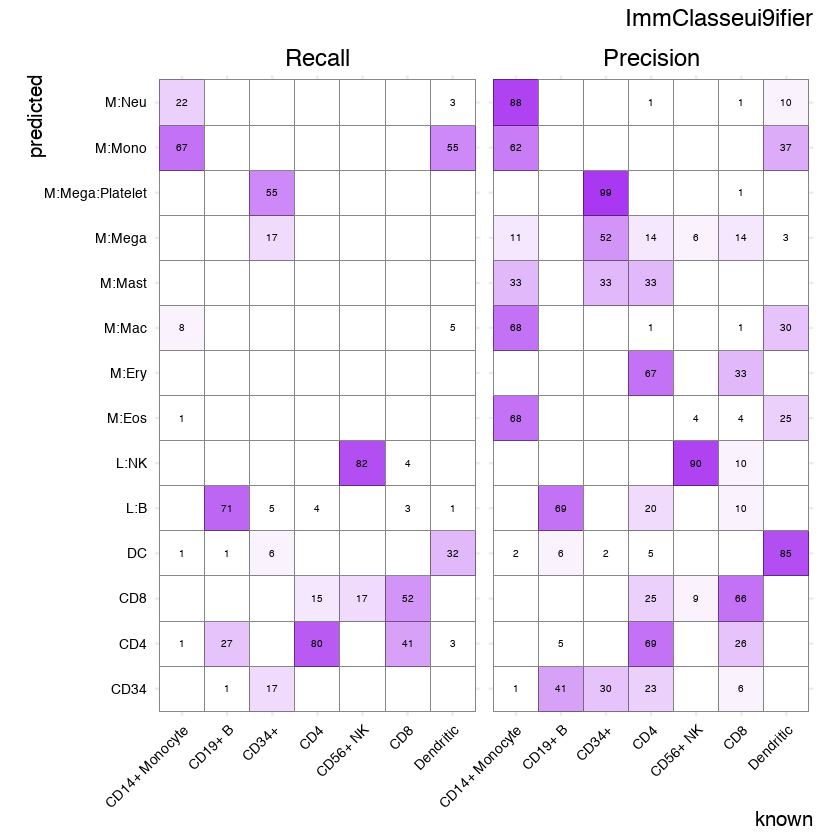

In [730]:
pbmc68k.meta <- readRDS("../ImmClassifier/Figures/pbmc68k.meta.rds")

data.frame(Cell=pbmc68k.ontotree$Cell,
           annot=pbmc68k.ontotree$ass, stringsAsFactors = F) %>%
             mutate(Known=pbmc68k.meta[Cell, 'celltype']) %>% 
            mutate(annot = ifelse(grepl("CD34", annot), "CD34", annot)) %>%
            mutate(annot = ifelse(grepl("L:B:PC", annot), "L:B", annot)) %>%
             mutate(annot = ifelse(grepl("DC", annot), "DC", annot)) %>%
            mutate(Known = ifelse(grepl("CD4", Known), "CD4", Known)) %>%
            mutate(Known = ifelse(grepl("CD8", Known), "CD8", Known)) %>%
            mutate(annot = ifelse(grepl("CD4", annot) , "CD4", annot)) %>%
           mutate(annot = ifelse(grepl("CD8", annot), "CD8", annot)) %>%
        
            select(Known, annot) %>% table %>%
            plot_heatmap(title = "ImmClasseui9ifier", palette= "RdPu", 
              minshow = 0, size =8, size2= 2, minpct=0, measures = c('Recall', 'Precision')
                        
                         )     


In [731]:
brca3p.celltype = c('B', 'CD4', 'CD8', 'Macrophage', 'Mast', 
                    'mDC', 'Monocyte', 'Neutrophil', 'NK', 'pDC', 
                    'Treg')


brca3p.ImmC.recall=c(82,79,46,95,72,
                     23,33,74,70,67,
                     66)
brca3p.ImmC.ppv=c(84,77,66,58,86,
                  60,71,52,62,12,
                  9)

brca3p.SingleR.recall=c(90, 96, 27, 76, 0,3, 97, 79,61,0, 0)                                                                                                                               
brca3p.SingleR.ppv=c(98, 71, 73, 70, 0, 18, 21, 80, 31,0, 33)

brca3p.garnett.recall <- c(94, 31, 7, 0, 0, 15, 40, 0, 50,  51, 0)
brca3p.garnett.ppv <- c(97, 70, 65, 0, 0, 29, 9, 0, 74, 12, 0)



brca5p.celltype = c('CD4N', 'CD4CM', 'CD4EM', 'CD8N', 'CD8CM', 'CD8EM', 'Treg')

brca5p.ImmC.recall=c(4, 45, 18, 3, 0, 65, 69)
brca5p.ImmC.ppv=c(17, 46, 20, 6, 19, 65, 48)

brca5p.SingleR.recall=c(6, 75, 28, 2, 0, 1, 0)         
brca5p.SingleR.ppv=c(14, 27, 8, 28, 1, 77, 100)
    
brca5p.garnett.recall = rep(NA, 7)
brca5p.garnett.ppv = rep(NA,7)


hcc.celltype = c('CD4N', 'CD4Ex', 'CD8N', 'CD8EM', 'CD8Ex', 'MAIT', 'Treg', 'Tfh')
hcc.ImmC.recall=c(24, 19, 55, 41, 3, 57, 90, 0)
hcc.ImmC.ppv=c(77, 74, 55, 39, 27, 71, 62, 50)

hcc.SingleR.recall=c(20, NA, NA, 1, NA, NA, NA, NA)
hcc.SingleR.ppv=c(66, NA, NA, 8, NA, NA, NA, NA)

hcc.garnett.recall = rep(NA, 8)
hcc.garnett.ppv = rep(NA, 8)


pbmc68k.celltype = c('B', 'CD4', 'CD8', 'CD34', 'NK', 'DC', 'Monocyte')
pbmc68k.ImmC.recall=c(71, 80, 52, 17, 82, 32, 67)
pbmc68k.ImmC.ppv=c(69, 69, 66, 30, 90, 85, 62)

pbmc68k.SingleR.recall=c(64, 98, 23, 23, 49, 0, 95)       
pbmc68k.SingleR.ppv=c(99, 60, 49, 77, 95, 100, 60)
    
pbmc68k.garnett.recall = c(65, 33, 18, 7, 51, 21,38 )
pbmc68k.garnett.ppv = c(97, 71, 47, 37, 80, 81, 73)




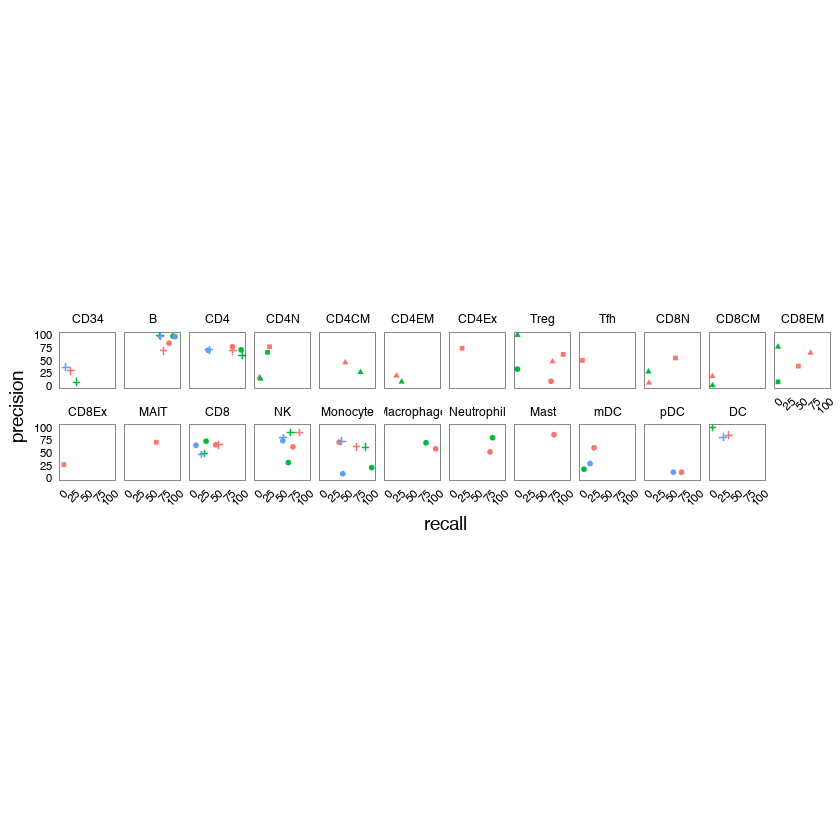

In [1400]:
library(ggrepel)
library(ggplot2)


ImmC.recall = c(brca3p.ImmC.recall, brca5p.ImmC.recall,pbmc68k.ImmC.recall,hcc.ImmC.recall)
SingleR.recall = c(brca3p.SingleR.recall, brca5p.SingleR.recall,pbmc68k.SingleR.recall,hcc.SingleR.recall)
garnett.recall = c(brca3p.garnett.recall, brca5p.garnett.recall,pbmc68k.garnett.recall,hcc.garnett.recall)


ImmC.ppv = c(brca3p.ImmC.ppv, brca5p.ImmC.ppv,pbmc68k.ImmC.ppv,hcc.ImmC.ppv)
SingleR.ppv = c(brca3p.SingleR.ppv, brca5p.SingleR.ppv,pbmc68k.SingleR.ppv,hcc.SingleR.ppv)
garnett.ppv = c(brca3p.garnett.ppv, brca5p.garnett.ppv,pbmc68k.garnett.ppv,hcc.garnett.ppv)



celltype = c(brca3p.celltype, brca5p.celltype,pbmc68k.celltype,hcc.celltype)



data.frame(
    recall = c(ImmC.recall, SingleR.recall, garnett.recall),
    precision=c(ImmC.ppv, SingleR.ppv, garnett.ppv),
    celltype = rep(celltype, 3), 
    method = c(rep('ImmC', length(ImmC.recall)),
              rep('SingleR', length(SingleR.recall)),
               rep('Garnett', length(garnett.recall))),
    
    
    dataset = c(rep('BRCA-3p', length(brca3p.ImmC.recall)), 
                rep('BRCA-5p',  length(brca5p.ImmC.recall)), 
                rep('PBMC68K-heathy', length(pbmc68k.ImmC.recall)),  
                rep('HCC', length(hcc.ImmC.recall))),
              
    stringsAsFactors = F) %>% 
    mutate(celltype = factor(celltype, 
                         levels = c(
                         'CD34' , 'B', 'CD4','CD4N', 'CD4CM', 'CD4EM', 'CD4Ex', 'Treg','Tfh' ,
                            'CD8N', 'CD8CM', 'CD8EM', 'CD8Ex', 'MAIT' , 'CD8', 'NK',
                              'Monocyte', 'Macrophage', 'Neutrophil' , 'Mast', 'mDC','pDC', 'DC')),
          method = factor(method, levels = c('ImmC', 'SingleR', 'Garnett'))
          
          ) %>%
       filter(recall>0 | precision>0) %>%
ggplot(aes(recall, precision)) + 
          geom_point(aes(color = method, shape = dataset),  size = 1)+    
            coord_equal()+
            theme_minimal() + theme(legend.pos = "none", 
                                panel.grid.major = element_blank(),
                                panel.grid.minor = element_blank(),
                                strip.text.x = element_text(size = 7, colour = "black", angle = 0),
                                panel.border = element_rect(color = "black", fill = NA, size = .1),
                                axis.text.x = element_text(angle = 45, size = 6.5, hjust = 1,color= "black"), 
                                axis.text.y = element_text(size = 6.5, hjust = 1,color = "black")
                                   ) +
            xlim(0, 100) + ylim(0, 100) +
            facet_wrap(~celltype, nrow = 2) + 
            guides(color = guide_legend(override.aes = list(size=1)))

   
   

In [805]:
load('../ImmClassifier/singleR/output//singler_brca3p.RData')
brca3p.singler <- singler
brca3p.singler.df <- data.frame(singler=brca3p.singler$singler[[1]]$SingleR.single$labels, stringsAsFactors = F)
rownames(brca3p.singler.df ) <- brca3p.singler$singler[[1]]$SingleR.single$cell.names


brca3p.garnett.extend  <- readRDS('../ImmClassifier//garnett/test/brca.3p.garnett.extend.rds')

brca3p.umap <- read.table('../ImmClassifier-LabelTransfer-DL/umap//out-brca3p_umap/models//umap.pca_0500.cluster_25.k_25.res_1.0.umap_25/coordinates.txt',
                            header = T, sep = "\t", stringsAsFactors = F)

rownames(brca3p.umap) <- brca3p.umap$Cell

brca3p.common.cells <- intersect(brca3p.ontotree$Cell, rownames(brca3p.singler.df))



In [829]:
brca3p.umap[brca3p.common.cells, c('Cell', 'UMAP1', 'UMAP2', 'Cluster')] %>% 
                    mutate( UMAP=as.character(Cluster),
                        Original = brca3p.clsnames[brca3p.meta[Cell, 'cluster'], 'Final_annotation']) %>% head

Cell,UMAP1,UMAP2,Cluster,UMAP,Original
cell_246,-2.35162600,-2.06235800,3,3,T:CD4+NAIVE
cell_260,2.81101600,-0.61033410,6,6,T:CD4+NAIVE
cell_346,0.07436639,-0.91147770,6,6,T:CD4+NAIVE
cell_188,-0.77260350,5.62368800,8,8,NK:CD56+16+3+NKT
cell_33,0.32818640,0.04454326,4,4,T:CD8+NAIVE
cell_13,1.57015100,-9.31835700,20,20,B:


In [835]:
brca3p.umap.df <- brca3p.umap[brca3p.common.cells, c('Cell', 'UMAP1', 'UMAP2', 'Cluster')] %>% 
                    mutate( UMAP=as.character(Cluster),
                        Original =  brca3p.clsnames[brca3p.meta[Cell, 'cluster'], 'Final_annotation'],
                        ImmClassifier=brca3p.ontotree$assign.labels[brca3p.ontotree$Cell %in% brca3p.common.cells],
                        SingleR = brca3p.singler.df[Cell,'singler'],
                        Garnett= brca3p.garnett.extend[Cell, 'cluster_ext_type']) 


In [836]:

# match clusters between original and unsupervised umap

original.centroids <- brca3p.umap.df %>% group_by(Original) %>% 
                    summarize(C1=mean(UMAP1),
                              C2=mean(UMAP2)) 



unsupervised.centroids <- brca3p.umap.df %>% group_by(UMAP) %>% 
                    summarize(C1=mean(UMAP1),
                              C2=mean(UMAP2)) 

matched.centroids <-  unsupervised.centroids %>%
    apply(1, function(x) original.centroids[order((original.centroids[, 'C1']-as.numeric(x[2]))^2 
                         + (original.centroids[, 'C2']-as.numeric(x[3]))^2)[1], 1] %>% unlist) 

names(matched.centroids) <- unsupervised.centroids$UMAP

In [1639]:



brca3p.umap.df2 <- brca3p.umap.df %>%
                    mutate(Original = ifelse(grepl("^NKT", Original), "NKT", Original)) %>%              
                    mutate(Original = gsub("T:Reg", "Treg", Original)) %>%
                    mutate(Original = gsub("T:CD4.*", "CD4+T", Original)) %>%
                    mutate(Original = gsub("T:CD8.*", "CD8+T", Original))%>%
                    mutate(Original = gsub(":[^:]+.*$", "", Original))%>%
                    mutate(Original = gsub(":$", "", Original))%>%

                    mutate(ImmClassifier = ifelse(grepl("B",ImmClassifier),   "B", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("NK",ImmClassifier),   "NK", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("pDC",ImmClassifier),   "pDC", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("cDC",ImmClassifier),   "mDC", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("reg",ImmClassifier),   "Treg", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("CD4",ImmClassifier),   "CD4+T", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("CD8",ImmClassifier),   "CD8+T", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("Mono",ImmClassifier),   "MONOCYTE", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("Mac",ImmClassifier),   "MACROPHAGE", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("Mast",ImmClassifier),   "MAST", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("Neu",ImmClassifier),  "NEUTROPHIL", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(!grepl("B|NK|pDC|mDC|CD4|CD8|Treg|MONO|MAC|NEU|MAST", ImmClassifier),  "Other", ImmClassifier)) %>%
                    

                    mutate(SingleR = ifelse(grepl("B_cell",SingleR),   "B", SingleR)) %>%
                    mutate(SingleR = ifelse(grepl("NK",SingleR),   "NK", SingleR)) %>%
                    mutate(SingleR = ifelse(grepl("Monocyte",SingleR),   "MONOCYTE", SingleR)) %>%
                    mutate(SingleR = ifelse(grepl("DC:m",SingleR),   "mDC", SingleR)) %>%
                    mutate(SingleR = ifelse(grepl("Macrophage",SingleR),   "MACROPHAGE", SingleR)) %>%
                    mutate(SingleR = ifelse(grepl("Treg",SingleR),   "Treg", SingleR)) %>%
                    mutate(SingleR = ifelse(grepl("T_cell:CD4\\+",SingleR),   "CD4+T", SingleR)) %>%
                    mutate(SingleR = ifelse(grepl("T_cell:CD8\\+",SingleR),   "CD8+T", SingleR)) %>%
                    mutate(SingleR = ifelse(grepl("Neutrophil",SingleR),   "NEUTROPHIL", SingleR)) %>%
                    mutate(SingleR = ifelse(!grepl("^B|^NK|^pDC|^mDC|CD4|CD8|^Treg|^MONO|^MAC|^NEU|^MAST", SingleR),  "Other", SingleR))  %>%
                    
                    mutate(Garnett = ifelse(grepl("B cells",Garnett),   "B", Garnett)) %>%
                    mutate(Garnett = ifelse(grepl("CD4 T cells",Garnett),   "CD4+T", Garnett)) %>%
                    mutate(Garnett = ifelse(grepl("CD8 T cells",Garnett),   "CD8+T", Garnett)) %>%
                    mutate(Garnett = ifelse(grepl("Den",Garnett),   "mDC", Garnett)) %>%
                    mutate(Garnett = ifelse(grepl("Mono",Garnett),   "MONOCYTE", Garnett)) %>%
                    mutate(Garnett = ifelse(grepl("NK",Garnett),   "NK", Garnett)) %>%
                    mutate(Garnett = ifelse(grepl("T cells",Garnett),   "T", Garnett)) %>%
                    mutate(Garnett = ifelse(grepl("Unknown",Garnett),   "Unassigned", Garnett)) %>%
                    mutate(Garnett = ifelse(!grepl("^B|^NK|^pDC|^mDC|^CD4|^CD8|^Treg|^MONO|^MAC|^NEU|^MAST|^T|Unassigned", Garnett),  "Other", Garnett))  #%>%
                
                   # mutate(UMAP = matched.centroids[UMAP]) %>%
                   # mutate(UMAP = ifelse(grepl("NKT", UMAP), "NKT", UMAP)) %>%              
                   # mutate(UMAP = gsub("T:Reg", "Treg", UMAP)) %>%
                   # mutate(UMAP = gsub("T:CD4\\+.*", "CD4+T", UMAP)) %>%
                   # mutate(UMAP = gsub("T:CD8\\+.*", "CD8+T", UMAP))%>%
                   # mutate(UMAP = gsub(":[^:]+.*$", "", UMAP))%>%
                   # mutate(UMAP = gsub(":$", "", UMAP))

Warning message:
“Removed 2400 rows containing missing values (geom_point).”

Warning message:
“Removed 10080 rows containing missing values (geom_point).”

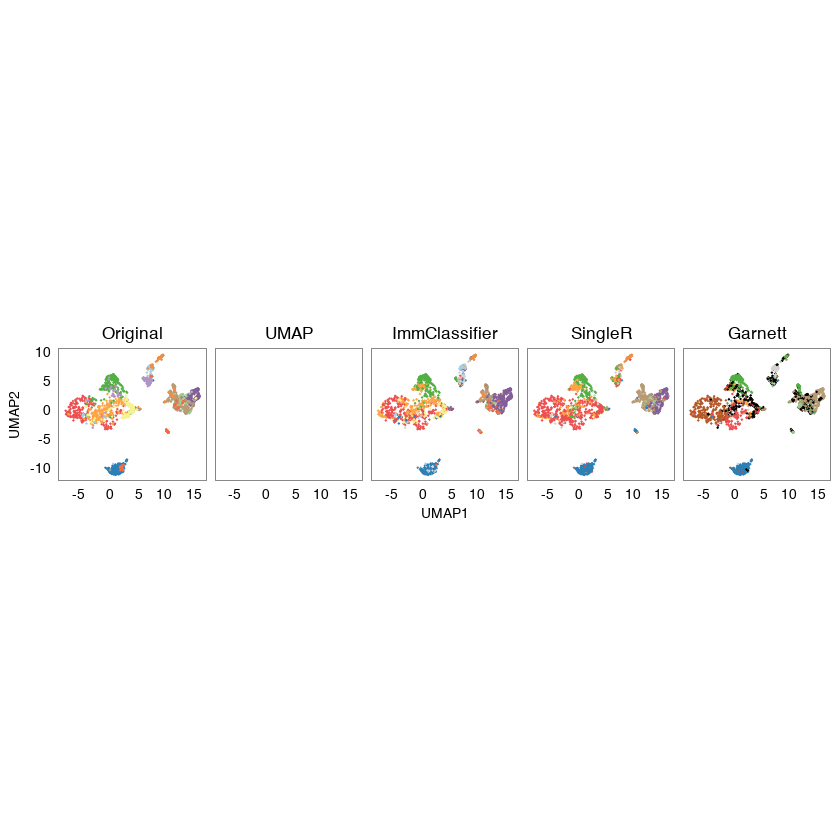

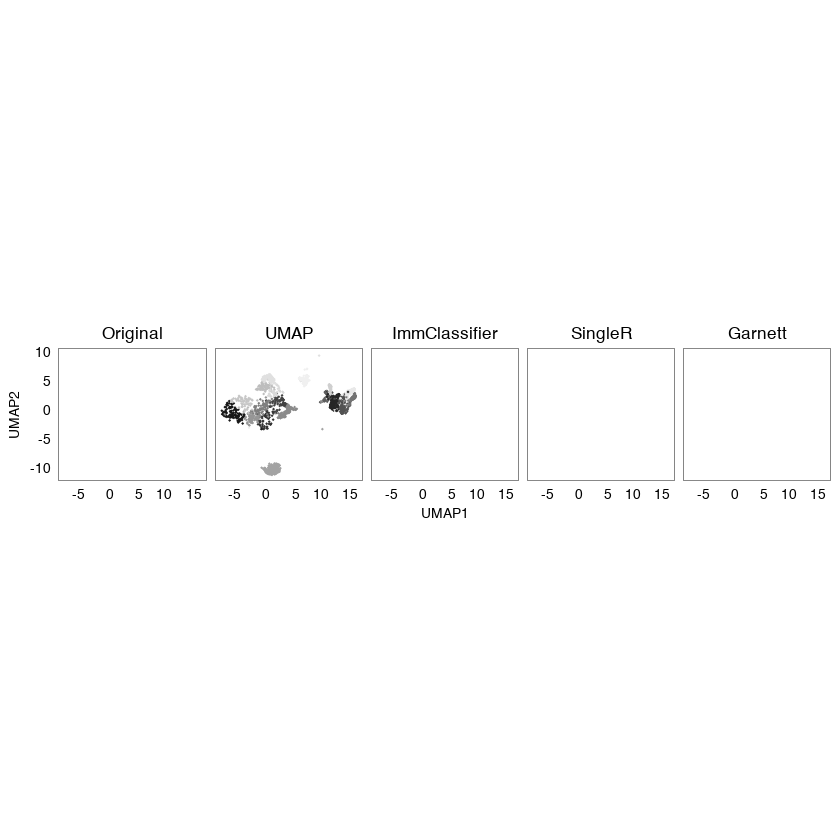

In [1640]:
library(RColorBrewer)

set.seed(100)
subsample.df <- brca3p.umap.df2 %>% 
    group_by(Original) %>% 
    sample_n(200, replace = T) %>% data.frame(stringsAsFactors = F)

subsample.df[, c(1,2,3,6,5,7,8,9)] %>% melt(id.vars = c('Cell', 'UMAP1', 'UMAP2')) %>% 
    mutate(value = factor(value, c('MAST', 'B', 'mDC', 'NK', 'MONOCYTE', 
                                   'CD4+T' ,'pDC', 'CD8+T' ,'NEUTROPHIL' ,'NKT', 
                                   'MACROPHAGE' , 'Treg' , 'T', 'Other', 'Unassigned'))) %>%
    ggplot(aes(UMAP1, UMAP2)) + 
         geom_point(aes(color = value), size = .5, pch = 18) +
          theme_minimal() + 
    theme(legend.pos = "none", 
          panel.grid.minor = element_blank(), 
          panel.grid.major = element_blank(),
          panel.border = element_rect(color = "black", fill = NA, size = .1),
          axis.text.x = element_text(angle = 0, size = 8, hjust = 1,color= "black"), 
          axis.text.y = element_text(size = 8, hjust = 1,color = "black"),
          axis.title.x = element_text(angle = 0, size = 8, hjust = .5,color= "black"), 
          axis.title.y = element_text(angle = 90, size = 8, hjust = .5,color= "black"), 
          strip.text.x = element_text(size = 10, colour = "black", angle = 0)) +
    coord_equal () + 
      #  scale_color_manual(values=wes_palette(n=13, name="Rushmore1"))  + 
    scale_color_manual(values = c(colorRampPalette(brewer.pal(12, "Paired"))(13), 'lightgrey', 'black'),
                       guide = guide_legend(nrow=5,override.aes = list(size=4))) +
    facet_wrap(~variable, ncol = 5)

subsample.df[, c(1,2,3,6,5,7,8,9)] %>% melt(id.vars = c('Cell', 'UMAP1', 'UMAP2')) %>% 
    mutate(value = factor(value, as.character(c(0:17)))) %>%
    ggplot(aes(UMAP1, UMAP2)) + 
         geom_point(aes(color = value), size = .5, pch = 18) +
          theme_minimal() + 
     theme(legend.pos = "none", 
          panel.grid.minor = element_blank(), 
          panel.grid.major = element_blank(),
          panel.border = element_rect(color = "black", fill = NA, size = .1),
          axis.text.x = element_text(angle = 0, size = 8, hjust = 1,color= "black"), 
          axis.text.y = element_text(size = 8, hjust = 1,color = "black"),
          axis.title.x = element_text(angle = 0, size = 8, hjust = .5,color= "black"), 
          axis.title.y = element_text(angle = 90, size = 8, hjust = .5,color= "black"), 
          strip.text.x = element_text(size = 10, colour = "black", angle = 0)) +
    coord_equal () + 
      #  scale_color_manual(values=wes_palette(n=13, name="Rushmore1"))  + 
    scale_color_manual(values = c(sample(colorRampPalette(brewer.pal(9, "Greys"))(25)[4:23]),18),
                       guide = guide_legend(ncol = 3, override.aes = list(size=4))) +
    facet_wrap(~variable, ncol = 5)



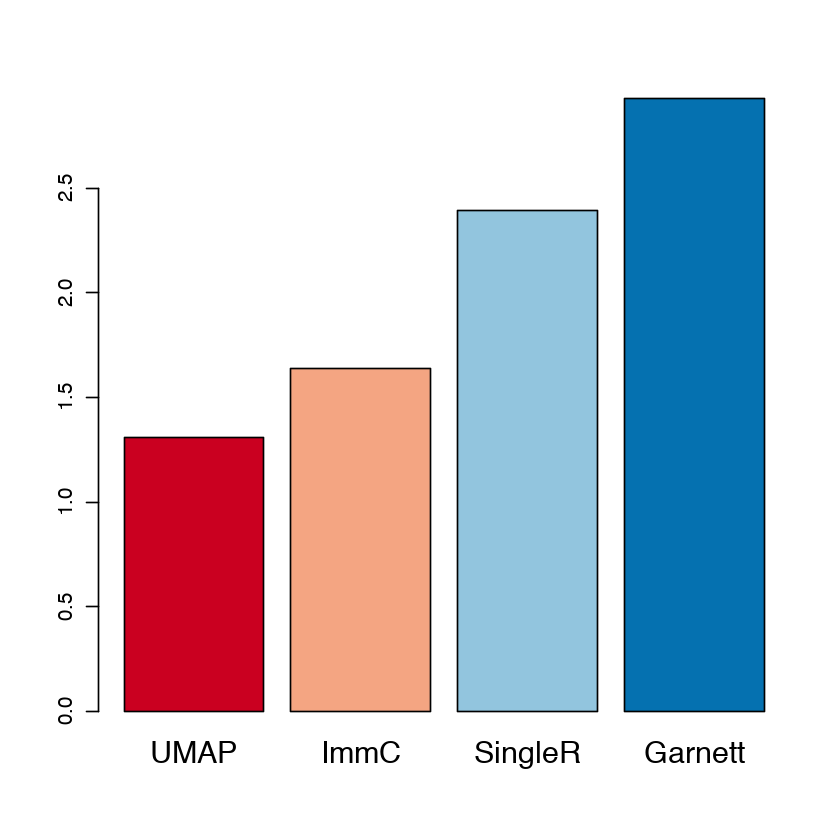

In [1598]:
x <- subsample.df[, c(6,5,7,8,9)] %>% group_by(Original) %>% 
    summarize(ImmC=sum(ImmClassifier!=Original)/n(), 
              SingleR=sum(SingleR!=Original)/n(),
              Garnett=sum(Garnett!=Original)/n(),
              UMAP=sum(UMAP!=Original)/n(),
              Origin=sum(Original!=Original)/n()
              
             ) %>% select(-1) %>% 
        #apply(2,  median) 
        apply(2, function(x) x^2) %>% apply(2, function(x) sqrt(sum(x))) %>% unlist

barplot(x[c(4,1,2,3)], col=brewer.pal(n = 4, name = 'RdBu'), cex.names= 1.5, angle = 45)

In [1458]:
 subsample.pca <- subsample.df[, c(6,5,7,8,9)] %>% group_by(Original) %>% 
    summarize(ImmC=sum(ImmClassifier==Original)/n(), 
              SingleR=sum(SingleR==Original)/n(),
              Garnett=sum(Garnett==Original)/n(),
              UMAP=sum(UMAP==Original)/n(),
              Origin=sum(Original==Original)/n()
             ) %>% select(2,3,4,5,6) %>% t %>% prcomp

subsample.pca$x %>% data.frame(stringsAsFactors = F) %>%
        mutate(method = rownames(subsample.pca$x)) %>%
        ggplot(aes(PC1, PC2)) + 
         geom_point(aes(color = method), size = 2, pch =19) +
          theme_minimal() + 
        #coord_equal() + 
        ylim(-1,1) + xlim(-2,2) +
         theme(legend.pos = "none", 
          panel.grid.minor = element_blank(), 
          panel.grid.major = element_blank(),
          panel.border = element_rect(color = "black", fill = NA, size = .1),
          axis.text.x = element_text(angle = 0, size = 12, hjust = 1,color= "black"), 
          axis.text.y = element_text(size = 12, hjust = 1,color = "black"),
          axis.title.x = element_text(angle = 0, size = 12, hjust = .5,color= "black"), 
          axis.title.y = element_text(angle = 90, size = 12, hjust = .5,color= "black")
          ) +
        geom_text(aes(label=method), nudge_y = -0.1, nudge_x= .1, size =14)  +
         geom_segment(aes(x = subsample.pca$x[5, 1], y =subsample.pca$x[5, 2], xend = PC1, yend = PC2), 
                      color = "black", arrow = arrow(length = unit(0.1, "inches")), size = .2)

,PC1,PC2,PC3,PC4,PC5
ImmC,-0.1075309,-0.53498965,0.3570398,0.28154357,-1.734723e-16
SingleR,0.7491083,-0.40772205,-0.4923352,-0.18421845,-6.106227e-16
Garnett,1.3955159,0.42503233,0.3301803,-0.09313832,8.881784e-16
UMAP,-0.5386354,0.44850110,-0.3600597,0.30419841,-5.759282e-16
Origin,-1.4984579,0.06917827,0.1651748,-0.30838521,7.424616e-16



# BRCA3P Different granularity

In [1644]:
# 20 levels

# level1: hsc, m, or l
c('CD34', 'M', 'L')

  
# level2: myeloid population, lymphoid opulation
                    (c('CD34:HSC'),
                   c('L:B', 'L:T', 'L:NK', 'L:pDC', 'L:unconvT'),
                   c('M:pDC',  'M:cDC', 'M:Eos', 'M:Ery', 'M:Mac', 'M:Mast', 'M:Mega', 'M:Mono', 'M:Neu'))  
   

# level3: t cell, broad
(c('L:B:PC'),
                    c('L:T:CD4', 'L:T:CD8'),
                    c('M:Mega:Platelet')
                   )
# level4: t cell fine types

(c('L:T:CD4:CM', 'L:T:CD4:EM', 'L:T:CD4:Ex', 'L:T:CD4:Naïve', 'L:T:CD4:Tfh', 'L:T:CD4:Treg', 'L:T:CD4:TRM'),
                    c('L:T:CD8:CM', 'L:T:CD8:EM', 'L:T:CD8:Ex', 'L:T:CD8:Mait', 'L:T:CD8:Naïve', 'L:T:CD8:TRM'))

 

$Immune_Cell
[1] "CD34" "M"    "L"

In [1660]:
brca3p.umap.df %>% count(Garnett)

Garnett,n
B cells,3577
CD34+,1048
CD4 T cells,7447
CD8 T cells,1181
Dendritic cells,670
Monocytes,3478
NK cells,4115
T cells,16405
Unknown,7306


In [1775]:
brca3p.umap.df.L1 <- brca3p.umap.df %>% 
                    filter(!grepl("NKT", Original)) %>%              
                    mutate(Original = ifelse(grepl("^M|^m|NEUTRO", Original), 'M', Original)) %>%
                    mutate(Original = ifelse(grepl("^T|NK|B|pDC", Original), 'L', Original)) %>%

                    mutate(ImmClassifier = ifelse(grepl("L:",ImmClassifier),   "L", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("M:",ImmClassifier),   "M", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("CD34",ImmClassifier),   "CD34", ImmClassifier)) %>%
                    
                    mutate(SingleR = ifelse(grepl("B_cell|T_cell|NK",SingleR),   "L", SingleR)) %>%
                    mutate(SingleR = ifelse(grepl("DC:m|Mono|Neutro|Macro",SingleR),   "M", SingleR)) %>%
                    mutate(SingleR = ifelse(SingleR %in% c('L', 'M'), SingleR, 'Other')) %>%

                    mutate(Garnett = ifelse(grepl("B cells|T cells|NK",Garnett),   "L", Garnett)) %>%
                    mutate(Garnett = ifelse(grepl("Mono|Den",Garnett),   "M", Garnett)) %>%
                    mutate(Garnett = ifelse(Garnett %in% c('L', 'M'), Garnett, 'Other'))  

brca3p.L1.celltypes <- c('L', 'M')
brca3p.ImmC.L1.recall <- c(97, 94)
brca3p.ImmC.L1.ppv <- c(99, 95)

brca3p.SingleR.L1.recall <- c(99, 92)
brca3p.SingleR.L1.ppv <- c(99, 97)

brca3p.Garnett.L1.recall <- c(87, 55)
brca3p.Garnett.L1.ppv <- c(97, 92)


brca3p.umap.df.L2 <- brca3p.umap.df %>% 
                    filter(!grepl("NKT", Original)) %>%              
                    mutate(Original = ifelse(grepl("B:", Original), 'B', Original)) %>%
                    mutate(Original = ifelse(grepl("MACROPHAGE", Original), 'Macrophage', Original)) %>%
                    mutate(Original = ifelse(grepl("MAST", Original), 'Mast', Original)) %>%
                    mutate(Original = ifelse(grepl("DC", Original), 'Dendritic', Original)) %>%
                    mutate(Original = ifelse(grepl("MONO", Original), 'Monocyte', Original)) %>%
                    mutate(Original = ifelse(grepl("NEUTR", Original), 'Neutrophil', Original)) %>%
                    mutate(Original = ifelse(grepl("NK", Original), 'NK', Original)) %>%
                    mutate(Original = ifelse(grepl("T:", Original), 'T', Original)) %>%

                    mutate(ImmClassifier = ifelse(grepl("L:T|convT",ImmClassifier),   "T", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("L:NK",ImmClassifier),   "NK", ImmClassifier)) %>%
                     mutate(ImmClassifier = ifelse(grepl("L:B",ImmClassifier),   "B", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("M:Mono",ImmClassifier),   "Monocyte", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("M:Mac",ImmClassifier),   "Macrophage", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("M:Neu",ImmClassifier),   "Neutrophil", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("M:Mast",ImmClassifier),   "Mast", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("DC",ImmClassifier),   "Dendritic", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(ImmClassifier %in% c('B','T','NK', 'Macrophage', 'Mast', 'Dendritic', 'Neutrophil', 'Monocyte'), ImmClassifier, 'Other')) %>%
                    
                    mutate(SingleR = ifelse(grepl("B_cell",SingleR),   "B", SingleR)) %>%
                    mutate(SingleR = ifelse(grepl("T_cell",SingleR),   "T", SingleR)) %>%
                    mutate(SingleR = ifelse(grepl("NK",SingleR),   "NK", SingleR)) %>%
                    mutate(SingleR = ifelse(grepl("DC",SingleR),   "Dendritic", SingleR)) %>%
                    mutate(SingleR = ifelse(grepl("Monocyte",SingleR),   "Monocyte", SingleR)) %>%
                    mutate(SingleR = ifelse(grepl("Macrophage",SingleR),   "Macrophage", SingleR)) %>%
                    mutate(SingleR = ifelse(grepl("Mast",SingleR),   "Mast", SingleR)) %>%
                        mutate(SingleR = ifelse(grepl("Neutrophil",SingleR),   "Neutrophil", SingleR)) %>%
                    mutate(SingleR = ifelse(SingleR %in% c('B','T','NK', 'Macrophage', 'Mast', 'Dendritic', 'Neutrophil', 'Monocyte'), SingleR, 'Other')) %>%

                    mutate(Garnett = ifelse(grepl("B cells",Garnett),   "B", Garnett)) %>%
                    mutate(Garnett = ifelse(grepl("T cells",Garnett),   "T", Garnett)) %>%
                    mutate(Garnett = ifelse(grepl("NK",Garnett),   "NK", Garnett)) %>%
                    mutate(Garnett = ifelse(grepl("Mono",Garnett),   "Monocyte", Garnett)) %>%
                    mutate(Garnett = ifelse(grepl("Dend",Garnett),   "Dendritic", Garnett)) %>%

                    mutate(Garnett = ifelse(Garnett %in% c('B','T','NK', 'Macrophage', 'Mast', 'Dendritic', 'Neutrophil', 'Monocyte'), Garnett, 'Other'))  


brca3p.L2.celltypes <- c('B', 'T', 'NK', 'Dendritic', 'Monocyte', 'Macrophage', 'Neutrophil', 'Mast')




brca3p.ImmC.L2.recall <- c(81,97,70,50,33,95,75,73)
brca3p.ImmC.L2.ppv <- c(89,99,64,53,70,59,52,88)

brca3p.SingleR.L2.recall <- c(91,96,61,3,72,76,79,NA)
brca3p.SingleR.L2.ppv <- c(95,97,31,22,50, 70,80,NA)

brca3p.Garnett.L2.recall <- c(94, 86,52,19,42,NA,NA,NA)
brca3p.Garnett.L2.ppv <- c(97,99,35, 50,29,NA,NA,NA)




brca3p.umap.df.L2 %>% mutate(Known = Original, annot = Garnett) %>%
            select(Known, annot) %>% table %>%
            plot_heatmap(title = "", palette= "RdPu", 
           
              minshow = 1, size =12, size2= 4, minpct=0, ncol = 3, measures = c('Recall', 'Precision'))


brca3p.umap.df.L3 <- brca3p.umap.df %>% 
                    filter(!grepl("NKT", Original)) %>%              
                    mutate(Original = ifelse(grepl("mDC", Original), 'mDC', Original)) %>%
                    mutate(Original = ifelse(grepl("pDC", Original), 'pDC', Original)) %>%
                    mutate(Original = ifelse(grepl("CD4|Treg", Original), 'CD4+ T', Original)) %>%
                    mutate(Original = ifelse(grepl("CD8", Original), 'CD8+ T', Original)) %>%
                    mutate(Original = ifelse(Original %in% c('CD4+ T', 'CD8+ T', 'mDC', 'pDC'), Original, 'Other')) %>%
                    
                    mutate(ImmClassifier = ifelse(grepl("L:T:CD4",ImmClassifier),   "CD4+ T", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("L:T:CD8",ImmClassifier),   "CD8+ T", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("cDC",ImmClassifier),   "mDC", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("pDC",ImmClassifier),   "pDC", ImmClassifier)) %>%
                
                    mutate(ImmClassifier = ifelse(ImmClassifier %in% c('CD4+ T', 'CD8+ T', 'mDC', 'pDC'), ImmClassifier, 'Other')) %>%
                    
                    
                    mutate(SingleR = ifelse(grepl("T_cell:CD4",SingleR),   "CD4+ T", SingleR)) %>%
                     mutate(SingleR = ifelse(grepl("T_cell:CD8",SingleR),   "CD8+ T", SingleR)) %>%
                    mutate(SingleR = ifelse(grepl("DC:mono",SingleR),   "mDC", SingleR)) %>%
                    mutate(SingleR = ifelse(grepl("DC:pl",SingleR),   "pDC", SingleR)) %>%
                    mutate(SingleR = ifelse(SingleR %in% c('CD4+ T', 'CD8+ T', 'mDC', 'pDC'), SingleR, 'Other')) %>%

                    mutate(Garnett = ifelse(grepl("CD4",Garnett),   "CD4+ T", Garnett)) %>%
                    mutate(Garnett = ifelse(grepl("CD8",Garnett),   "CD8+ T", Garnett)) %>%
                
                    mutate(Garnett = ifelse(Garnett %in% c('CD4+ T', 'CD8+ T', 'mDC', 'pDC'), Garnett, 'Other'))  





brca3p.L3.celltypes <- c('CD4', 'CD8', 'mDC', 'pDC' )




brca3p.ImmC.L3.recall <- c(85,49,24,67)
brca3p.ImmC.L3.ppv <- c(76,65,60,13)

brca3p.SingleR.L3.recall <- c(96,27,3,NA)
brca3p.SingleR.L3.ppv <- c(71,73,18,NA)

brca3p.Garnett.L3.recall <- c(31,8,NA,NA)
brca3p.Garnett.L3.ppv <- c(73,94,NA,NA)




brca3p.umap.df.L3 %>% mutate(Known = Original, annot = Garnett) %>%
            select(Known, annot) %>% table %>%
            plot_heatmap(title = "", palette= "RdPu", 
           
              minshow = 1, size =12, size2= 4, minpct=0, ncol = 3, measures = c('Recall', 'Precision'))


brca3p.umap.df.L4 <- brca3p.umap.df %>% 
                    filter(!grepl("NKT", Original)) %>%              
                    mutate(Original = ifelse(grepl("CD4\\+CM", Original), 'CD4+ TCM', Original)) %>%
                    mutate(Original = ifelse(grepl("CD4\\+NAIVE", Original), 'CD4+ TNaive', Original)) %>%
                    mutate(Original = ifelse(grepl("CD4\\+EM", Original), 'CD4+ TEM', Original)) %>%
                    mutate(Original = ifelse(grepl("CD8\\+CM", Original), 'CD8+ TCM', Original)) %>%
                    mutate(Original = ifelse(grepl("CD8\\+NAIVE", Original), 'CD8+ TNaive', Original)) %>%
                    mutate(Original = ifelse(grepl("CD8\\+EM", Original), 'CD8+ TEM', Original)) %>%
                    mutate(Original = ifelse(grepl("T:reg", Original), 'Treg', Original)) %>%
                    mutate(Original = ifelse(Original %in% c( "CD4+ TCM","CD4+ TNaive", "CD4+ TEM",
                                                                      "Treg", "CD8+ TCM","CD8+ TNaive", "CD8+ TEM"), Original, 'Other')) %>%
                    

                    mutate(ImmClassifier = ifelse(grepl("L:T:CD4:CM",ImmClassifier),   "CD4+ TCM", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("L:T:CD4:Naïve",ImmClassifier),   "CD4+ TNaive", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("L:T:CD4:EM",ImmClassifier),   "CD4+ TEM", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("L:T:CD4:Treg",ImmClassifier),   "Treg", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("L:T:CD8:CM",ImmClassifier),   "CD8+ TCM", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("L:T:CD8:Naïve",ImmClassifier),   "CD8+ TNaive", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("L:T:CD8:EM",ImmClassifier),   "CD8+ TEM", ImmClassifier)) %>%
                    
                
                    mutate(ImmClassifier = ifelse(ImmClassifier %in% c( "CD4+ TCM","CD4+ TNaive", "CD4+ TEM",
                                                                      "Treg", "CD8+ TCM","CD8+ TNaive", "CD8+ TEM"), ImmClassifier, 'Other')) %>%
                    
                    
                    mutate(SingleR = ifelse(grepl("T_cell:CD4\\+_central_memory",SingleR),   "CD4+ TCM", SingleR)) %>%
                     mutate(SingleR = ifelse(grepl("T_cell:CD4\\+_effector_memory",SingleR),   "CD4+ TEM", SingleR)) %>%
                    mutate(SingleR = ifelse(grepl("T_cell:CD4\\+_Naive",SingleR),   "CD4+ TNaive", SingleR)) %>%
                    mutate(SingleR = ifelse(grepl("T_cell:CD8\\+_naive",SingleR),   "CD8+ TNaive", SingleR)) %>%
                    mutate(SingleR = ifelse(grepl("T_cell:CD8\\+_Central_memory",SingleR),   "CD8+ TCM", SingleR)) %>%
                    mutate(SingleR = ifelse(grepl("T_cell:CD8\\+_effector_memory",SingleR),   "CD8+ TEM", SingleR)) %>%
                    mutate(SingleR = ifelse(grepl("Treg",SingleR),   "Treg", SingleR)) %>%


                    mutate(SingleR = ifelse(SingleR %in% c("CD4+ TCM","CD4+ TNaive", "CD4+ TEM",
                                                           "Treg", "CD8+ TCM","CD8+ TNaive", "CD8+ TEM"), SingleR, 'Other')) %>%

                    mutate(Garnett = ifelse(grepl("CD4",Garnett),   "CD4+ T", Garnett)) %>%
                    mutate(Garnett = ifelse(grepl("CD8",Garnett),   "CD8+ T", Garnett)) %>%
                
                    mutate(Garnett = ifelse(Garnett %in% c("CD4+ TCM","CD4+ TNaive", "CD4+ TEM",
                                                                      "Treg", "CD8+ TCM","CD8+ TNaive", "CD8+ TEM"), Garnett, 'Other'))  





brca3p.L4.celltypes <- c('CD4+ TNaive', 'CD4+ TCM','CD4+ TEM','CD8+ TNaive', 'CD8+ TCM', 'CD8+ TEM', 'Treg' )




brca3p.ImmC.L4.recall <- c(37,14,14,8, 2, 25,2)
brca3p.ImmC.L4.ppv <- c(90,3, NA, 27,NA, 24,11)

brca3p.SingleR.L4.recall <- c(41,52,44,4,8,2,NA)
brca3p.SingleR.L4.ppv <- c(98,8,1,67,1,16,33)

brca3p.Garnett.L4.recall <- rep(NA, 7)
brca3p.Garnett.L4.ppv <- rep(NA, 7)




brca3p.umap.df.L4 %>% mutate(Known = Original, annot = SingleR) %>%
            select(Known, annot) %>% table %>%
            plot_heatmap(title = "", palette= "RdPu", 
           
              minshow = 0, size =12, size2= 4, minpct=0, ncol = 3, measures = c('Recall', 'Precision'))



celltype,recall,precision,method,level
L,97,99,ImmClassifier,1
M,94,95,SingleR,1
L,99,99,Garnett,1
M,92,95,ImmClassifier,1
L,87,99,SingleR,1
M,55,95,Garnett,1
B,81,89,ImmClassifier,2
T,97,99,SingleR,2
NK,70,64,Garnett,2
Dendritic,50,53,ImmClassifier,2


# BRCA5p UMAP

In [847]:
load('../ImmClassifier/singleR/output//singler_brca5p.RData')
brca5p.singler <- singler
brca5p.singler.df <- data.frame(singler=brca5p.singler$singler[[1]]$SingleR.single$labels, stringsAsFactors = F)
rownames(brca5p.singler.df ) <- brca5p.singler$singler[[1]]$SingleR.single$cell.names


brca5p.garnett.extend  <- readRDS('../ImmClassifier//garnett/test/brca.5p.garnett.extend.rds')

brca5p.umap <- read.table('../ImmClassifier-LabelTransfer-DL/umap//out-brca5p_umap/models//umap.pca_0500.cluster_25.k_25.res_1.0.umap_25/coordinates.txt',
                            header = T, sep = "\t", stringsAsFactors = F)

rownames(brca5p.umap) <- brca5p.umap$Cell

brca5p.common.cells <- intersect(brca5p.ontotree$Cell, rownames(brca5p.singler.df))



In [931]:
brca5p.umap.df <- brca5p.umap[brca5p.common.cells, c('Cell', 'UMAP1', 'UMAP2', 'Cluster')] %>% 
                    mutate( UMAP=as.character(Cluster),
                        Original =brca.5p.clusternames[brca3p.meta[Cell, 'cluster'], 'clusterName'],
                        ImmClassifier=brca5p.ontotree$assign.labels[brca5p.ontotree$Cell %in% brca5p.common.cells],
                        SingleR = brca5p.singler.df[Cell,'singler'],
                        Garnett= brca5p.garnett.extend[Cell, 'cluster_ext_type']) 



# match clusters between original and unsupervised umap

original.centroids <- brca5p.umap.df %>% group_by(Original) %>% 
                    summarize(C1=mean(UMAP1),
                              C2=mean(UMAP2)) 


unsupervised.centroids <- brca5p.umap.df %>% group_by(UMAP) %>% 
                    summarize(C1=mean(UMAP1),
                              C2=mean(UMAP2)) 

matched.centroids <-  unsupervised.centroids %>%
    apply(1, function(x) original.centroids[order((original.centroids[, 'C1']-as.numeric(x[2]))^2 
                         + (original.centroids[, 'C2']-as.numeric(x[3]))^2)[1], 1] %>% unlist) 

names(matched.centroids) <- unsupervised.centroids$UMAP

In [932]:
brca5p.umap.df2 <- brca5p.umap.df %>%
                    mutate(Original = gsub("[0-9]+$", "", Original)) %>%              
                   
                    mutate(ImmClassifier = ifelse(grepl("L:T:CD4:CM",ImmClassifier),   "T:CD4+CM", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("L:T:CD4:EM",ImmClassifier),   "T:CD4+EM", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("L:T:CD4:Naïve",ImmClassifier),   "T:CD4+Naive", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("L:T:CD8:CM",ImmClassifier),   "T:CD8+CM", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("L:T:CD8:EM",ImmClassifier),   "T:CD8+EM", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("Ex",ImmClassifier),   "Exhausted T", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("TRM",ImmClassifier),   "Tissue-resident memory", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("L:T:CD8:Naïve",ImmClassifier),   "T:CD8+Naive", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("Treg",ImmClassifier),  "Treg", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(!grepl("\\+CM|\\+EM|Exhausted T|Tissue-resident memory|\\+Naive|Treg|NKT", ImmClassifier),  "Other", ImmClassifier)) %>%
                    

                    mutate(SingleR = ifelse(grepl("T_cell:CD4\\+_central_memory",SingleR),"T:CD4+CM", SingleR)) %>%
                    mutate(SingleR = ifelse(grepl("T_cell:CD4\\+_effector_memory",SingleR),   "T:CD4+EM", SingleR)) %>%
                    mutate(SingleR = ifelse(grepl("T_cell:CD4\\+_Naive|T_cell:CD4\\+_naive",SingleR),   "T:CD4+Naive", SingleR)) %>%
                    mutate(SingleR = ifelse(grepl("T_cell:CD8\\+_Central_memory",SingleR),   "T:CD8+CM", SingleR)) %>%
                    mutate(SingleR = ifelse(grepl("T_cell:CD8\\+_effector_memory",SingleR),   "T:CD8+EM", SingleR)) %>%
                    mutate(SingleR = ifelse(grepl("T_cell:CD8\\+_naive",SingleR),   "T:CD8+Naive", SingleR)) %>%
                    mutate(SingleR = ifelse(grepl("T_cell:Treg",SingleR),   "Treg", SingleR)) %>%
                    mutate(SingleR = ifelse(!grepl("\\+CM|\\+EM|\\+Naive|Treg|NKT", SingleR),  "Other", SingleR))  %>%
                    
                    
                    mutate(Garnett = ifelse(grepl("CD4 T cells",Garnett),   "CD4+T", Garnett)) %>%
                    mutate(Garnett = ifelse(grepl("CD8 T cells",Garnett),   "CD8+T", Garnett)) %>%
                    mutate(Garnett = ifelse(grepl("T cells",Garnett),   "T", Garnett)) %>%
                    mutate(Garnett = ifelse(grepl("Unknown",Garnett),   "Unassigned", Garnett)) %>%
                    mutate(Garnett = ifelse(!grepl("T|Unassigned", Garnett),  "Other", Garnett))  %>%
                    
                    mutate(UMAP = matched.centroids[UMAP]) %>%
                    mutate(UMAP = gsub("[0-9]+$", "", UMAP)) 

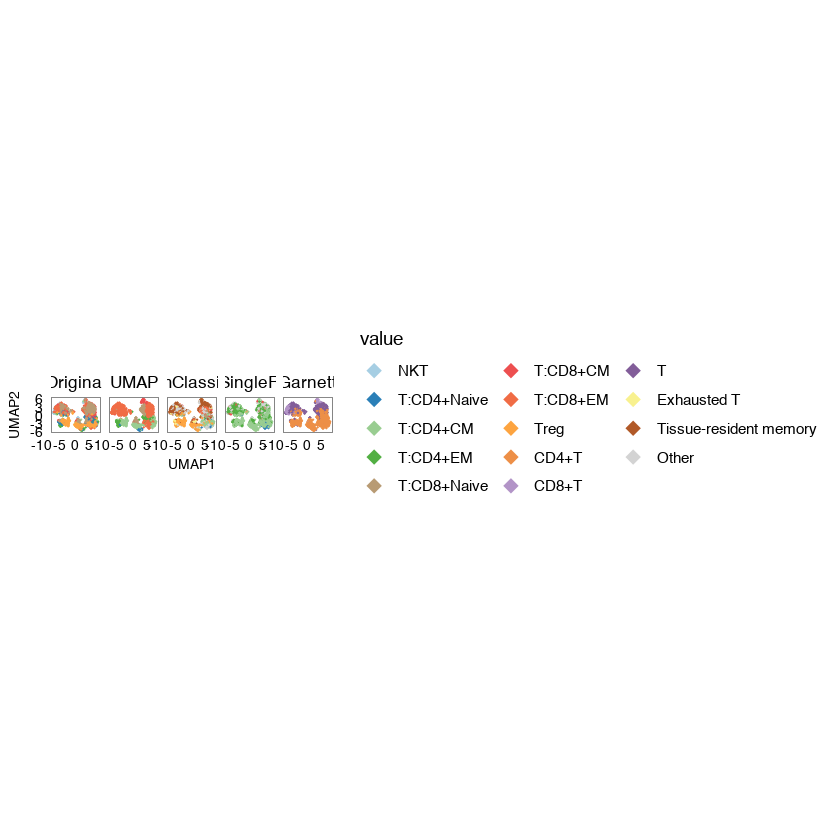

In [1599]:
library(RColorBrewer)
library(wesanderson)
set.seed(100)
subsample.df <- brca5p.umap.df2 %>% 
    group_by(Original) %>% 
    sample_n(200, replace = T) %>% data.frame(stringsAsFactors = F)

subsample.df[, c(1,2,3,6,5,7,8,9)] %>% melt(id.vars = c('Cell', 'UMAP1', 'UMAP2')) %>% 
    mutate(value = factor(value, c('NKT', 'T:CD4+Naive', 'T:CD4+CM',
                                   'T:CD4+EM', 'T:CD8+Naive', 'T:CD8+CM',
                                   'T:CD8+EM','Treg',  'CD4+T', 
                                   'CD8+T', 'T', 'Exhausted T',
                                   'Tissue-resident memory','Other', 'Unassigned'))) %>%
    ggplot(aes(UMAP1, UMAP2)) + 
         geom_point(aes(color = value), size = .5, pch = 18) +
          theme_minimal() + 
     theme(legend.pos = "right", 
          panel.grid.minor = element_blank(), 
          panel.grid.major = element_blank(),
          panel.border = element_rect(color = "black", fill = NA, size = .1),
          axis.text.x = element_text(angle = 0, size = 8, hjust = 1,color= "black"), 
          axis.text.y = element_text(size = 8, hjust = 1,color = "black"),
          axis.title.x = element_text(angle = 0, size = 8, hjust = .5,color= "black"), 
          axis.title.y = element_text(angle = 90, size = 8, hjust = .5,color= "black"), 
          strip.text.x = element_text(size = 10, colour = "black", angle = 0)) +
    coord_equal () + 
      #  scale_color_manual(values=wes_palette(n=13, name="Rushmore1"))  + 
    scale_color_manual(values = c(colorRampPalette(brewer.pal(12, "Paired"))(13), 'lightgrey', 'black'),
                       guide = guide_legend(nrow=5,override.aes = list(size=4))) +
    facet_wrap(~variable, ncol = 5)



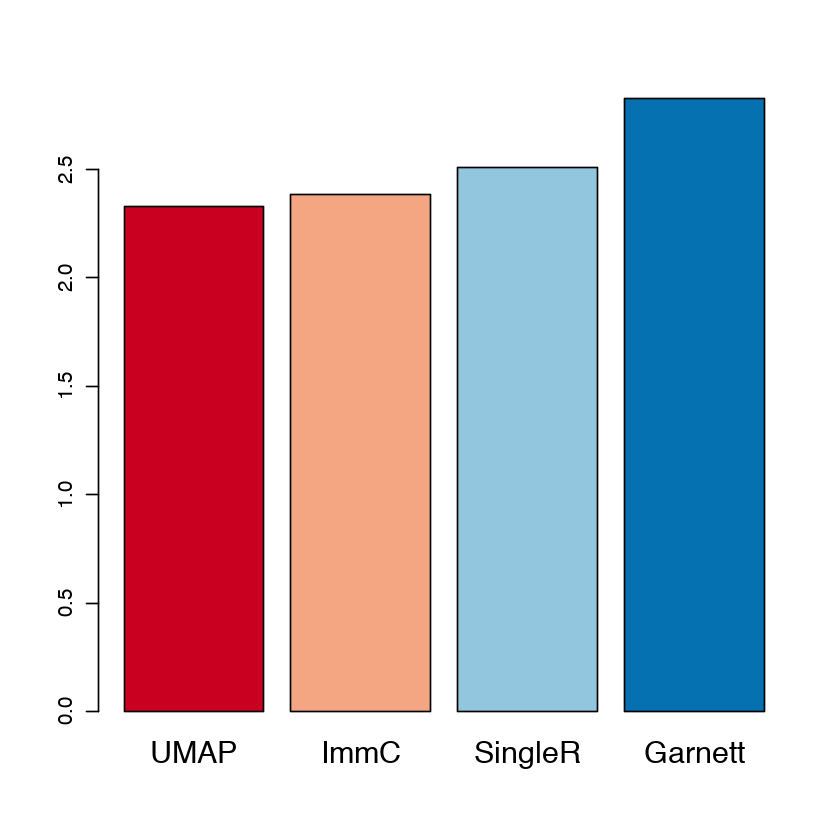

In [1600]:
x <- subsample.df[, c(6,5,7,8,9)] %>% group_by(Original) %>% 
    summarize(ImmC=sum(ImmClassifier!=Original)/n(), 
              SingleR=sum(SingleR!=Original)/n(),
              Garnett=sum(Garnett!=Original)/n(),
              UMAP=sum(UMAP!=Original)/n(),
              Origin=sum(Original!=Original)/n()
              
             ) %>% select(-1) %>% 
        #apply(2,  median) 
        apply(2, function(x) x^2) %>% apply(2, function(x) sqrt(sum(x))) %>% unlist

barplot(x[c(4,1,2,3)], col=brewer.pal(n = 4, name = 'RdBu'), cex.names= 1.5, angle = 45)

In [1789]:
brca5p.umap.df  %>% count(gsub("[0-9]+$", "", Original))

"gsub(""[0-9]+$"", """", Original)",n
NKT,582
T:CD4+CM,4455
T:CD4+EM,2811
T:CD4+Naive,2855
T:CD8+CM,1887
T:CD8+EM,8941
T:CD8+Naive,2753
Treg,3727


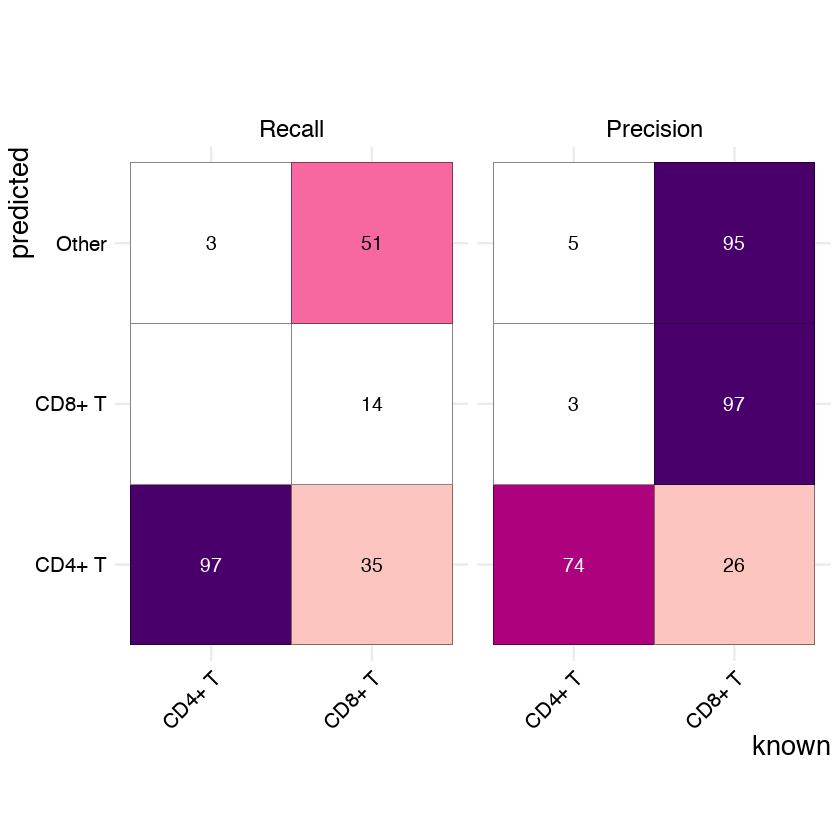

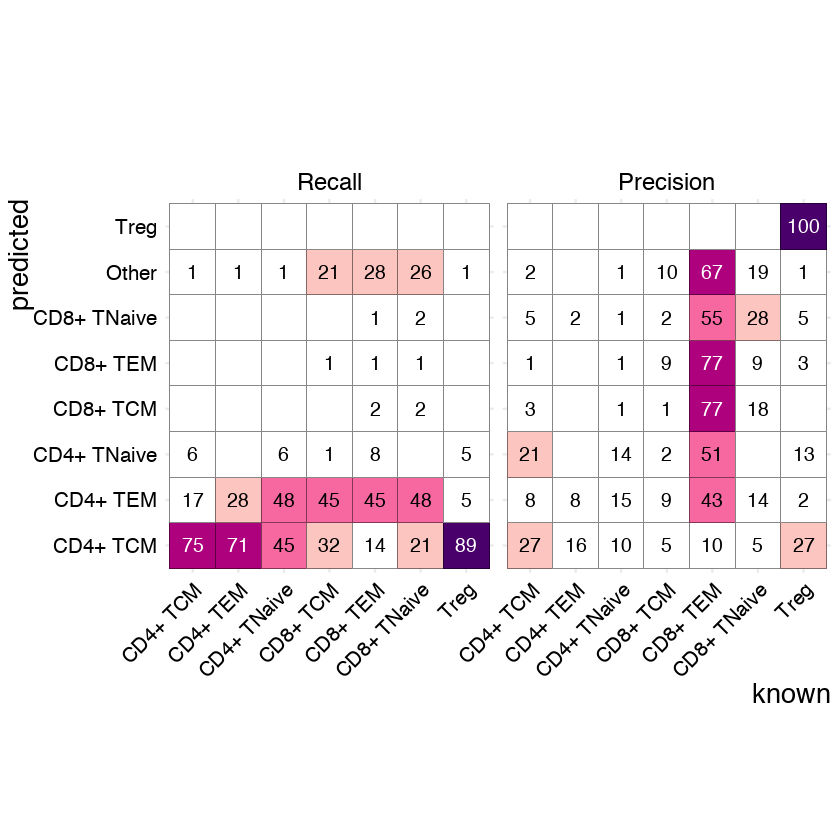

In [1810]:



brca5p.umap.df.L3 <- brca5p.umap.df %>% 
                    filter(!grepl("NKT", Original)) %>%              
                    mutate(Original = ifelse(grepl("T:CD4|Treg", Original), 'CD4+ T', Original)) %>%
                    mutate(Original = ifelse(grepl("T:CD8", Original), 'CD8+ T', Original)) %>%
                    mutate(Original = ifelse(Original %in% c("CD4+ T", "CD8+ T"), Original, 'Other')) %>%
                    
                    mutate(ImmClassifier = ifelse(grepl("L:T:CD4",ImmClassifier),   "CD4+ T", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("L:T:CD8",ImmClassifier),   "CD8+ T", ImmClassifier)) %>%
                   
                    mutate(ImmClassifier = ifelse(ImmClassifier %in% c('CD4+ T', 'CD8+ T'), ImmClassifier, 'Other')) %>%
                    
                    
                    mutate(SingleR = ifelse(grepl("T_cell:CD4",SingleR),   "CD4+ T", SingleR)) %>%
                    mutate(SingleR = ifelse(grepl("T_cell:CD8",SingleR),   "CD8+ T", SingleR)) %>%
                    
                    mutate(SingleR = ifelse(SingleR %in% c('CD4+ T', 'CD8+ T'), SingleR, 'Other')) %>%

                    mutate(Garnett = ifelse(grepl("CD4",Garnett),   "CD4+ T", Garnett)) %>%
                    mutate(Garnett = ifelse(grepl("CD8",Garnett),   "CD8+ T", Garnett)) %>%
                
                    mutate(Garnett = ifelse(Garnett %in% c('CD4+ T', 'CD8+ T'), Garnett, 'Other'))  





brca5p.L3.celltypes <- c('CD4', 'CD8')




brca5p.ImmC.L3.recall <- c(83,71)
brca5p.ImmC.L3.ppv <- c(88,94)

brca5p.SingleR.L3.recall <- c(99, 29)
brca5p.SingleR.L3.ppv <- c(59,98)

brca5p.Garnett.L3.recall <- c(97,14)
brca5p.Garnett.L3.ppv <- c(74,97)




brca5p.umap.df.L3 %>% mutate(Known = Original, annot = Garnett) %>%
            select(Known, annot) %>% table %>%
            plot_heatmap(title = "", palette= "RdPu", 
           
              minshow = 1, size =12, size2= 4, minpct=0, ncol = 3, measures = c('Recall', 'Precision'))


brca5p.umap.df.L4 <- brca5p.umap.df %>% 
                    filter(!grepl("NKT", Original)) %>%              
                    mutate(Original = ifelse(grepl("CD4\\+CM", Original), 'CD4+ TCM', Original)) %>%
                    mutate(Original = ifelse(grepl("CD4\\+Naive", Original), 'CD4+ TNaive', Original)) %>%
                    mutate(Original = ifelse(grepl("CD4\\+EM", Original), 'CD4+ TEM', Original)) %>%
                    mutate(Original = ifelse(grepl("CD8\\+CM", Original), 'CD8+ TCM', Original)) %>%
                    mutate(Original = ifelse(grepl("CD8\\+Naive", Original), 'CD8+ TNaive', Original)) %>%
                    mutate(Original = ifelse(grepl("CD8\\+EM", Original), 'CD8+ TEM', Original)) %>%
                    mutate(Original = ifelse(grepl("Treg", Original), 'Treg', Original)) %>%
                    mutate(Original = ifelse(Original %in% c( "CD4+ TCM","CD4+ TNaive", "CD4+ TEM",
                                                                      "Treg", "CD8+ TCM","CD8+ TNaive", "CD8+ TEM"), Original, 'Other')) %>%
                    

                    mutate(ImmClassifier = ifelse(grepl("L:T:CD4:CM",ImmClassifier),   "CD4+ TCM", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("L:T:CD4:Naïve",ImmClassifier),   "CD4+ TNaive", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("L:T:CD4:EM",ImmClassifier),   "CD4+ TEM", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("L:T:CD4:Treg",ImmClassifier),   "Treg", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("L:T:CD8:CM",ImmClassifier),   "CD8+ TCM", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("L:T:CD8:Naïve",ImmClassifier),   "CD8+ TNaive", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("L:T:CD8:EM",ImmClassifier),   "CD8+ TEM", ImmClassifier)) %>%
                    
                
                    mutate(ImmClassifier = ifelse(ImmClassifier %in% c( "CD4+ TCM","CD4+ TNaive", "CD4+ TEM",
                                                                      "Treg", "CD8+ TCM","CD8+ TNaive", "CD8+ TEM"), ImmClassifier, 'Other')) %>%
                    
                    
                    mutate(SingleR = ifelse(grepl("T_cell:CD4\\+_central_memory",SingleR),   "CD4+ TCM", SingleR)) %>%
                     mutate(SingleR = ifelse(grepl("T_cell:CD4\\+_effector_memory",SingleR),   "CD4+ TEM", SingleR)) %>%
                    mutate(SingleR = ifelse(grepl("T_cell:CD4\\+_Naive",SingleR),   "CD4+ TNaive", SingleR)) %>%
                    mutate(SingleR = ifelse(grepl("T_cell:CD8\\+_naive",SingleR),   "CD8+ TNaive", SingleR)) %>%
                    mutate(SingleR = ifelse(grepl("T_cell:CD8\\+_Central_memory",SingleR),   "CD8+ TCM", SingleR)) %>%
                    mutate(SingleR = ifelse(grepl("T_cell:CD8\\+_effector_memory",SingleR),   "CD8+ TEM", SingleR)) %>%
                    mutate(SingleR = ifelse(grepl("Treg",SingleR),   "Treg", SingleR)) %>%


                    mutate(SingleR = ifelse(SingleR %in% c("CD4+ TCM","CD4+ TNaive", "CD4+ TEM",
                                                           "Treg", "CD8+ TCM","CD8+ TNaive", "CD8+ TEM"), SingleR, 'Other')) %>%

                    mutate(Garnett = ifelse(grepl("CD4",Garnett),   "CD4+ T", Garnett)) %>%
                    mutate(Garnett = ifelse(grepl("CD8",Garnett),   "CD8+ T", Garnett)) %>%
                
                    mutate(Garnett = ifelse(Garnett %in% c("CD4+ TCM","CD4+ TNaive", "CD4+ TEM",
                                                                      "Treg", "CD8+ TCM","CD8+ TNaive", "CD8+ TEM"), Garnett, 'Other'))  





brca5p.L4.celltypes <- c('CD4+ TNaive', 'CD4+ TCM','CD4+ TEM','CD8+ TNaive', 'CD8+ TCM', 'CD8+ TEM', 'Treg' )




brca5p.ImmC.L4.recall <- c(4,45,9,3,1, 17, 69)
brca5p.ImmC.L4.ppv <- c(17, 46,33,6,19, 63, 48)

brca5p.SingleR.L4.recall <- c(6, 75,28,2,NA, 1,NA)
brca5p.SingleR.L4.ppv <- c(14,27,8,28,1,77,100 )

brca5p.Garnett.L4.recall <- rep(NA, 7)
brca5p.Garnett.L4.ppv <- rep(NA, 7)




brca5p.umap.df.L4 %>% mutate(Known = Original, annot = SingleR) %>%
            select(Known, annot) %>% table %>%
            plot_heatmap(title = "", palette= "RdPu", 
           
              minshow = 0, size =12, size2= 4, minpct=0, ncol = 3, measures = c('Recall', 'Precision'))



In [1811]:

brca5p.SingleR.L4.recall
brca5p.Garnett.L4.recall
c(brca5p.ImmC.L4.recall,brca5p.SingleR.L4.recall,brca5p.Garnett.L4.recall)%>% length
c(brca5p.ImmC.L4.ppv,brca5p.SingleR.L4.ppv,brca5p.Garnett.L4.ppv)
rep(c("ImmClassifier", "SingleR", "Garnett"), length(brca5p.L4.celltypes))

     

[1]  6 75 28  2 NA  1 NA

[1] NA NA NA NA NA NA NA

[1] 21

[1]  17  46  33   6  19  63  48  14  27   8  28   1  77 100  NA  NA  NA  NA  NA
[20]  NA  NA

[1] "ImmClassifier" "SingleR"       "Garnett"       "ImmClassifier"
 [5] "SingleR"       "Garnett"       "ImmClassifier" "SingleR"      
 [9] "Garnett"       "ImmClassifier" "SingleR"       "Garnett"      
[13] "ImmClassifier" "SingleR"       "Garnett"       "ImmClassifier"
[17] "SingleR"       "Garnett"       "ImmClassifier" "SingleR"      
[21] "Garnett"

# HCC UMAP

In [863]:
load('../ImmClassifier/singleR/output//singler_hcc.RData')
hcc.singler <- singler
hcc.singler.df <- data.frame(singler=hcc.singler$singler[[1]]$SingleR.single$labels, stringsAsFactors = F)
rownames(hcc.singler.df ) <- hcc.singler$singler[[1]]$SingleR.single$cell.names


hcc.garnett.extend  <- readRDS('../ImmClassifier//garnett/test/hcc.garnett.extend.rds')

hcc.umap <- read.table('../ImmClassifier-LabelTransfer-DL/umap//out-hcc_all_umap//models//umap.pca_0500.cluster_25.k_25.res_1.0.umap_25/coordinates.txt',
                            header = T, sep = "\t", stringsAsFactors = F)

rownames(hcc.umap) <- hcc.umap$Cell

hcc.common.cells <- intersect(hcc.ontotree$Cell, rownames(hcc.singler.df))

hcc.umap.df <- hcc.umap[hcc.common.cells, c('Cell', 'UMAP1', 'UMAP2', 'Cluster')] %>% 
                    mutate( UMAP=as.character(Cluster),
                        Original = hcc.cluster.names[hcc.meta[Cell, 'majorCluster'], 'clusterName'],
                        ImmClassifier=hcc.ontotree$assign.labels[hcc.ontotree$Cell %in% hcc.common.cells],
                        SingleR = hcc.singler.df[Cell,'singler'],
                        Garnett= hcc.garnett.extend[Cell, 'cluster_ext_type']) 


In [1324]:

# match clusters between original and unsupervised umap

original.centroids <- hcc.umap.df %>% group_by(Original) %>% 
                    summarize(C1=mean(UMAP1),
                              C2=mean(UMAP2)) 


unsupervised.centroids <- hcc.umap.df %>% group_by(UMAP) %>% 
                    summarize(C1=mean(UMAP1),
                              C2=mean(UMAP2)) 

matched.centroids <-  unsupervised.centroids %>%
    apply(1, function(x) original.centroids[order((original.centroids[, 'C1']-as.numeric(x[2]))^2 
                         + (original.centroids[, 'C2']-as.numeric(x[3]))^2)[1], 1] %>% unlist) 

names(matched.centroids) <- unsupervised.centroids$UMAP
          
matched.centroids

0                                    1 
                 "peripheral Tregs "                           "T helper" 
                                  10                                   11 
                        "MAIT cells"            "exhausted CD8+ T cells " 
                                  12                                   13 
                "naive CD8+ T cells"        "effector memory CD8+T cells" 
                                  14                                    2 
                           "unknown"                 "naive CD4+ T cells" 
                                   3                                    4 
               "cytotoxic CD4 cells"                       "tumor Tregs " 
                                   5                                    6 
                           "unknown"                       "tumor Tregs " 
                                   7                                    8 
           "exhausted CD8+ T cells " "intermediate of EM and Exhausted T" 
                                   9 
                        "MAIT cells"

In [1328]:
hcc.umap.df2 <- hcc.umap.df %>%
                    mutate(Original = ifelse(grepl("Tregs",Original),   "Tregs ", Original))%>%              
                   
                    mutate(ImmClassifier = ifelse(grepl("L:T:CD8:Ex",ImmClassifier),   "exhausted CD8+ T cells ", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("L:T:CD4:Ex",ImmClassifier),   "exhausted CD4+ T cells ", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("Treg",ImmClassifier),   "Tregs ", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("L:T:CD4:Tfh",ImmClassifier),   "T helper", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("L:T:CD8:Mait",ImmClassifier),   "MAIT cells", ImmClassifier)) %>%
                   # mutate(ImmClassifier = ifelse(grepl("L:unconvT",ImmClassifier),   "unconvT", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("L:T:CD8:EM",ImmClassifier),   "effector memory CD8+T cells", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("EM|TRM|Ex",ImmClassifier),   "intermediate of EM and Exhausted T", ImmClassifier)) %>%
                     mutate(ImmClassifier = ifelse(grepl("CM",ImmClassifier),   "central memory T", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("L:T:CD8:Naïve",ImmClassifier),   "naive CD8+ T cells", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("L:T:CD4:Naïve",ImmClassifier),  "naive CD4+ T cells", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(!grepl("exhausted|Tregs|helper|MAIT|memory|naive|intermediate", ImmClassifier),  "Other", ImmClassifier)) %>%
                    

                    mutate(SingleR = ifelse(grepl("T_cell:CD4\\+_Naive",SingleR),"naive CD4+ T cells", SingleR)) %>%
                    mutate(SingleR = ifelse(grepl("T_cell:CD8\\+_effector_memory",SingleR),   "effector memory CD8+T cells", SingleR)) %>%
                    mutate(SingleR = ifelse(grepl("entral_memory",SingleR),   "central memory T", SingleR)) %>%
                    mutate(SingleR = ifelse(grepl("effector_memory",SingleR),   "intermediate of EM and Exhausted T", SingleR)) %>%
                    mutate(SingleR = ifelse(grepl("T_cell:CD8\\+_Naive",SingleR),   "naive CD8+ T cells", SingleR)) %>%             
                    mutate(SingleR = ifelse(grepl("Treg",SingleR),   "Tregs ", SingleR)) %>%
                    mutate(SingleR = ifelse(SingleR == "T_cell:CD4+",   "CD4+T", SingleR)) %>%
                    mutate(SingleR = ifelse(SingleR == "T_cell:CD8+",   "CD8+T", SingleR)) %>%
                   # mutate(SingleR = ifelse(SingleR == "T_cell:gamma-delta",   "unconvT", SingleR)) %>%
                   
                    mutate(SingleR = ifelse(!grepl("intermediate|CD4\\+T|CD8\\+T|naive CD4\\+ T cells|central memory T|effector memory CD8\\+T cells|naive CD8\\+ T cells|Tregs ", SingleR),  "Other", SingleR))  %>%
                    

                    mutate(Garnett = ifelse(grepl("T cells",Garnett),   "T", Garnett)) %>%
                    mutate(Garnett = ifelse(grepl("Unknown",Garnett),   "Unassigned", Garnett)) %>%
                    mutate(Garnett = ifelse(!grepl("T|Unassigned", Garnett),  "Other", Garnett))  %>%
                    
                    mutate(UMAP = matched.centroids[UMAP]) %>%
                    mutate(UMAP = ifelse(grepl("Tregs",UMAP),   "Tregs ", UMAP)) 

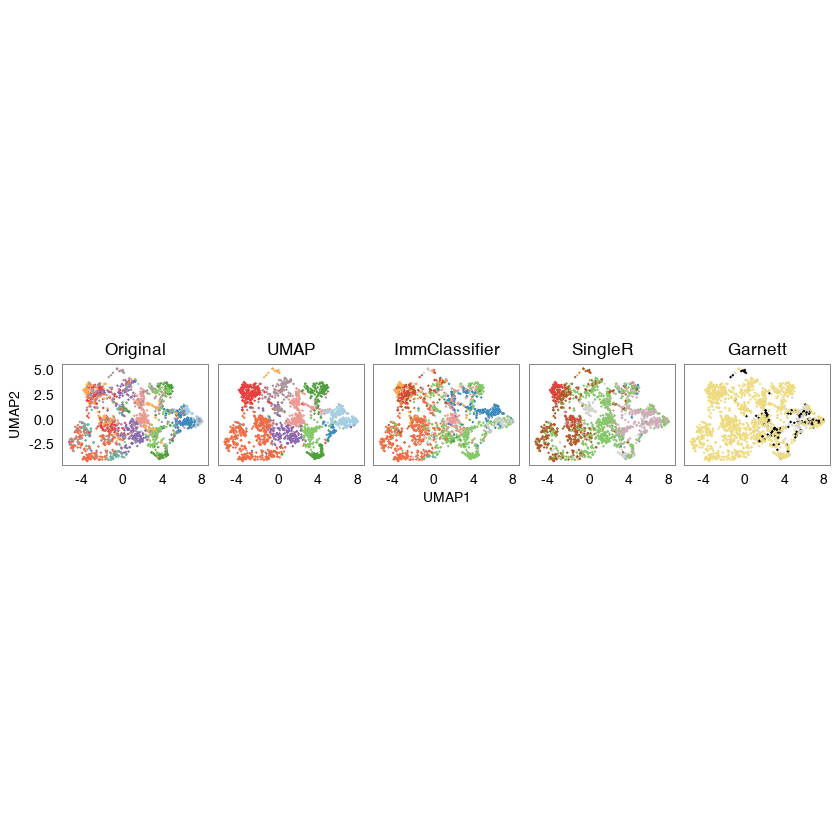

In [1601]:
set.seed(55)
subsample.df <- hcc.umap.df2 %>% 
    group_by(Original) %>% 
    sample_n(200, replace = T) %>% data.frame(stringsAsFactors = F)

subsample.df[, c(1,2,3,6,5,7,8,9)] %>% melt(id.vars = c('Cell', 'UMAP1', 'UMAP2')) %>% 
    mutate(value = factor(value, c('cytotoxic CD4 cells','effector memory CD8+T cells','exhausted CD4+ T cells ',
                                   'intermediate of EM and Exhausted T', 'exhausted CD8+ T cells ', 'MAIT cells',
                                   'naive CD4+ T cells', 'Tregs ','naive CD8+ T cells', 'CD4+T', 
                                   'CD8+T',  'T helper', 'unknown',#'unconvT',
                                   'T', 'central memory T', 'Other', 'Unassigned'))) %>%
    ggplot(aes(UMAP1, UMAP2)) + 
         geom_point(aes(color = value), size = .5, pch = 18) +
          theme_minimal() + 
    theme(legend.pos = "none", 
          panel.grid.minor = element_blank(), 
          panel.grid.major = element_blank(),
          panel.border = element_rect(color = "black", fill = NA, size = .1),
          axis.text.x = element_text(angle = 0, size = 8, hjust = 1,color= "black"), 
          axis.text.y = element_text(size = 8, hjust = 1,color = "black"),
          axis.title.x = element_text(angle = 0, size = 8, hjust = .5,color= "black"), 
          axis.title.y = element_text(angle = 90, size = 8, hjust = .5,color= "black"), 
          strip.text.x = element_text(size = 10, colour = "black", angle = 0)) +
    coord_equal () + 
      #  scale_color_manual(values=wes_palette(n=13, name="Rushmore1"))  + 
    scale_color_manual(values = c(colorRampPalette(brewer.pal(12, "Paired"))(15), 'lightgrey', 'black'),
                       guide = guide_legend(nrow=6,override.aes = list(size=4))) +
    facet_wrap(~variable, ncol = 5)



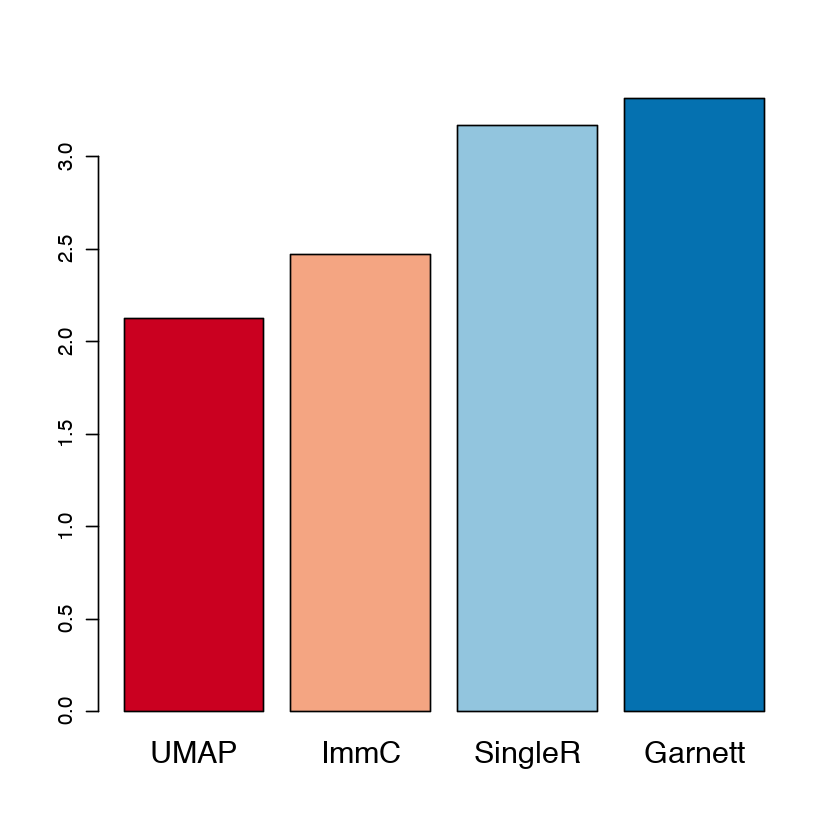

In [1602]:
x <- subsample.df[, c(6,5,7,8,9)] %>% group_by(Original) %>% 
    summarize(ImmC=sum(ImmClassifier!=Original)/n(), 
              SingleR=sum(SingleR!=Original)/n(),
              Garnett=sum(Garnett!=Original)/n(),
              UMAP=sum(UMAP!=Original)/n(),
              Origin=sum(Original!=Original)/n()
              
             ) %>% select(-1) %>% 
        #apply(2,  median) 
        apply(2, function(x) x^2) %>% apply(2, function(x) sqrt(sum(x))) %>% unlist

barplot(x[c(4,1,2,3)], col=brewer.pal(n = 4, name = 'RdBu'), cex.names= 1.5, angle = 45)

In [1813]:
hcc.umap.df %>% count(Original)

Original,n
cytotoxic CD4 cells,167
effector memory CD8+T cells,288
exhausted CD4+ T cells,146
exhausted CD8+ T cells,300
intermediate of EM and Exhausted T,467
MAIT cells,363
naive CD4+ T cells,646
naive CD8+ T cells,161
peripheral Tregs,261
T helper,689


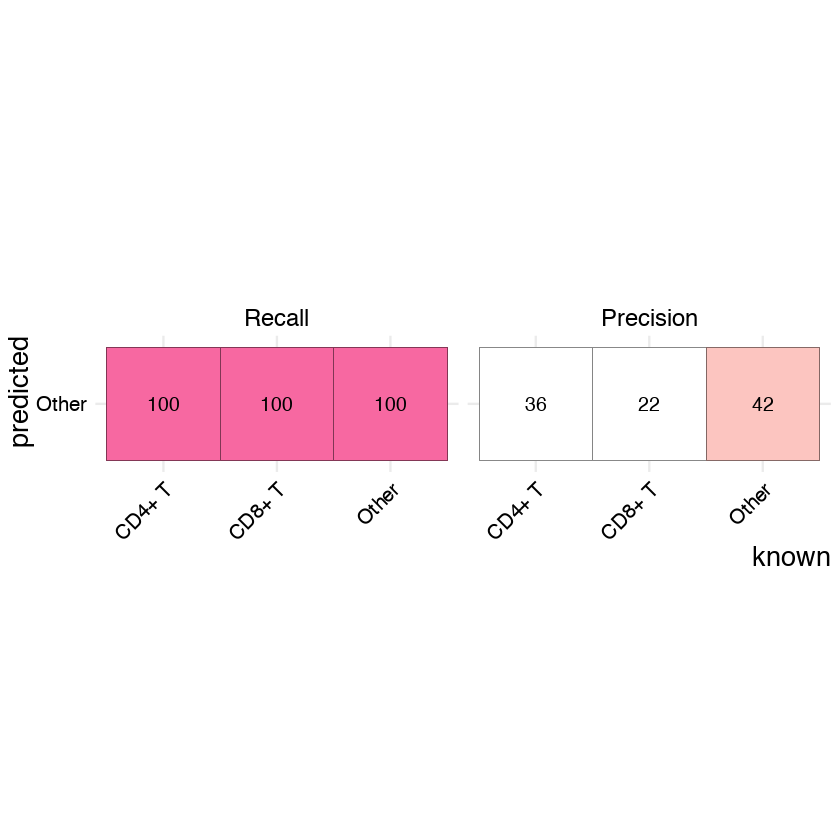

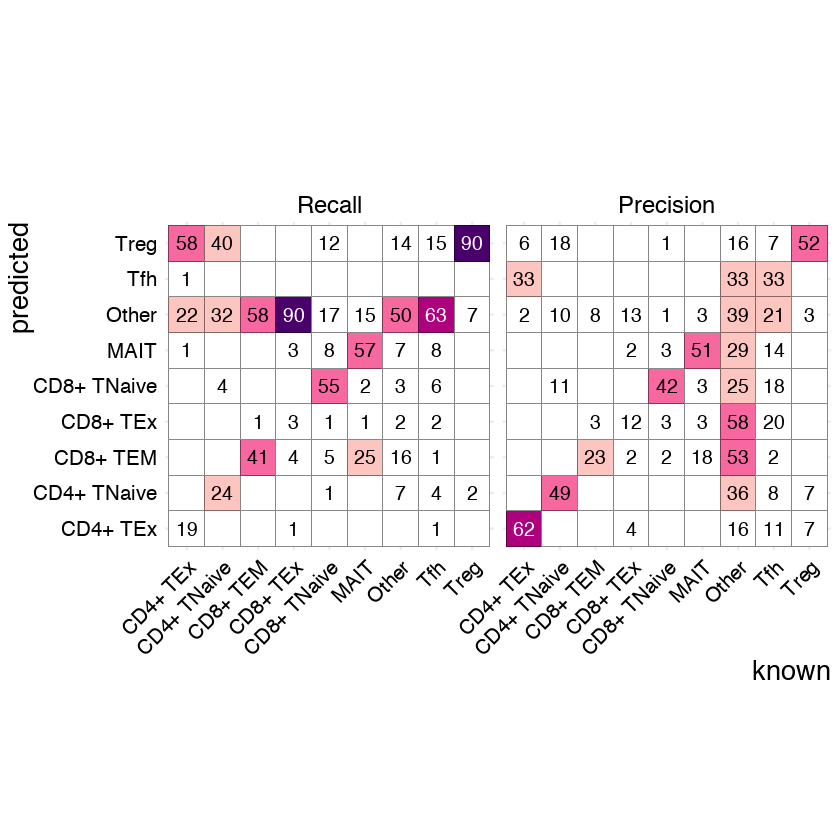

In [1826]:



hcc.umap.df.L3 <- hcc.umap.df %>% 
                            
                    mutate(Original = ifelse(grepl("CD4|Treg|Helper", Original), 'CD4+ T', Original)) %>%
                    mutate(Original = ifelse(grepl("CD8|MAIT", Original), 'CD8+ T', Original)) %>%
                    mutate(Original = ifelse(Original %in% c("CD4+ T", "CD8+ T"), Original, 'Other')) %>%
                    
                    mutate(ImmClassifier = ifelse(grepl("L:T:CD4",ImmClassifier),   "CD4+ T", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("L:T:CD8",ImmClassifier),   "CD8+ T", ImmClassifier)) %>%
                   
                    mutate(ImmClassifier = ifelse(ImmClassifier %in% c('CD4+ T', 'CD8+ T'), ImmClassifier, 'Other')) %>%
                    
                    
                    mutate(SingleR = ifelse(grepl("T_cell:CD4",SingleR),   "CD4+ T", SingleR)) %>%
                    mutate(SingleR = ifelse(grepl("T_cell:CD8",SingleR),   "CD8+ T", SingleR)) %>%
                    
                    mutate(SingleR = ifelse(SingleR %in% c('CD4+ T', 'CD8+ T'), SingleR, 'Other')) %>%

                    mutate(Garnett = ifelse(grepl("CD4",Garnett),   "CD4+ T", Garnett)) %>%
                    mutate(Garnett = ifelse(grepl("CD8",Garnett),   "CD8+ T", Garnett)) %>%
                
                    mutate(Garnett = ifelse(Garnett %in% c('CD4+ T', 'CD8+ T'), Garnett, 'Other'))  





hcc.L3.celltypes <- c('CD4', 'CD8')




hcc.ImmC.L3.recall <- c(87,82)
hcc.ImmC.L3.ppv <- c(61,44 )

hcc.SingleR.L3.recall <- c(93,42)
hcc.SingleR.L3.ppv <- c(43,50)

hcc.Garnett.L3.recall <- c(NA, NA)
hcc.Garnett.L3.ppv <- c(NA, NA)




hcc.umap.df.L3 %>% mutate(Known = Original, annot = Garnett) %>%
            select(Known, annot) %>% table %>%
            plot_heatmap(title = "", palette= "RdPu", 
           
              minshow = 1, size =12, size2= 4, minpct=0, ncol = 3, measures = c('Recall', 'Precision'))


hcc.umap.df.L4 <- hcc.umap.df %>% 
                          
                    mutate(Original = ifelse(grepl("naive CD4\\+ T cells", Original), 'CD4+ TNaive', Original)) %>%
                    mutate(Original = ifelse(grepl("naive CD8\\+ T cells", Original), 'CD8+ TNaive', Original)) %>%
                    mutate(Original = ifelse(grepl("Treg", Original), 'Treg', Original)) %>%
                    mutate(Original = ifelse(grepl("helper", Original), 'Tfh', Original)) %>%
                    mutate(Original = ifelse(grepl("MAIT", Original), 'MAIT', Original)) %>%
                    mutate(Original = ifelse(grepl("effector memory CD8\\+T cells", Original), 'CD8+ TEM', Original)) %>%
                    mutate(Original = ifelse(grepl("exhausted CD4\\+ T cells", Original), 'CD4+ TEx', Original)) %>%
                    mutate(Original = ifelse(grepl("exhausted CD8\\+ T cells", Original), 'CD8+ TEx', Original)) %>%
                    mutate(Original = ifelse(Original %in% c( "Tfh","CD4+ TNaive", "CD4+ TEx", "MAIT",
                                                                      "Treg", "CD8+ TEx","CD8+ TNaive", "CD8+ TEM"), Original, 'Other')) %>%
                    

                    mutate(ImmClassifier = ifelse(grepl("L:T:CD4:Ex",ImmClassifier),   "CD4+ TEx", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("L:T:CD4:Naïve",ImmClassifier),   "CD4+ TNaive", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("L:T:CD4:Treg",ImmClassifier),   "Treg", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("L:T:CD8:Ex",ImmClassifier),   "CD8+ TEx", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("L:T:CD8:Naïve",ImmClassifier),   "CD8+ TNaive", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("L:T:CD8:EM",ImmClassifier),   "CD8+ TEM", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("L:T:CD8:Mait",ImmClassifier),   "MAIT", ImmClassifier)) %>%
                     mutate(ImmClassifier = ifelse(grepl("L:T:CD4:Tfh",ImmClassifier),   "Tfh", ImmClassifier)) %>%
                
                    mutate(ImmClassifier = ifelse(ImmClassifier %in% c( "Tfh","CD4+ TNaive", "CD4+ TEx", "MAIT",
                                                                      "Treg", "CD8+ TEx","CD8+ TNaive", "CD8+ TEM"), ImmClassifier, 'Other')) %>%
                    
                    
                   
                    
                    mutate(SingleR = ifelse(grepl("T_cell:CD4\\+_Naive",SingleR),   "CD4+ TNaive", SingleR)) %>%
                    mutate(SingleR = ifelse(grepl("T_cell:CD8\\+_naive",SingleR),   "CD8+ TNaive", SingleR)) %>%

                    mutate(SingleR = ifelse(grepl("T_cell:CD8\\+_effector_memory",SingleR),   "CD8+ TEM", SingleR)) %>%
                    mutate(SingleR = ifelse(grepl("Treg",SingleR),   "Treg", SingleR)) %>%


                    mutate(SingleR = ifelse(SingleR %in% c( "Tfh","CD4+ TNaive", "CD4+ TEx", "MAIT",
                                                                      "Treg", "CD8+ TEx","CD8+ TNaive", "CD8+ TEM"), SingleR, 'Other')) %>%

                  
                    mutate(Garnett = ifelse(Garnett %in% c( "Tfh","CD4+ TNaive", "CD4+ TEx", "MAIT",
                                                                      "Treg", "CD8+ TEx","CD8+ TNaive", "CD8+ TEM"), Garnett, 'Other'))  





hcc.L4.celltypes <- c( "CD4+ TNaive", "CD4+ TEx", "Tfh", "Treg", "CD8+ TEx","CD8+ TNaive", "CD8+ TEM","MAIT")




hcc.ImmC.L4.recall <- c(24, 19,NA,90,3,55,44,57)
hcc.ImmC.L4.ppv <- c(49,62,33,52,12,42,23,51)

hcc.SingleR.L4.recall <- c(20,NA, NA, NA,NA,NA,1,NA)
hcc.SingleR.L4.ppv <- c( 49,NA, NA,NA, NA,NA, 5,NA)

hcc.Garnett.L4.recall <- rep(NA, 8)
hcc.Garnett.L4.ppv <- rep(NA, 8)




hcc.umap.df.L4 %>% mutate(Known = Original, annot = ImmClassifier) %>%
            select(Known, annot) %>% table %>%
            plot_heatmap(title = "", palette= "RdPu", 
           
              minshow = 0, size =12, size2= 4, minpct=0, ncol = 3, measures = c('Recall', 'Precision'))



celltype,recall,precision,method,level
L,97,99,ImmClassifier,1
M,94,95,SingleR,1
L,99,99,Garnett,1
M,92,97,ImmClassifier,1
L,87,97,SingleR,1
M,55,92,Garnett,1
B,81,89,ImmClassifier,2
T,97,99,SingleR,2
NK,70,64,Garnett,2
Dendritic,50,53,ImmClassifier,2


# PBMC68K UMAP

In [1358]:
load('../ImmClassifier/singleR/output//singler_pbmc68k.RData')
pbmc68k.singler <- singler
pbmc68k.singler.df <- data.frame(singler=pbmc68k.singler$singler[[1]]$SingleR.single$labels, stringsAsFactors = F)
rownames(pbmc68k.singler.df ) <- pbmc68k.singler$singler[[1]]$SingleR.single$cell.names


pbmc68k.garnett.extend  <- readRDS('../ImmClassifier//garnett/test/pbmc68k.garnett.extend.rds')

pbmc68k.umap <- read.table('../ImmClassifier-LabelTransfer-DL/umap//out-pbmc_umap/models/umap.pca_1000.cluster_10.k_25.res_0.8.umap_25/coordinates.txt',
                            header = T, sep = "\t", stringsAsFactors = F)

rownames(pbmc68k.umap) <- pbmc68k.umap$Cell

pbmc68k.common.cells <- intersect(pbmc68k.ontotree$Cell, rownames(pbmc68k.singler.df))

pbmc68k.umap.df <- pbmc68k.umap[pbmc68k.common.cells, c('Cell', 'UMAP1', 'UMAP2', 'Cluster')] %>% 
                    mutate( UMAP=as.character(Cluster),
                        Original = pbmc68k.meta[Cell, 'celltype'],
                        ImmClassifier=pbmc68k.ontotree$assign.labels[pbmc68k.ontotree$Cell %in% pbmc68k.common.cells],
                        SingleR = pbmc68k.singler.df[Cell,'singler'],
                        Garnett= pbmc68k.garnett.extend[Cell, 'cluster_ext_type']) 


In [1359]:

# match clusters between original and unsupervised umap

original.centroids <- pbmc68k.umap.df %>% group_by(Original) %>% 
                    summarize(C1=mean(UMAP1),
                              C2=mean(UMAP2)) 


unsupervised.centroids <- pbmc68k.umap.df %>% group_by(UMAP) %>% 
                    summarize(C1=mean(UMAP1),
                              C2=mean(UMAP2)) 

matched.centroids <-  unsupervised.centroids %>%
    apply(1, function(x) original.centroids[order((original.centroids[, 'C1']-as.numeric(x[2]))^2 
                         + (original.centroids[, 'C2']-as.numeric(x[3]))^2)[1], 1] %>% unlist) 

names(matched.centroids) <- unsupervised.centroids$UMAP
          
matched.centroids

0                              1 
"CD8+/CD45RA+ Naive Cytotoxic" "CD8+/CD45RA+ Naive Cytotoxic" 
                            10                             11 
             "CD4+/CD25 T Reg"               "CD14+ Monocyte" 
                            12                             13 
                    "CD56+ NK"                    "Dendritic" 
                            14                             15 
                     "CD19+ B"                    "Dendritic" 
                            16                             17 
              "CD4+ T Helper2"                        "CD34+" 
                             2                              3 
             "CD4+/CD25 T Reg"             "CD8+ Cytotoxic T" 
                             4                              5 
                    "CD56+ NK"                     "CD56+ NK" 
                             6                              7 
                     "CD19+ B"          "CD4+/CD45RO+ Memory" 
                             8                              9 
              "CD4+ T Helper2"               "CD14+ Monocyte"

In [1607]:
pbmc68k.umap.df2 <- pbmc68k.umap.df %>%
                           
                   
                    mutate(ImmClassifier = ifelse(grepl("M:Mono",ImmClassifier),   "CD14+ Monocyte", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("L:B$",ImmClassifier),   "CD19+ B", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("L:B:PC",ImmClassifier),   "Plasma Cell", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("CD34",ImmClassifier),   "CD34+", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("L:T:CD4:Naïve",ImmClassifier),   "CD4+/CD45RA+/CD25- Naive T", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("L:T:CD8:Naïve",ImmClassifier),   "CD8+/CD45RA+ Naive Cytotoxic", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("L:T:CD4:CM|L:T:CD4:EM",ImmClassifier),   "CD4+/CD45RO+ Memory", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("L:T:CD8:CM|L:T:CD8:EM",ImmClassifier),   "CD8+ memory", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("NK",ImmClassifier),   "NK", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("L:T:CD4:Tfh",ImmClassifier),   "CD4+ T Helper2", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("L:T:CD4:Treg",ImmClassifier),   "CD4+/CD25 T Reg", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("L:NK",ImmClassifier),   "CD56+ NK", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("cDC|pDC",ImmClassifier),   "Dendritic", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(!grepl("CD8\\+ memory|Plasma Cell|CD14\\+ Monocyte|CD19\\+ B|CD34\\+|T Helper2|Naive T|T Reg| Memory|NK|Dendritic", ImmClassifier),  "Other", ImmClassifier)) %>%
                    
                    mutate(SingleR = ifelse(grepl("Plasma_cell",SingleR),   "Plasma Cell", SingleR)) %>%
                    mutate(SingleR = ifelse(grepl("B_cell",SingleR),"CD19+ B", SingleR)) %>%
                    mutate(SingleR = ifelse(grepl("CMP|GMP|MEP|CD34",SingleR),   "CD34+", SingleR)) %>%
                    mutate(SingleR = ifelse(grepl("Monocyte",SingleR),   "CD14+ Monocyte", SingleR)) %>%             
                    mutate(SingleR = ifelse(grepl("Treg",SingleR),   "Tregs ", SingleR)) %>%
                    mutate(SingleR = ifelse(grepl("NK",SingleR),   "NK", SingleR)) %>%
                    mutate(SingleR = ifelse(grepl("T_cell:CD4\\+_central_memory|T_cell:CD4\\+_effector_memory",SingleR),   "CD4+/CD45RO+ Memory", SingleR)) %>%
                    mutate(SingleR = ifelse(grepl("T_cell:CD4\\+_Naive",SingleR),   "CD4+/CD45RA+/CD25- Naive T", SingleR)) %>%
                    mutate(SingleR = ifelse(grepl("T_cell:CD8\\+_Naive",SingleR),   "CD8+/CD45RA+ Naive Cytotoxic", SingleR)) %>%
                    mutate(SingleR = ifelse(grepl("T_cell:CD8\\+_Central_memory|T_cell:CD8\\+_effector_memory",SingleR),   "CD8+ memory", SingleR)) %>%
                    
                   
                    mutate(SingleR = ifelse(grepl("Dendritic",SingleR),   "Dendritic", SingleR)) %>%
                    mutate(SingleR = ifelse(SingleR == 'T_cell:CD4+',   "CD4+T", SingleR)) %>%
                    mutate(SingleR = ifelse(SingleR == 'T_cell:CD8+',   "CD8+T", SingleR)) %>%

                    # mutate(SingleR = ifelse(grepl("T_cell:CD8\\+_Central_memory|T_cell:CD8\\+_effector_memory",SingleR),   "Tregs ", SingleR)) %>%    
                
                    mutate(SingleR = ifelse(!grepl("NK|CD4\\+T|CD8\\+T|Plasma Cell|Dendritic|CD8\\+ memory|CD45RA|CD45RO|Tregs |CD14\\+ Monocyte|CD34|CD19\\+ B", SingleR),  "Other", SingleR))  %>%
                    
                     mutate(Garnett = ifelse(grepl("CD4 T cells",Garnett),   "CD4+T", Garnett)) %>%
                        mutate(Garnett = ifelse(grepl("CD8 T cells",Garnett),   "CD8+T", Garnett)) %>%
                    mutate(Garnett = ifelse(grepl("CD34",Garnett),   "CD34+", Garnett)) %>%
                mutate(Garnett = ifelse(grepl("Dendritic",Garnett),   "Dendritic", Garnett)) %>%
                    mutate(Garnett = ifelse(grepl("Monocytes",Garnett),   "CD14+ Monocyte", Garnett)) %>%
                    mutate(Garnett = ifelse(grepl("T cells",Garnett),   "T", Garnett)) %>%
                    mutate(Garnett = ifelse(grepl("Unknown",Garnett),   "Unassigned", Garnett)) %>%
                    mutate(Garnett = ifelse(grepl("NK",Garnett),   "NK", Garnett)) %>%
                    mutate(Garnett = ifelse(grepl("B cells",Garnett),   "CD19+ B", Garnett)) %>%
                    
                    mutate(Garnett = ifelse(!grepl("T|Unassigned|CD19|NK|Mono|Dendr|CD34", Garnett),  "Other", Garnett))  #%>%
                   

                    #mutate(UMAP = matched.centroids[UMAP]) %>%
                    #mutate(UMAP = ifelse(grepl("Tregs",UMAP),   "Tregs ", UMAP)) 

In [1609]:
pbmc68k.umap.df2 %>% count(UMAP) %>% str

Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	18 obs. of  2 variables:
 $ UMAP: chr  "0" "1" "10" "11" ...
 $ n   : int  12775 10991 1776 1443 1054 811 707 364 215 149 ...


Warning message:
“Removed 1100 rows containing missing values (geom_point).”

Warning message:
“Removed 4400 rows containing missing values (geom_point).”

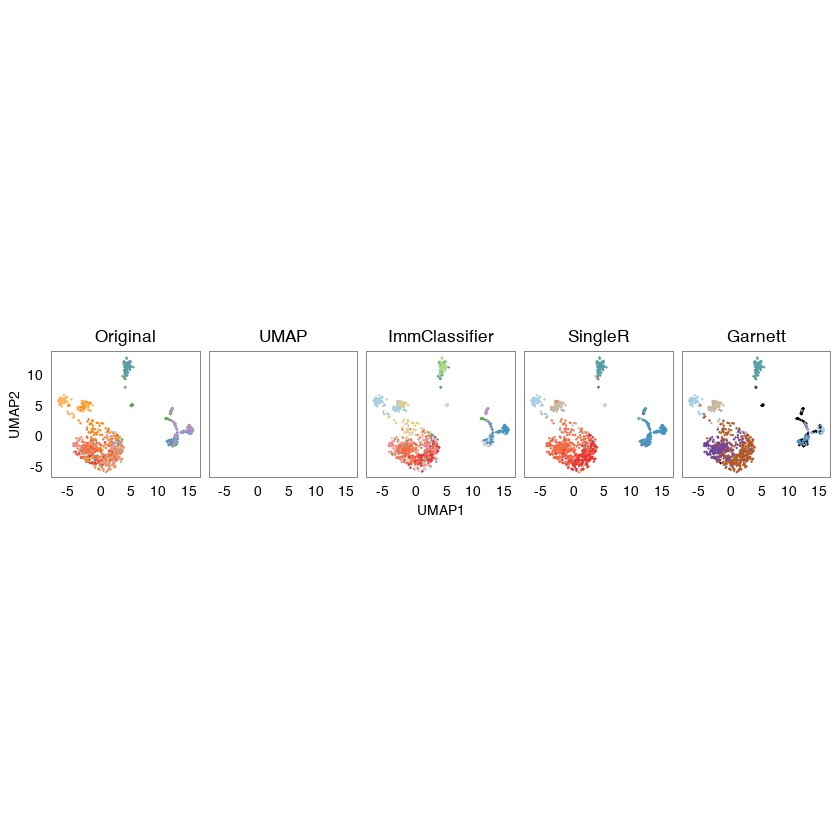

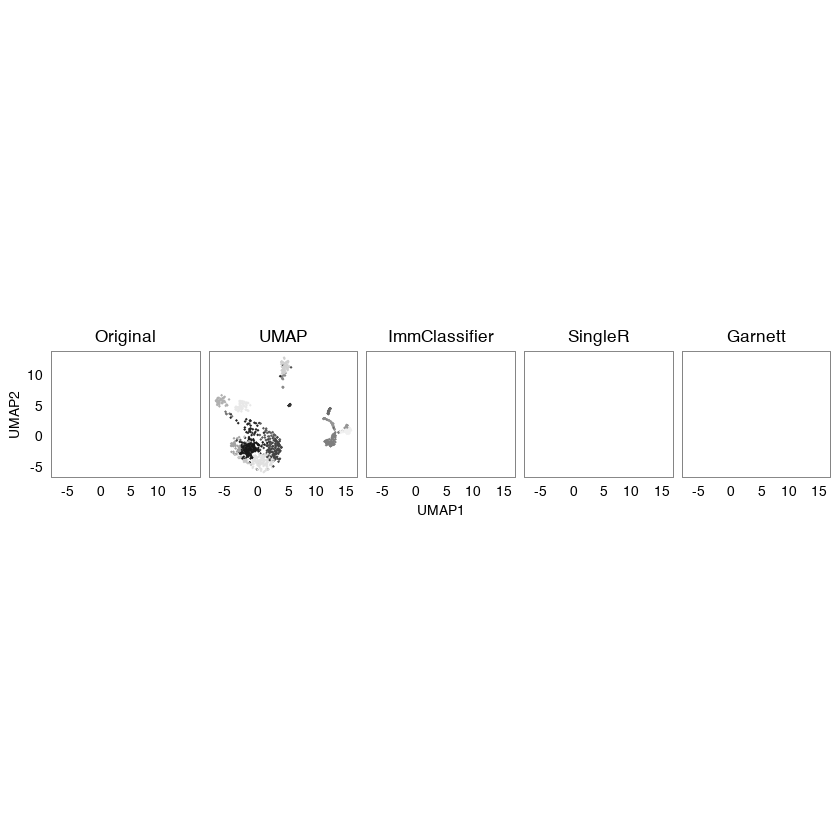

In [1637]:
set.seed(55)

subsample.df <- pbmc68k.umap.df2 %>% 
    group_by(Original) %>% 
    sample_n(100, replace = T) %>% data.frame(stringsAsFactors = F)

subsample.df[, c(1,2,3,6,5,7,8,9)] %>% melt(id.vars = c('Cell', 'UMAP1', 'UMAP2')) %>% 
    mutate(value = factor(value, c('NK','CD14+ Monocyte', 'CD19+ B', 'Plasma Cell','CD34+', 'CD4+ T Helper2', 
                                    'CD4+/CD25 T Reg', 'CD4+/CD45RA+/CD25- Naive T', 'CD4+/CD45RO+ Memory',
                                    'CD56+ NK', 'CD8+ Cytotoxic T', 'CD8+/CD45RA+ Naive Cytotoxic', 'Dendritic',
                                       'CD4+T', 'CD8+T',  'CD8+ memory', 'T',
                                   'Other', 'Unassigned'))) %>%
    ggplot(aes(UMAP1, UMAP2)) + 
         geom_point(aes(color = value), size = .5, pch = 18) +
          theme_minimal() + 
     theme(legend.pos = "none", 
          panel.grid.minor = element_blank(), 
          panel.grid.major = element_blank(),
          panel.border = element_rect(color = "black", fill = NA, size = .1),
          axis.text.x = element_text(angle = 0, size = 8, hjust = 1,color= "black"), 
          axis.text.y = element_text(size = 8, hjust = 1,color = "black"),
          axis.title.x = element_text(angle = 0, size = 8, hjust = .5,color= "black"), 
          axis.title.y = element_text(angle = 90, size = 8, hjust = .5,color= "black"), 
          strip.text.x = element_text(size = 10, colour = "black", angle = 0)) +
    coord_equal () + 
      #  scale_color_manual(values=wes_palette(n=13, name="Rushmore1"))  + 
    scale_color_manual(values = c(colorRampPalette(brewer.pal(12, "Paired"))(17), 'lightgrey', 'black'),
                       guide = guide_legend(ncol = 3, override.aes = list(size=4))) +
    facet_wrap(~variable, ncol = 5)

subsample.df[, c(1,2,3,6,5,7,8,9)] %>% melt(id.vars = c('Cell', 'UMAP1', 'UMAP2')) %>% 
    mutate(value = factor(value, as.character(c(0:17)))) %>%
    ggplot(aes(UMAP1, UMAP2)) + 
         geom_point(aes(color = value), size = .5, pch = 18) +
          theme_minimal() + 
     theme(legend.pos = "none", 
          panel.grid.minor = element_blank(), 
          panel.grid.major = element_blank(),
          panel.border = element_rect(color = "black", fill = NA, size = .1),
          axis.text.x = element_text(angle = 0, size = 8, hjust = 1,color= "black"), 
          axis.text.y = element_text(size = 8, hjust = 1,color = "black"),
          axis.title.x = element_text(angle = 0, size = 8, hjust = .5,color= "black"), 
          axis.title.y = element_text(angle = 90, size = 8, hjust = .5,color= "black"), 
          strip.text.x = element_text(size = 10, colour = "black", angle = 0)) +
    coord_equal () + 
      #  scale_color_manual(values=wes_palette(n=13, name="Rushmore1"))  + 
    scale_color_manual(values = c(sample(colorRampPalette(brewer.pal(9, "Greys"))(25)[4:23]),18),
                       guide = guide_legend(ncol = 3, override.aes = list(size=4))) +
    facet_wrap(~variable, ncol = 5)



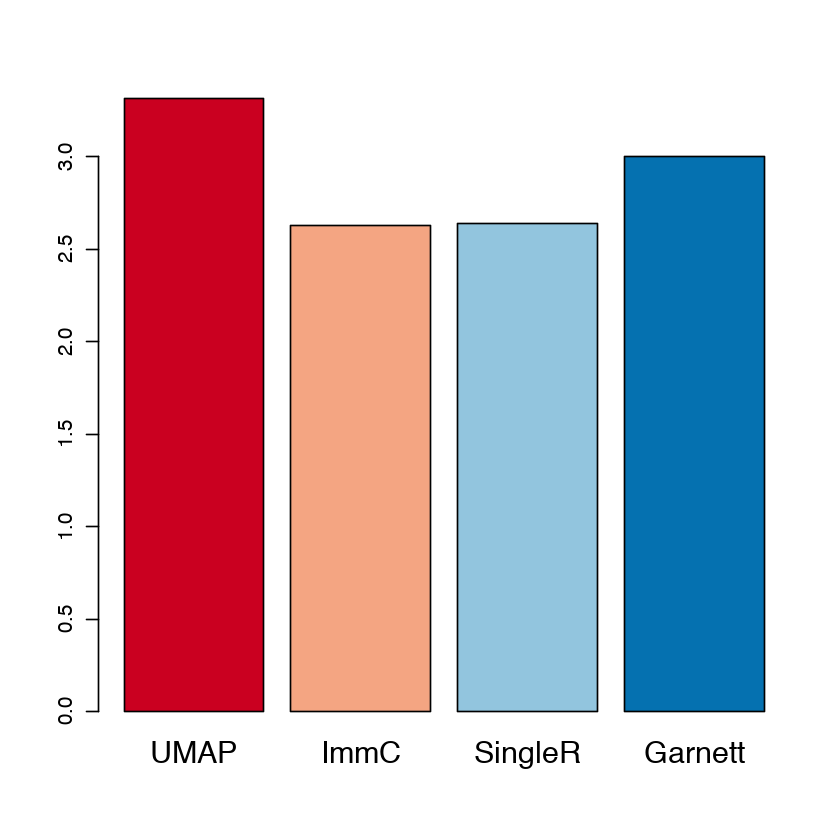

In [1636]:
x <- subsample.df[, c(6,5,7,8,9)] %>% group_by(Original) %>% 
    summarize(ImmC=sum(ImmClassifier!=Original)/n(), 
              SingleR=sum(SingleR!=Original)/n(),
              Garnett=sum(Garnett!=Original)/n(),
              UMAP=sum(UMAP!=Original)/n(),
              Origin=sum(Original!=Original)/n()
              
             ) %>% select(-1) %>% 
        #apply(2,  median) 
        apply(2, function(x) x^2) %>% apply(2, function(x) sqrt(sum(x))) %>% unlist

barplot(x[c(4,1,2,3)], col=brewer.pal(n = 4, name = 'RdBu'), cex.names= 1.5, angle = 45)

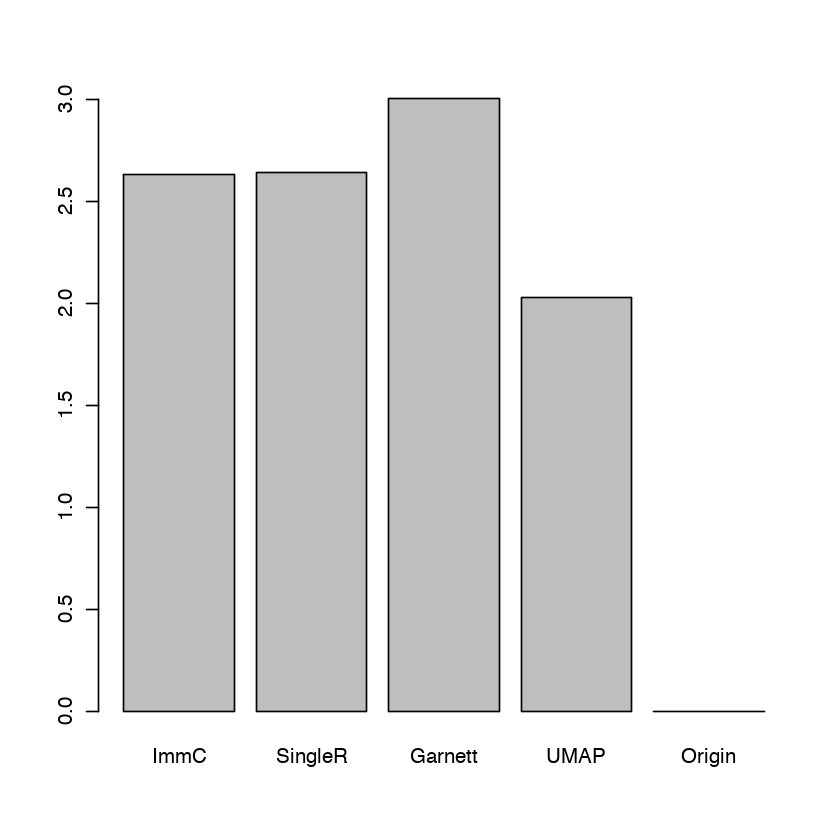

In [1573]:
x <- c(0, 0, 0, 0, 0)
y <- subsample.df[, c(6,5,7,8,9)] %>% group_by(Original) %>% 
    summarize(ImmC=sum(ImmClassifier!=Original)/n(), 
              SingleR=sum(SingleR!=Original)/n(),
              Garnett=sum(Garnett!=Original)/n(),
              UMAP=sum(UMAP!=Original)/n(),
              Origin=sum(Original!=Original)/n()
              
             ) %>% select(-1) %>% 
        #apply(2,  median) 
        apply(2, function(x) x^2) %>% apply(2, function(x) sqrt(sum(x))) %>% barplot



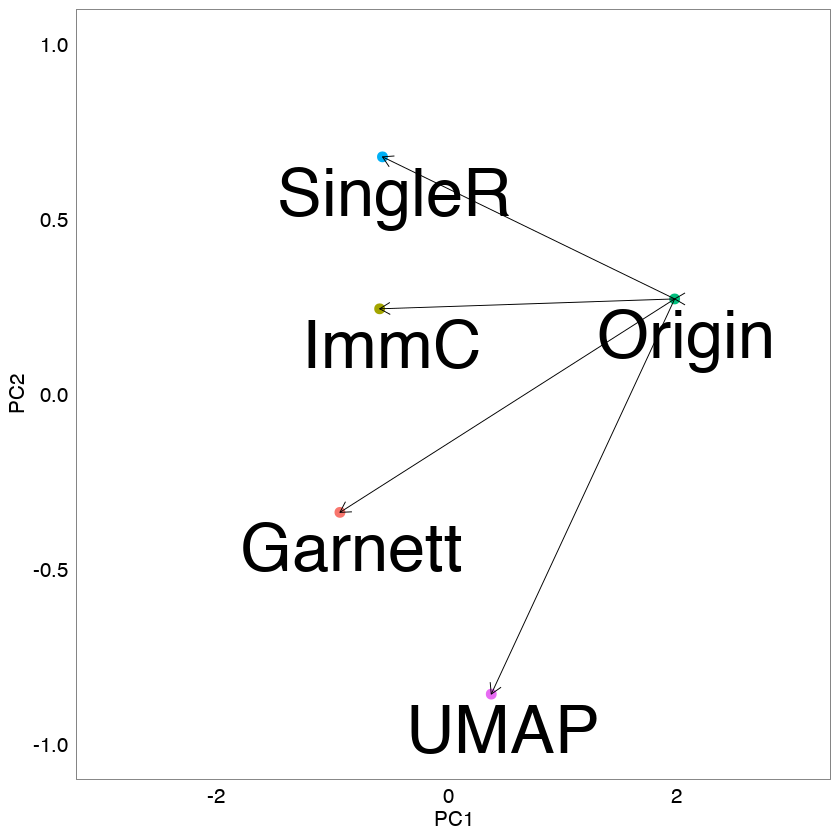

In [1529]:
 subsample.pca <- subsample.df[, c(6,5,7,8,9)] %>% group_by(Original) %>% 
    summarize(ImmC=sum(ImmClassifier==Original)/n(), 
              SingleR=sum(SingleR==Original)/n(),
              Garnett=sum(Garnett==Original)/n(),
              UMAP=sum(UMAP==Original)/n(),
              Origin=sum(Original==Original)/n()
             ) %>% select(2,3,4,5,6) %>% t %>% prcomp

subsample.pca$x %>% data.frame(stringsAsFactors = F) %>%
        mutate(method = rownames(subsample.pca$x)) %>%
        ggplot(aes(PC1, PC2)) + 
         geom_point(aes(color = method), size = 2, pch =19) +
          theme_minimal() + 
        #coord_equal() + 
        ylim(-1,1) + xlim(-3,3) +
         theme(legend.pos = "none", 
          panel.grid.minor = element_blank(), 
          panel.grid.major = element_blank(),
          panel.border = element_rect(color = "black", fill = NA, size = .1),
          axis.text.x = element_text(angle = 0, size = 12, hjust = 1,color= "black"), 
          axis.text.y = element_text(size = 12, hjust = 1,color = "black"),
          axis.title.x = element_text(angle = 0, size = 12, hjust = .5,color= "black"), 
          axis.title.y = element_text(angle = 90, size = 12, hjust = .5,color= "black")
          ) +
        geom_text_repel(aes(label=method), nudge_y = -0.1, nudge_x= .1, size =14)  +
         geom_segment(aes(x = subsample.pca$x[5, 1], y =subsample.pca$x[5, 2], xend = PC1, yend = PC2), 
                      color = "black", arrow = arrow(length = unit(0.1, "inches")), size = .2)

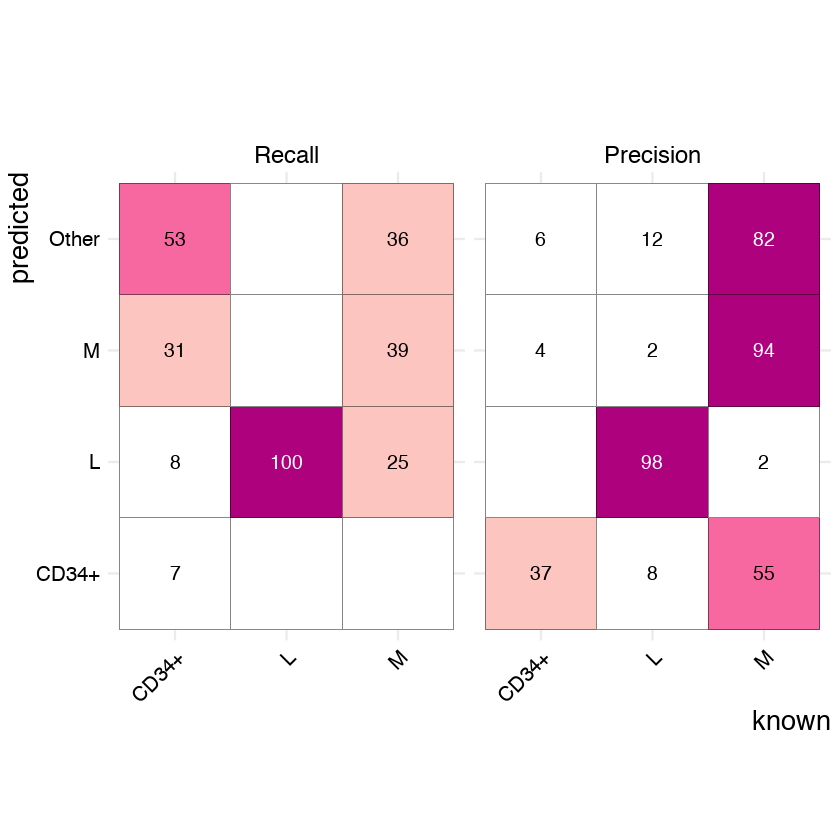

In [1890]:
pbmc68k.umap.df.L1 <- pbmc68k.umap.df %>% 
                                 
                    mutate(Original = ifelse(grepl("Mono|Dendritic", Original), 'M', Original)) %>%
                    mutate(Original = ifelse(grepl("T|NK|CD4|CD8|B", Original), 'L', Original)) %>%
                    mutate(Original = ifelse(grepl("CD34", Original), 'CD34+', Original)) %>%

                    mutate(ImmClassifier = ifelse(grepl("L:",ImmClassifier),   "L", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("M:",ImmClassifier),   "M", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("CD34",ImmClassifier),   "CD34+", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(ImmClassifier %in% c('L', 'M', 'CD34+'), ImmClassifier, 'Other'))  %>%

                    mutate(SingleR = ifelse(grepl("B_cell|T_cell|NK",SingleR),   "L", SingleR)) %>%
                    mutate(SingleR = ifelse(grepl("Mono|Neutro|Macro",SingleR),   "M", SingleR)) %>%
                    mutate(SingleR = ifelse(grepl("HSC|CD34\\+|GMP|CMP|MEP",SingleR),   "CD34+", SingleR)) %>%
                    
                    mutate(SingleR = ifelse(SingleR %in% c('L', 'M', 'CD34+'), SingleR, 'Other')) %>%

                    mutate(Garnett = ifelse(grepl("B cells|T cells|NK",Garnett),   "L", Garnett)) %>%
                    mutate(Garnett = ifelse(grepl("Mono|Den",Garnett),   "M", Garnett)) %>%
                    mutate(Garnett = ifelse(Garnett %in% c('L', 'M', 'CD34+'), Garnett, 'Other'))  



pbmc68k.umap.df.L1 %>% mutate(Known = Original, annot = Garnett) %>%
            select(Known, annot) %>% table %>%
            plot_heatmap(title = "", palette= "RdPu", 
           
              minshow = 1, size =12, size2= 4, minpct=0, ncol = 3, measures = c('Recall', 'Precision'))



pbmc68k.L1.celltypes <- c('L', 'M', 'CD34')
pbmc68k.ImmC.L1.recall <- c(100,94,18)
pbmc68k.ImmC.L1.ppv <- c(100,94,30)

pbmc68k.SingleR.L1.recall <- c(100, 88,20)
pbmc68k.SingleR.L1.ppv <- c(99,100,78)

pbmc68k.Garnett.L1.recall <- c(100,39,7)
pbmc68k.Garnett.L1.ppv <- c(98,94,37)


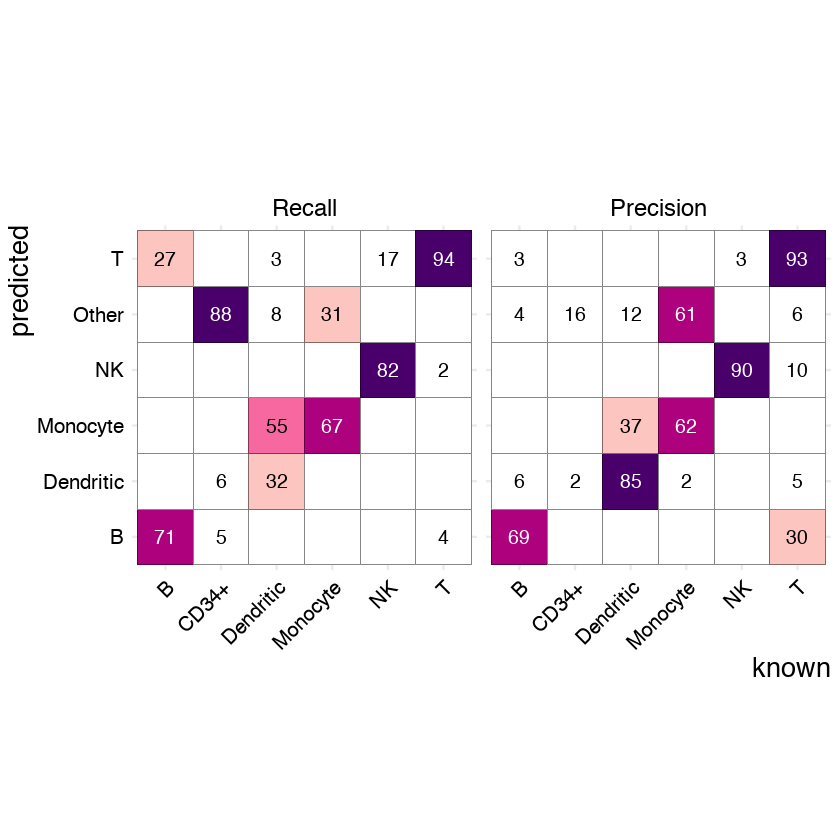

In [1891]:


pbmc68k.umap.df.L2 <- pbmc68k.umap.df %>% 
                               
                    mutate(Original = ifelse(grepl("B", Original), 'B', Original)) %>%
                    mutate(Original = ifelse(grepl("T|CD4|CD8", Original), 'T', Original)) %>%
                    mutate(Original = ifelse(grepl("NK", Original), 'NK', Original)) %>%
                    mutate(Original = ifelse(grepl("Dendritic", Original), 'Dendritic', Original)) %>%
                    mutate(Original = ifelse(grepl("Monocyte", Original), 'Monocyte', Original)) %>%
                    

                    mutate(ImmClassifier = ifelse(grepl("L:T|convT",ImmClassifier),   "T", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("L:NK",ImmClassifier),   "NK", ImmClassifier)) %>%
                     mutate(ImmClassifier = ifelse(grepl("L:B",ImmClassifier),   "B", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("M:Mono",ImmClassifier),   "Monocyte", ImmClassifier)) %>%
                   
                    mutate(ImmClassifier = ifelse(grepl("DC",ImmClassifier),   "Dendritic", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(ImmClassifier %in% c('B','T','NK', 'Dendritic', 'Monocyte'), ImmClassifier, 'Other')) %>%
                    
                    mutate(SingleR = ifelse(grepl("B_cell",SingleR),   "B", SingleR)) %>%
                    mutate(SingleR = ifelse(grepl("T_cell",SingleR),   "T", SingleR)) %>%
                    mutate(SingleR = ifelse(grepl("NK",SingleR),   "NK", SingleR)) %>%
                    mutate(SingleR = ifelse(grepl("DC",SingleR),   "Dendritic", SingleR)) %>%
                    mutate(SingleR = ifelse(grepl("Monocyte",SingleR),   "Monocyte", SingleR)) %>%
                   
                    mutate(SingleR = ifelse(SingleR %in% c('B','T','NK', 'Dendritic', 'Monocyte'), SingleR, 'Other')) %>%

                    mutate(Garnett = ifelse(grepl("B cells",Garnett),   "B", Garnett)) %>%
                    mutate(Garnett = ifelse(grepl("T cells",Garnett),   "T", Garnett)) %>%
                    mutate(Garnett = ifelse(grepl("NK",Garnett),   "NK", Garnett)) %>%
                    mutate(Garnett = ifelse(grepl("Mono",Garnett),   "Monocyte", Garnett)) %>%
                    mutate(Garnett = ifelse(grepl("Dend",Garnett),   "Dendritic", Garnett)) %>%

                    mutate(Garnett = ifelse(Garnett %in% c('B','T','NK', 'Dendritic', 'Monocyte'), Garnett, 'Other'))  




pbmc68k.L2.celltypes <- c('B', 'T', 'NK', 'Dendritic', 'Monocyte')




pbmc68k.ImmC.L2.recall <- c(71,94,82,32,67)
pbmc68k.ImmC.L2.ppv <- c(69,93,90,85,62)

pbmc68k.SingleR.L2.recall <- c(65,99,49,NA,93)
pbmc68k.SingleR.L2.ppv <- c(88,88,95,NA,60)

pbmc68k.Garnett.L2.recall <- c(65, 99,51,21,38)
pbmc68k.Garnett.L2.ppv <- c(97, 88,80,81,73)



pbmc68k.umap.df.L2 %>% mutate(Known = Original, annot = ImmClassifier) %>%
            select(Known, annot) %>% table %>%
            plot_heatmap(title = "", palette= "RdPu", 
           
              minshow = 1, size =12, size2= 4, minpct=0, ncol = 3, measures = c('Recall', 'Precision'))




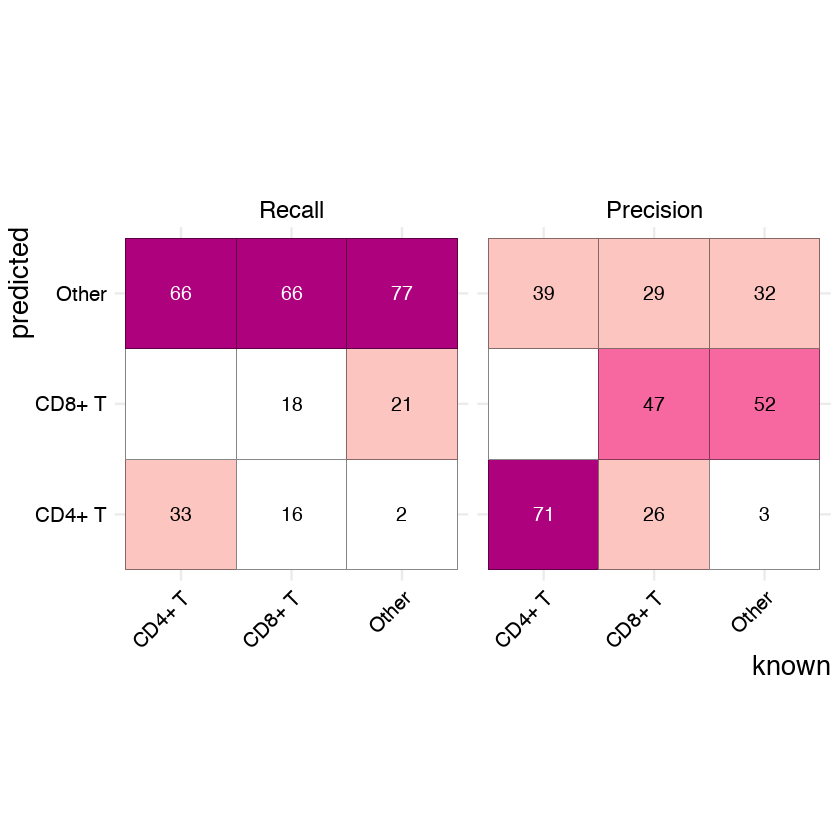

In [1892]:

pbmc68k.umap.df.L3 <- pbmc68k.umap.df %>% 
                              
                    
                    mutate(Original = ifelse(grepl("CD4|Treg", Original), 'CD4+ T', Original)) %>%
                    mutate(Original = ifelse(grepl("CD8", Original), 'CD8+ T', Original)) %>%
                    mutate(Original = ifelse(Original %in% c('CD4+ T', 'CD8+ T'), Original, 'Other')) %>%
                    
                    mutate(ImmClassifier = ifelse(grepl("L:T:CD4",ImmClassifier),   "CD4+ T", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("L:T:CD8",ImmClassifier),   "CD8+ T", ImmClassifier)) %>%
                    
                    mutate(ImmClassifier = ifelse(ImmClassifier %in% c('CD4+ T', 'CD8+ T'), ImmClassifier, 'Other')) %>%
                    
                    
                    mutate(SingleR = ifelse(grepl("T_cell:CD4",SingleR),   "CD4+ T", SingleR)) %>%
                     mutate(SingleR = ifelse(grepl("T_cell:CD8",SingleR),   "CD8+ T", SingleR)) %>%
                    
                    mutate(SingleR = ifelse(SingleR %in% c('CD4+ T', 'CD8+ T'), SingleR, 'Other')) %>%

                    mutate(Garnett = ifelse(grepl("CD4",Garnett),   "CD4+ T", Garnett)) %>%
                    mutate(Garnett = ifelse(grepl("CD8",Garnett),   "CD8+ T", Garnett)) %>%
                
                    mutate(Garnett = ifelse(Garnett %in% c('CD4+ T', 'CD8+ T'), Garnett, 'Other'))  





pbmc68k.L3.celltypes <- c('CD4', 'CD8' )




pbmc68k.ImmC.L3.recall <- c(80,52)
pbmc68k.ImmC.L3.ppv <- c(69,66)

pbmc68k.SingleR.L3.recall <- c(98,23)
pbmc68k.SingleR.L3.ppv <- c(60,49)

pbmc68k.Garnett.L3.recall <- c(33,18)
pbmc68k.Garnett.L3.ppv <- c(71,47)




pbmc68k.umap.df.L3 %>% mutate(Known = Original, annot = Garnett) %>%
            select(Known, annot) %>% table %>%
            plot_heatmap(title = "", palette= "RdPu", 
           
              minshow = 1, size =12, size2= 4, minpct=0, ncol = 3, measures = c('Recall', 'Precision'))



In [1893]:
pbmc68k.umap.df %>% count(Original)

Original,n
CD14+ Monocyte,2862
CD19+ B,5896
CD34+,262
CD4+ T Helper2,97
CD4+/CD25 T Reg,6187
CD4+/CD45RA+/CD25- Naive T,1871
CD4+/CD45RO+ Memory,3060
CD56+ NK,8776
CD8+ Cytotoxic T,20772
CD8+/CD45RA+ Naive Cytotoxic,16661


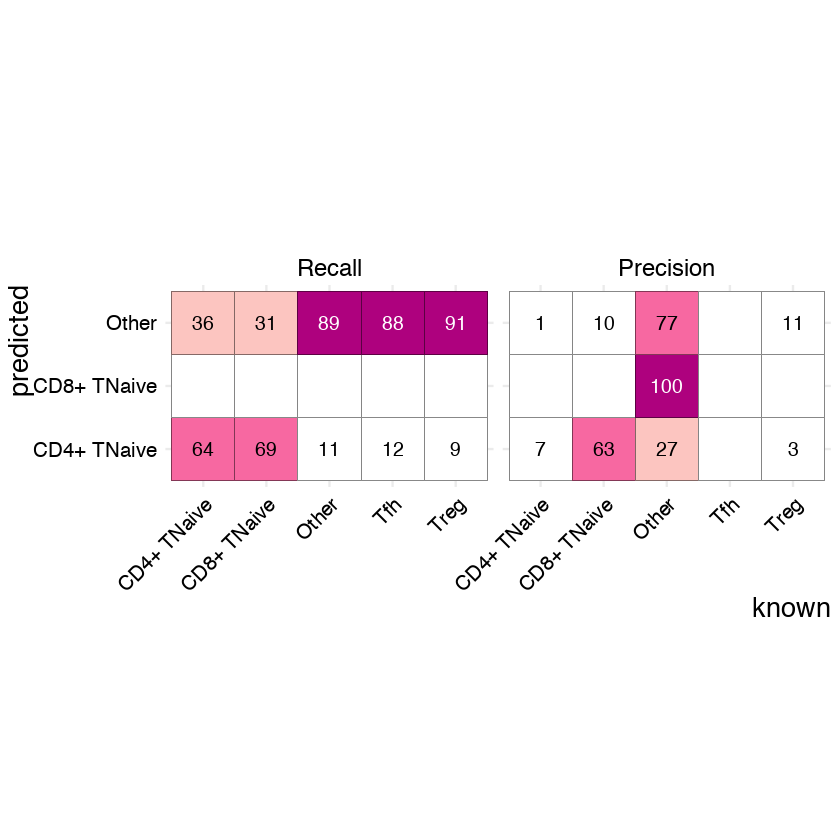

In [1894]:

pbmc68k.umap.df.L4 <- pbmc68k.umap.df %>% 
                               
                    mutate(Original = ifelse(grepl("CD4\\+\\/CD45RA\\+\\/CD25- Naive T", Original), 'CD4+ TNaive', Original)) %>%
                    mutate(Original = ifelse(grepl("CD8\\+\\/CD45RA\\+ Naive Cytotoxic", Original), 'CD8+ TNaive', Original)) %>%
                    mutate(Original = ifelse(grepl("Reg", Original), 'Treg', Original)) %>%
                    mutate(Original = ifelse(grepl("Helper", Original), 'Tfh', Original)) %>%
                   
                    mutate(Original = ifelse(Original %in% c("CD4+ TNaive", "CD8+ TNaive", "Treg", "Tfh"), Original, 'Other')) %>%
                    

                   
                    mutate(ImmClassifier = ifelse(grepl("L:T:CD4:Naïve",ImmClassifier),   "CD4+ TNaive", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("L:T:CD4:Treg",ImmClassifier),   "Treg", ImmClassifier)) %>%        
                    mutate(ImmClassifier = ifelse(grepl("L:T:CD8:Naïve",ImmClassifier),   "CD8+ TNaive", ImmClassifier)) %>%
                    mutate(ImmClassifier = ifelse(grepl("L:T:CD4:Tfh",ImmClassifier),   "Tfh", ImmClassifier)) %>%
                
                    mutate(ImmClassifier = ifelse(ImmClassifier %in% c( "CD4+ TNaive", "CD8+ TNaive", "Treg", "Tfh"), ImmClassifier, 'Other')) %>%
                    
                    
                    mutate(SingleR = ifelse(grepl("T_cell:CD4\\+_Naive",SingleR),   "CD4+ TNaive", SingleR)) %>%
                    mutate(SingleR = ifelse(grepl("T_cell:CD8\\+_naive",SingleR),   "CD8+ TNaive", SingleR)) %>%
                    mutate(SingleR = ifelse(grepl("Treg",SingleR),   "Treg", SingleR)) %>%


                    mutate(SingleR = ifelse(SingleR %in% c("CD4+ TNaive", "CD8+ TNaive", "Treg", "Tfh"), SingleR, 'Other')) %>%

                    mutate(Garnett = ifelse(grepl("CD4",Garnett),   "CD4+ T", Garnett)) %>%
                    mutate(Garnett = ifelse(grepl("CD8",Garnett),   "CD8+ T", Garnett)) %>%
                
                    mutate(Garnett = ifelse(Garnett %in% c("CD4+ TNaive", "CD8+ TNaive", "Treg", "Tfh"), Garnett, 'Other'))  





pbmc68k.L4.celltypes <- c("CD4+ TNaive", "CD8+ TNaive", "Treg", "Tfh")




pbmc68k.ImmC.L4.recall <- c(32, 24, 49,NA)
pbmc68k.ImmC.L4.ppv <- c(8, 65,32,  NA)

pbmc68k.SingleR.L4.recall <- c(64,NA,NA, NA)
pbmc68k.SingleR.L4.ppv <- c(7,NA, NA, NA)

pbmc68k.Garnett.L4.recall <- rep(NA, 4)
pbmc68k.Garnett.L4.ppv <- rep(NA, 4)




pbmc68k.umap.df.L4 %>% mutate(Known = Original, annot = SingleR) %>%
            select(Known, annot) %>% table %>%
            plot_heatmap(title = "", palette= "RdPu", 
           
              minshow = 0, size =12, size2= 4, minpct=0, ncol = 3, measures = c('Recall', 'Precision'))



In [1978]:
perf <- rbind(data.frame(celltype = rep(brca3p.L1.celltypes, 3), dataset = "brca3p", 
                 recall=c(brca3p.ImmC.L1.recall,brca3p.SingleR.L1.recall,brca3p.Garnett.L1.recall),
                 precision=c(brca3p.ImmC.L1.ppv,brca3p.SingleR.L1.ppv,brca3p.Garnett.L1.ppv), 
                 method=rep(c("ImmClassifier", "SingleR", "Garnett"), length(brca3p.L1.celltypes)), 
                 level = 1, stringsAsFactors = F),
      data.frame(celltype = rep(brca3p.L2.celltypes,3),  dataset = "brca3p", 
                 recall=c(brca3p.ImmC.L2.recall,brca3p.SingleR.L2.recall,brca3p.Garnett.L2.recall),
                 precision=c(brca3p.ImmC.L2.ppv,brca3p.SingleR.L2.ppv,brca3p.Garnett.L2.ppv), 
                 method=rep(c("ImmClassifier", "SingleR", "Garnett"), length(brca3p.L2.celltypes)),
                 level = 2, stringsAsFactors = F),
      data.frame(celltype = rep(brca3p.L3.celltypes,3),  dataset = "brca3p", 
                 recall=c(brca3p.ImmC.L3.recall,brca3p.SingleR.L3.recall,brca3p.Garnett.L3.recall),
                 precision=c(brca3p.ImmC.L3.ppv,brca3p.SingleR.L3.ppv,brca3p.Garnett.L3.ppv), 
                 method=rep(c("ImmClassifier", "SingleR", "Garnett"), length(brca3p.L3.celltypes)),
                 level = 3, stringsAsFactors = F),
      data.frame(celltype = rep(brca3p.L4.celltypes,3),  dataset = "brca3p", 
                 recall=c(brca3p.ImmC.L4.recall,brca3p.SingleR.L4.recall,brca3p.Garnett.L4.recall),
                 precision=c(brca3p.ImmC.L4.ppv,brca3p.SingleR.L4.ppv,brca3p.Garnett.L4.ppv), 
                 method=rep(c("ImmClassifier", "SingleR", "Garnett"), length(brca3p.L4.celltypes)),
                 level = 4, stringsAsFactors = F),
     
      data.frame(celltype = rep(brca5p.L3.celltypes, 3),  dataset = "brca5p", 
                 recall=c(brca5p.ImmC.L3.recall,brca5p.SingleR.L3.recall,brca5p.Garnett.L3.recall),
                 precision=c(brca5p.ImmC.L3.ppv,brca5p.SingleR.L3.ppv, brca5p.Garnett.L3.ppv), 
                 method=rep(c("ImmClassifier", "SingleR", "Garnett"), length(brca5p.L3.celltypes)),
                 level = 3, stringsAsFactors = F),
      data.frame(celltype = rep(brca5p.L4.celltypes, 3), dataset = "brca5p", 
                 recall=c(brca5p.ImmC.L4.recall,brca5p.SingleR.L4.recall,brca5p.Garnett.L4.recall),
                 precision=c(brca5p.ImmC.L4.ppv,brca5p.SingleR.L4.ppv,brca5p.Garnett.L4.ppv), 
                 method=rep(c("ImmClassifier", "SingleR", "Garnett"), length(brca5p.L4.celltypes)),
                 level = 4, stringsAsFactors = F),
     
      data.frame(celltype = rep(hcc.L3.celltypes, 3), dataset = "hcc", 
                 recall=c(hcc.ImmC.L3.recall,hcc.SingleR.L3.recall,hcc.Garnett.L3.recall),
                 precision=c(hcc.ImmC.L3.ppv,hcc.SingleR.L3.ppv, hcc.Garnett.L3.ppv), 
                 method=rep(c("ImmClassifier", "SingleR", "Garnett"), length(hcc.L3.celltypes)),
                 level = 3, stringsAsFactors = F),
      data.frame(celltype = rep(hcc.L4.celltypes, 3),  dataset = "hcc", 
                 recall=c(hcc.ImmC.L4.recall,hcc.SingleR.L4.recall,hcc.Garnett.L4.recall),
                 precision=c(hcc.ImmC.L4.ppv,hcc.SingleR.L4.ppv,hcc.Garnett.L4.ppv), 
                 method=rep(c("ImmClassifier", "SingleR", "Garnett"), length(hcc.L4.celltypes)),
                 level = 4, stringsAsFactors = F),
       data.frame(celltype = rep(pbmc68k.L1.celltypes, 3),  dataset = "pbmc68k", 
                 recall=c(pbmc68k.ImmC.L1.recall,pbmc68k.SingleR.L1.recall,pbmc68k.Garnett.L1.recall),
                 precision=c(pbmc68k.ImmC.L1.ppv,pbmc68k.SingleR.L1.ppv,pbmc68k.Garnett.L1.ppv), 
                 method=rep(c("ImmClassifier", "SingleR", "Garnett"), length(pbmc68k.L1.celltypes)), 
                 level = 1, stringsAsFactors = F),
      data.frame(celltype = rep(pbmc68k.L2.celltypes,3),   dataset = "pbmc68k", 
                 recall=c(pbmc68k.ImmC.L2.recall,pbmc68k.SingleR.L2.recall,pbmc68k.Garnett.L2.recall),
                 precision=c(pbmc68k.ImmC.L2.ppv,pbmc68k.SingleR.L2.ppv,pbmc68k.Garnett.L2.ppv), 
                 method=rep(c("ImmClassifier", "SingleR", "Garnett"), length(pbmc68k.L2.celltypes)),
                 level = 2, stringsAsFactors = F),
      data.frame(celltype = rep(pbmc68k.L3.celltypes,3),   dataset = "pbmc68k", 
                 recall=c(pbmc68k.ImmC.L3.recall,pbmc68k.SingleR.L3.recall,pbmc68k.Garnett.L3.recall),
                 precision=c(pbmc68k.ImmC.L3.ppv,pbmc68k.SingleR.L3.ppv,pbmc68k.Garnett.L3.ppv), 
                 method=rep(c("ImmClassifier", "SingleR", "Garnett"), length(pbmc68k.L3.celltypes)),
                 level = 3, stringsAsFactors = F),
      data.frame(celltype = rep(pbmc68k.L4.celltypes,3),   dataset = "pbmc68k", 
                 recall=c(pbmc68k.ImmC.L4.recall,pbmc68k.SingleR.L4.recall,pbmc68k.Garnett.L4.recall),
                 precision=c(pbmc68k.ImmC.L4.ppv,pbmc68k.SingleR.L4.ppv,pbmc68k.Garnett.L4.ppv), 
                 method=rep(c("ImmClassifier", "SingleR", "Garnett"), length(pbmc68k.L4.celltypes)),
                 level = 4, stringsAsFactors = F)
     
     ) %>% mutate(recall = ifelse(is.na(recall), 0, recall),
                precision = ifelse(is.na(precision), 0, precision)) 


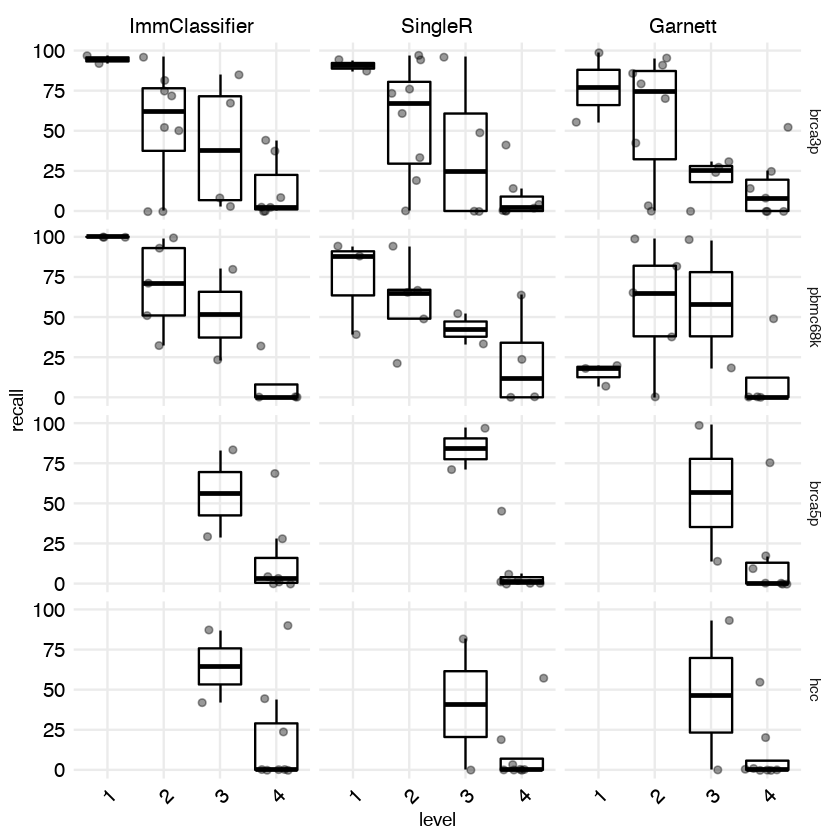

In [1979]:

 perf %>%   mutate(level = factor(level, levels = c(1,2,3,4)),
           method = factor(method, levels = c('ImmClassifier', 'SingleR', 'Garnett')),
           dataset = factor(dataset, levels = c('brca3p', 'pbmc68k', 'brca5p', 'hcc'))) %>%
     ggplot(aes(x=level, y=recall)) + 
   
    geom_point(alpha = 0.4, position = "jitter") +
    geom_boxplot(alpha = 0, colour = "black")+
    theme_minimal() + facet_grid(dataset~method) +
    theme(#panel.grid.major = element_blank(),
                                panel.grid.minor = element_blank(),
                                strip.text.x = element_text(size = 12, colour = "black", angle = 0),
                               # panel.border = element_rect(color = "black", fill = NA, size = .1),
                                axis.text.x = element_text(angle = 45, size = 12, hjust = 1,color= "black"), 
                                axis.text.y = element_text(size =12, hjust = 1,color = "black"))
      
      

In [1996]:
perf.order <- perf %>%  mutate(celltype = paste(celltype, dataset, method, sep = ":")) 
       perf.order[1:3,]     
perf.order %>%
    mutate(celltype = factor(celltype, levels = perf.order[order(perf.order$recall), 'recall'])) %>%
   ggplot(aes(x=celltype, y=recall)) + 
    geom_point(alpha = 0.4, position = "jitter") +
    geom_bar(stat="identity") +  theme_minimal()

celltype,dataset,recall,precision,method,level
L:brca3p:ImmClassifier,brca3p,97,99,ImmClassifier,1
M:brca3p:SingleR,brca3p,94,95,SingleR,1
L:brca3p:Garnett,brca3p,99,99,Garnett,1


ERROR: Error: Evaluation error: factor level [2] is duplicated.


In [2000]:
perf.order[order(perf.order$recall), 'celltype'] 

[1] "Mast:brca3p:ImmClassifier"         "Macrophage:brca3p:ImmClassifier"  
  [3] "Neutrophil:brca3p:SingleR"         "Mast:brca3p:Garnett"              
  [5] "pDC:brca3p:SingleR"                "mDC:brca3p:SingleR"               
  [7] "pDC:brca3p:Garnett"                "Treg:brca3p:SingleR"              
  [9] "CD4+ TNaive:brca3p:Garnett"        "CD4+ TCM:brca3p:ImmClassifier"    
 [11] "CD4+ TEM:brca3p:SingleR"           "CD8+ TNaive:brca3p:Garnett"       
 [13] "CD8+ TCM:brca3p:ImmClassifier"     "CD8+ TEM:brca3p:SingleR"          
 [15] "Treg:brca3p:Garnett"               "CD8+ TCM:brca5p:Garnett"          
 [17] "Treg:brca5p:SingleR"               "CD4+ TNaive:brca5p:Garnett"       
 [19] "CD4+ TCM:brca5p:ImmClassifier"     "CD4+ TEM:brca5p:SingleR"          
 [21] "CD8+ TNaive:brca5p:Garnett"        "CD8+ TCM:brca5p:ImmClassifier"    
 [23] "CD8+ TEM:brca5p:SingleR"           "Treg:brca5p:Garnett"              
 [25] "CD4:hcc:SingleR"                   "CD8:hcc:Garnett"                  
 [27] "Tfh:hcc:Garnett"                   "CD4+ TEx:hcc:ImmClassifier"       
 [29] "Tfh:hcc:SingleR"                   "Treg:hcc:Garnett"                 
 [31] "CD8+ TEx:hcc:ImmClassifier"        "CD8+ TNaive:hcc:SingleR"          
 [33] "MAIT:hcc:ImmClassifier"            "CD4+ TNaive:hcc:SingleR"          
 [35] "CD4+ TEx:hcc:Garnett"              "Tfh:hcc:ImmClassifier"            
 [37] "Treg:hcc:SingleR"                  "CD8+ TEx:hcc:Garnett"             
 [39] "CD8+ TNaive:hcc:ImmClassifier"     "CD8+ TEM:hcc:SingleR"             
 [41] "MAIT:hcc:Garnett"                  "Dendritic:pbmc68k:Garnett"        
 [43] "Tfh:pbmc68k:ImmClassifier"         "CD8+ TNaive:pbmc68k:Garnett"      
 [45] "Treg:pbmc68k:ImmClassifier"        "Tfh:pbmc68k:SingleR"              
 [47] "CD4+ TNaive:pbmc68k:Garnett"       "CD8+ TNaive:pbmc68k:ImmClassifier"
 [49] "Treg:pbmc68k:SingleR"              "Tfh:pbmc68k:Garnett"              
 [51] "CD8+ TCM:brca5p:SingleR"           "CD8+ TEM:brca5p:ImmClassifier"    
 [53] "CD8+ TEM:hcc:Garnett"              "CD8+ TCM:brca3p:SingleR"          
 [55] "Treg:brca3p:ImmClassifier"         "CD8+ TEM:brca3p:ImmClassifier"    
 [57] "CD8+ TNaive:brca5p:SingleR"        "Dendritic:brca3p:Garnett"         
 [59] "mDC:brca3p:ImmClassifier"          "CD8+ TNaive:brca5p:ImmClassifier" 
 [61] "CD8+ TEx:hcc:SingleR"              "CD8+ TNaive:brca3p:SingleR"       
 [63] "CD4+ TNaive:brca5p:ImmClassifier"  "CD4+ TNaive:brca5p:SingleR"       
 [65] "CD34:pbmc68k:Garnett"              "CD8:brca3p:ImmClassifier"         
 [67] "CD8+ TNaive:brca3p:ImmClassifier"  "CD8+ TCM:brca3p:Garnett"          
 [69] "CD4+ TEM:brca5p:Garnett"           "CD4+ TCM:brca3p:SingleR"          
 [71] "CD4+ TEM:brca3p:Garnett"           "CD8:brca5p:Garnett"               
 [73] "CD8+ TEM:brca5p:Garnett"           "CD34:pbmc68k:Garnett"             
 [75] "CD8:pbmc68k:Garnett"               "Dendritic:brca3p:SingleR"         
 [77] "CD4+ TEx:hcc:SingleR"              "CD4+ TNaive:hcc:Garnett"          
 [79] "CD34:pbmc68k:Garnett"              "Dendritic:pbmc68k:SingleR"        
 [81] "CD8:pbmc68k:ImmClassifier"         "mDC:brca3p:Garnett"               
 [83] "CD4+ TNaive:hcc:ImmClassifier"     "CD8+ TNaive:pbmc68k:SingleR"      
 [85] "CD8+ TEM:brca3p:Garnett"           "CD8:brca3p:Garnett"               
 [87] "CD4+ TEM:brca5p:ImmClassifier"     "CD8:brca5p:ImmClassifier"         
 [89] "CD4:brca3p:Garnett"                "Dendritic:pbmc68k:ImmClassifier"  
 [91] "CD4+ TNaive:pbmc68k:ImmClassifier" "Monocyte:brca3p:SingleR"          
 [93] "CD4:pbmc68k:SingleR"               "CD4+ TNaive:brca3p:ImmClassifier" 
 [95] "Monocyte:pbmc68k:Garnett"          "M:pbmc68k:SingleR"                
 [97] "CD4+ TNaive:brca3p:SingleR"        "Monocyte:brca3p:Garnett"          
 [99] "CD8:hcc:ImmClassifier"             "CD4+ TEM:brca3p:ImmClassifier"    
[101] "CD8+ TEM:hcc:ImmClassifier"        "CD4+ TCM:brca5p:SingleR"          
[103] "CD8:brca3p:Single

In [2002]:
perf.order %>% filter(duplicated(celltype))

celltype,dataset,recall,precision,method,level
L:pbmc68k:ImmClassifier,pbmc68k,100,99,ImmClassifier,1
M:pbmc68k:SingleR,pbmc68k,88,100,SingleR,1
CD34:pbmc68k:Garnett,pbmc68k,20,78,Garnett,1
L:pbmc68k:ImmClassifier,pbmc68k,100,98,ImmClassifier,1
M:pbmc68k:SingleR,pbmc68k,39,94,SingleR,1
CD34:pbmc68k:Garnett,pbmc68k,7,37,Garnett,1


In [2004]:
perf.order %>% filter(celltype == 'L:pbmc68k:ImmClassifier')

celltype,dataset,recall,precision,method,level
L:pbmc68k:ImmClassifier,pbmc68k,100,100,ImmClassifier,1
L:pbmc68k:ImmClassifier,pbmc68k,100,99,ImmClassifier,1
L:pbmc68k:ImmClassifier,pbmc68k,100,98,ImmClassifier,1


In [2009]:
perf  %>% filter(dataset == 'pbmc68k', method == 'ImmClassifier')

celltype,dataset,recall,precision,method,level
L,pbmc68k,100,100,ImmClassifier,1
L,pbmc68k,100,99,ImmClassifier,1
L,pbmc68k,100,98,ImmClassifier,1
B,pbmc68k,71,69,ImmClassifier,2
Dendritic,pbmc68k,32,85,ImmClassifier,2
T,pbmc68k,99,88,ImmClassifier,2
Monocyte,pbmc68k,93,60,ImmClassifier,2
NK,pbmc68k,51,80,ImmClassifier,2
CD4,pbmc68k,80,69,ImmClassifier,3
CD8,pbmc68k,23,49,ImmClassifier,3


In [2012]:
data.frame(celltype = rep(pbmc68k.L1.celltypes, 3),  dataset = "pbmc68k", 
                 recall=c(pbmc68k.ImmC.L1.recall,pbmc68k.SingleR.L1.recall,pbmc68k.Garnett.L1.recall),
                 precision=c(pbmc68k.ImmC.L1.ppv,pbmc68k.SingleR.L1.ppv,pbmc68k.Garnett.L1.ppv), 
                 method=rep(c("ImmClassifier", "SingleR", "Garnett"), length(pbmc68k.L1.celltypes)), 
                 level = 1, stringsAsFactors = F)

celltype,dataset,recall,precision,method,level
L,pbmc68k,100,100,ImmClassifier,1
M,pbmc68k,94,94,SingleR,1
CD34,pbmc68k,18,30,Garnett,1
L,pbmc68k,100,99,ImmClassifier,1
M,pbmc68k,88,100,SingleR,1
CD34,pbmc68k,20,78,Garnett,1
L,pbmc68k,100,98,ImmClassifier,1
M,pbmc68k,39,94,SingleR,1
CD34,pbmc68k,7,37,Garnett,1
